In [12]:
!pip install -q imageio

In [116]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import *
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop
from keras.models import *
# from keras.datasets import mnist
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model

import tensorflow as tf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
import IPython
import imageio
import glob
from IPython import display
from IPython.display import HTML

In [2]:
DFtrain = pd.read_csv('../input/computer-vision-learning-contest-dacon/train.csv')
test = pd.read_csv('../input/computer-vision-learning-contest-dacon/test.csv')
submission = pd.read_csv('../input/computer-vision-learning-contest-dacon/submission.csv')

In [3]:
X_train = (DFtrain[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_train = to_categorical(DFtrain['digit'].values)

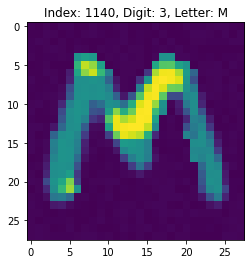

In [4]:
idx = np.random.randint(0, 2048)
img = DFtrain.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = DFtrain.loc[idx, 'digit']
letter = DFtrain.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

In [9]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    @tf.function
    def build_generator(self):
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    @tf.function
    def build_discriminator(self):
        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    @tf.function
    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        X_train = (DFtrain[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
        y_train = to_categorical(DFtrain['digit'].values)

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("%d.png" % epoch)
        plt.close()


cgan = CGAN()
cgan.train(epochs=20000, batch_size=32, sample_interval=200)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 512)              

87 [D loss: 0.003171, acc.: 100.00%] [G loss: 3.305044]
88 [D loss: 0.007485, acc.: 100.00%] [G loss: 4.362014]
89 [D loss: 0.002296, acc.: 100.00%] [G loss: 3.853989]
90 [D loss: 0.002713, acc.: 100.00%] [G loss: 3.795748]
91 [D loss: 0.001921, acc.: 100.00%] [G loss: 3.583843]
92 [D loss: 0.001402, acc.: 100.00%] [G loss: 3.603029]
93 [D loss: 0.002040, acc.: 100.00%] [G loss: 4.530936]
94 [D loss: 0.001944, acc.: 100.00%] [G loss: 3.871643]
95 [D loss: 0.004170, acc.: 100.00%] [G loss: 3.853723]
96 [D loss: 0.003449, acc.: 100.00%] [G loss: 3.707572]
97 [D loss: 0.001909, acc.: 100.00%] [G loss: 3.422240]
98 [D loss: 0.001061, acc.: 100.00%] [G loss: 3.906945]
99 [D loss: 0.001977, acc.: 100.00%] [G loss: 4.308846]
100 [D loss: 0.001397, acc.: 100.00%] [G loss: 4.150417]
101 [D loss: 0.001955, acc.: 100.00%] [G loss: 4.671292]
102 [D loss: 0.001106, acc.: 100.00%] [G loss: 3.884177]
103 [D loss: 0.001805, acc.: 100.00%] [G loss: 4.531519]
104 [D loss: 0.001516, acc.: 100.00%] [G los

232 [D loss: 0.204084, acc.: 96.88%] [G loss: 3.356460]
233 [D loss: 0.162204, acc.: 98.44%] [G loss: 5.150126]
234 [D loss: 0.230777, acc.: 87.50%] [G loss: 5.623803]
235 [D loss: 0.172385, acc.: 96.88%] [G loss: 5.222905]
236 [D loss: 0.173354, acc.: 96.88%] [G loss: 5.968275]
237 [D loss: 0.201183, acc.: 90.62%] [G loss: 6.536133]
238 [D loss: 0.190489, acc.: 96.88%] [G loss: 5.367168]
239 [D loss: 0.163069, acc.: 95.31%] [G loss: 5.641117]
240 [D loss: 0.190472, acc.: 93.75%] [G loss: 6.323456]
241 [D loss: 0.289419, acc.: 90.62%] [G loss: 7.102951]
242 [D loss: 0.330015, acc.: 89.06%] [G loss: 5.568721]
243 [D loss: 0.196177, acc.: 92.19%] [G loss: 6.146762]
244 [D loss: 0.158525, acc.: 98.44%] [G loss: 6.347273]
245 [D loss: 0.314022, acc.: 87.50%] [G loss: 6.527924]
246 [D loss: 0.394097, acc.: 84.38%] [G loss: 5.950534]
247 [D loss: 0.315903, acc.: 89.06%] [G loss: 5.865238]
248 [D loss: 0.322401, acc.: 84.38%] [G loss: 7.262447]
249 [D loss: 2.299951, acc.: 20.31%] [G loss: 3.

382 [D loss: 0.644238, acc.: 59.38%] [G loss: 3.719193]
383 [D loss: 0.648038, acc.: 62.50%] [G loss: 4.733582]
384 [D loss: 0.690974, acc.: 51.56%] [G loss: 5.075787]
385 [D loss: 0.654319, acc.: 56.25%] [G loss: 3.619915]
386 [D loss: 0.665950, acc.: 59.38%] [G loss: 3.021856]
387 [D loss: 0.686808, acc.: 48.44%] [G loss: 3.696959]
388 [D loss: 0.627387, acc.: 68.75%] [G loss: 4.134813]
389 [D loss: 0.657300, acc.: 67.19%] [G loss: 3.172850]
390 [D loss: 0.703681, acc.: 39.06%] [G loss: 2.904079]
391 [D loss: 0.591178, acc.: 68.75%] [G loss: 2.998433]
392 [D loss: 0.648506, acc.: 64.06%] [G loss: 3.772152]
393 [D loss: 0.641708, acc.: 43.75%] [G loss: 2.928385]
394 [D loss: 0.662160, acc.: 59.38%] [G loss: 4.867395]
395 [D loss: 0.632342, acc.: 67.19%] [G loss: 3.016246]
396 [D loss: 0.651326, acc.: 67.19%] [G loss: 4.200084]
397 [D loss: 0.697011, acc.: 48.44%] [G loss: 2.969469]
398 [D loss: 0.694779, acc.: 54.69%] [G loss: 4.223990]
399 [D loss: 0.703771, acc.: 54.69%] [G loss: 3.

532 [D loss: 0.664039, acc.: 43.75%] [G loss: 3.396186]
533 [D loss: 0.714239, acc.: 28.12%] [G loss: 2.677811]
534 [D loss: 0.669518, acc.: 62.50%] [G loss: 2.130433]
535 [D loss: 0.641726, acc.: 68.75%] [G loss: 2.548131]
536 [D loss: 0.757314, acc.: 7.81%] [G loss: 2.255404]
537 [D loss: 0.706087, acc.: 53.12%] [G loss: 2.177244]
538 [D loss: 0.674297, acc.: 56.25%] [G loss: 2.094903]
539 [D loss: 0.684373, acc.: 54.69%] [G loss: 1.744357]
540 [D loss: 0.698630, acc.: 50.00%] [G loss: 1.712964]
541 [D loss: 0.679773, acc.: 51.56%] [G loss: 2.237751]
542 [D loss: 0.679719, acc.: 56.25%] [G loss: 2.909910]
543 [D loss: 0.654620, acc.: 57.81%] [G loss: 2.788830]
544 [D loss: 0.696378, acc.: 51.56%] [G loss: 1.504251]
545 [D loss: 0.684816, acc.: 50.00%] [G loss: 1.647754]
546 [D loss: 0.682265, acc.: 56.25%] [G loss: 1.885030]
547 [D loss: 0.654843, acc.: 59.38%] [G loss: 3.044657]
548 [D loss: 0.693737, acc.: 53.12%] [G loss: 3.161331]
549 [D loss: 0.675599, acc.: 62.50%] [G loss: 2.3

679 [D loss: 0.764092, acc.: 0.00%] [G loss: 2.252192]
680 [D loss: 0.679890, acc.: 59.38%] [G loss: 2.001856]
681 [D loss: 0.683613, acc.: 51.56%] [G loss: 2.124343]
682 [D loss: 0.657628, acc.: 59.38%] [G loss: 2.052876]
683 [D loss: 0.673713, acc.: 51.56%] [G loss: 1.974211]
684 [D loss: 0.679085, acc.: 54.69%] [G loss: 1.701738]
685 [D loss: 0.666035, acc.: 57.81%] [G loss: 1.887768]
686 [D loss: 0.658841, acc.: 64.06%] [G loss: 2.611172]
687 [D loss: 0.645008, acc.: 56.25%] [G loss: 1.852814]
688 [D loss: 0.689984, acc.: 25.00%] [G loss: 2.378282]
689 [D loss: 0.641138, acc.: 67.19%] [G loss: 3.702779]
690 [D loss: 0.666943, acc.: 43.75%] [G loss: 2.202777]
691 [D loss: 0.855319, acc.: 1.56%] [G loss: 1.851830]
692 [D loss: 0.710764, acc.: 51.56%] [G loss: 1.575120]
693 [D loss: 0.700492, acc.: 53.12%] [G loss: 1.526877]
694 [D loss: 0.706182, acc.: 50.00%] [G loss: 2.995606]
695 [D loss: 0.689981, acc.: 53.12%] [G loss: 2.690588]
696 [D loss: 0.684958, acc.: 51.56%] [G loss: 2.74

828 [D loss: 0.644072, acc.: 56.25%] [G loss: 1.797279]
829 [D loss: 0.670397, acc.: 56.25%] [G loss: 1.679318]
830 [D loss: 0.669766, acc.: 56.25%] [G loss: 2.549946]
831 [D loss: 0.644391, acc.: 64.06%] [G loss: 1.425215]
832 [D loss: 0.674439, acc.: 62.50%] [G loss: 1.676137]
833 [D loss: 0.627014, acc.: 57.81%] [G loss: 2.232783]
834 [D loss: 0.658877, acc.: 29.69%] [G loss: 2.165177]
835 [D loss: 0.671804, acc.: 43.75%] [G loss: 2.105020]
836 [D loss: 0.705253, acc.: 15.62%] [G loss: 1.912891]
837 [D loss: 0.685370, acc.: 56.25%] [G loss: 1.698519]
838 [D loss: 0.647699, acc.: 59.38%] [G loss: 2.540781]
839 [D loss: 0.667858, acc.: 65.62%] [G loss: 2.196697]
840 [D loss: 0.658938, acc.: 65.62%] [G loss: 2.121296]
841 [D loss: 0.700958, acc.: 10.94%] [G loss: 1.490733]
842 [D loss: 0.664069, acc.: 56.25%] [G loss: 1.341435]
843 [D loss: 0.689381, acc.: 57.81%] [G loss: 1.263943]
844 [D loss: 0.686119, acc.: 56.25%] [G loss: 2.148248]
845 [D loss: 0.637241, acc.: 68.75%] [G loss: 3.

975 [D loss: 0.696337, acc.: 35.94%] [G loss: 1.185709]
976 [D loss: 0.695556, acc.: 29.69%] [G loss: 3.433905]
977 [D loss: 0.690147, acc.: 37.50%] [G loss: 1.498206]
978 [D loss: 0.690171, acc.: 39.06%] [G loss: 1.332297]
979 [D loss: 0.668629, acc.: 50.00%] [G loss: 1.408803]
980 [D loss: 0.713645, acc.: 4.69%] [G loss: 2.582697]
981 [D loss: 0.703063, acc.: 48.44%] [G loss: 2.971237]
982 [D loss: 0.695690, acc.: 50.00%] [G loss: 1.197748]
983 [D loss: 0.685135, acc.: 51.56%] [G loss: 1.392039]
984 [D loss: 0.693873, acc.: 54.69%] [G loss: 1.341339]
985 [D loss: 0.691113, acc.: 53.12%] [G loss: 1.608334]
986 [D loss: 0.670695, acc.: 53.12%] [G loss: 1.312305]
987 [D loss: 0.673715, acc.: 54.69%] [G loss: 2.188667]
988 [D loss: 0.686700, acc.: 54.69%] [G loss: 2.407815]
989 [D loss: 0.683291, acc.: 51.56%] [G loss: 1.594182]
990 [D loss: 0.685160, acc.: 51.56%] [G loss: 1.548564]
991 [D loss: 0.693065, acc.: 48.44%] [G loss: 3.053582]
992 [D loss: 0.642716, acc.: 68.75%] [G loss: 1.7

1121 [D loss: 0.674094, acc.: 37.50%] [G loss: 4.581917]
1122 [D loss: 0.693946, acc.: 48.44%] [G loss: 2.048571]
1123 [D loss: 0.677099, acc.: 50.00%] [G loss: 1.787164]
1124 [D loss: 0.676671, acc.: 48.44%] [G loss: 1.308798]
1125 [D loss: 0.679383, acc.: 51.56%] [G loss: 2.041794]
1126 [D loss: 0.698987, acc.: 46.88%] [G loss: 1.664334]
1127 [D loss: 0.682745, acc.: 48.44%] [G loss: 1.451077]
1128 [D loss: 0.671026, acc.: 53.12%] [G loss: 1.229792]
1129 [D loss: 0.717948, acc.: 17.19%] [G loss: 1.487363]
1130 [D loss: 0.693880, acc.: 51.56%] [G loss: 2.082367]
1131 [D loss: 0.681513, acc.: 53.12%] [G loss: 1.007767]
1132 [D loss: 0.682968, acc.: 53.12%] [G loss: 1.166217]
1133 [D loss: 0.682523, acc.: 53.12%] [G loss: 2.092322]
1134 [D loss: 0.678295, acc.: 56.25%] [G loss: 2.980499]
1135 [D loss: 0.683886, acc.: 56.25%] [G loss: 2.318201]
1136 [D loss: 0.671348, acc.: 56.25%] [G loss: 1.973914]
1137 [D loss: 0.688642, acc.: 54.69%] [G loss: 1.420801]
1138 [D loss: 0.666517, acc.: 6

1265 [D loss: 0.678703, acc.: 51.56%] [G loss: 1.707201]
1266 [D loss: 0.680129, acc.: 53.12%] [G loss: 1.319526]
1267 [D loss: 0.672204, acc.: 51.56%] [G loss: 2.854987]
1268 [D loss: 0.633268, acc.: 60.94%] [G loss: 0.978600]
1269 [D loss: 0.681424, acc.: 51.56%] [G loss: 1.158633]
1270 [D loss: 0.669679, acc.: 62.50%] [G loss: 2.281513]
1271 [D loss: 0.654903, acc.: 53.12%] [G loss: 1.186947]
1272 [D loss: 0.685225, acc.: 43.75%] [G loss: 2.073548]
1273 [D loss: 0.686698, acc.: 43.75%] [G loss: 1.380987]
1274 [D loss: 0.660808, acc.: 46.88%] [G loss: 0.968996]
1275 [D loss: 0.675695, acc.: 43.75%] [G loss: 2.004272]
1276 [D loss: 0.670417, acc.: 40.62%] [G loss: 1.198419]
1277 [D loss: 0.688723, acc.: 46.88%] [G loss: 1.779103]
1278 [D loss: 0.685945, acc.: 51.56%] [G loss: 1.466932]
1279 [D loss: 0.691577, acc.: 45.31%] [G loss: 1.289733]
1280 [D loss: 0.698315, acc.: 26.56%] [G loss: 1.129249]
1281 [D loss: 0.661147, acc.: 59.38%] [G loss: 1.220001]
1282 [D loss: 0.676415, acc.: 5

1409 [D loss: 0.658982, acc.: 68.75%] [G loss: 1.030443]
1410 [D loss: 0.692450, acc.: 51.56%] [G loss: 4.229683]
1411 [D loss: 0.687147, acc.: 54.69%] [G loss: 1.861895]
1412 [D loss: 0.674401, acc.: 40.62%] [G loss: 1.899303]
1413 [D loss: 0.673203, acc.: 39.06%] [G loss: 2.608380]
1414 [D loss: 0.687004, acc.: 39.06%] [G loss: 5.452708]
1415 [D loss: 0.677302, acc.: 37.50%] [G loss: 1.398146]
1416 [D loss: 0.681395, acc.: 43.75%] [G loss: 1.158899]
1417 [D loss: 0.690276, acc.: 46.88%] [G loss: 1.235004]
1418 [D loss: 0.692659, acc.: 50.00%] [G loss: 1.593415]
1419 [D loss: 0.669972, acc.: 50.00%] [G loss: 1.834358]
1420 [D loss: 0.671521, acc.: 50.00%] [G loss: 3.462439]
1421 [D loss: 0.703474, acc.: 35.94%] [G loss: 1.890000]
1422 [D loss: 0.692791, acc.: 42.19%] [G loss: 2.235450]
1423 [D loss: 0.694757, acc.: 50.00%] [G loss: 4.980083]
1424 [D loss: 0.694439, acc.: 43.75%] [G loss: 3.050778]
1425 [D loss: 0.694717, acc.: 53.12%] [G loss: 1.121428]
1426 [D loss: 0.684404, acc.: 5

1554 [D loss: 0.691352, acc.: 54.69%] [G loss: 0.743678]
1555 [D loss: 0.693769, acc.: 43.75%] [G loss: 1.107971]
1556 [D loss: 0.685055, acc.: 40.62%] [G loss: 0.899543]
1557 [D loss: 0.696359, acc.: 28.12%] [G loss: 1.459109]
1558 [D loss: 0.690794, acc.: 34.38%] [G loss: 1.340178]
1559 [D loss: 0.688638, acc.: 42.19%] [G loss: 1.629952]
1560 [D loss: 0.691319, acc.: 48.44%] [G loss: 1.625598]
1561 [D loss: 0.700523, acc.: 48.44%] [G loss: 1.297531]
1562 [D loss: 0.696492, acc.: 37.50%] [G loss: 1.443270]
1563 [D loss: 0.689528, acc.: 39.06%] [G loss: 0.768719]
1564 [D loss: 0.698175, acc.: 43.75%] [G loss: 0.722082]
1565 [D loss: 0.670145, acc.: 45.31%] [G loss: 1.961031]
1566 [D loss: 0.720613, acc.: 6.25%] [G loss: 2.778443]
1567 [D loss: 0.699084, acc.: 48.44%] [G loss: 2.492364]
1568 [D loss: 0.691303, acc.: 50.00%] [G loss: 0.965149]
1569 [D loss: 0.685095, acc.: 53.12%] [G loss: 0.765471]
1570 [D loss: 0.692830, acc.: 50.00%] [G loss: 1.636174]
1571 [D loss: 0.676595, acc.: 53

1698 [D loss: 0.694349, acc.: 50.00%] [G loss: 0.770304]
1699 [D loss: 0.692742, acc.: 53.12%] [G loss: 1.234506]
1700 [D loss: 0.689568, acc.: 57.81%] [G loss: 0.892320]
1701 [D loss: 0.688196, acc.: 54.69%] [G loss: 1.153654]
1702 [D loss: 0.693912, acc.: 53.12%] [G loss: 0.880707]
1703 [D loss: 0.693541, acc.: 46.88%] [G loss: 0.668730]
1704 [D loss: 0.673432, acc.: 39.06%] [G loss: 0.692040]
1705 [D loss: 0.682849, acc.: 48.44%] [G loss: 0.704866]
1706 [D loss: 0.667441, acc.: 46.88%] [G loss: 1.109966]
1707 [D loss: 0.686441, acc.: 43.75%] [G loss: 0.978752]
1708 [D loss: 0.695783, acc.: 48.44%] [G loss: 0.959708]
1709 [D loss: 0.696668, acc.: 50.00%] [G loss: 1.255683]
1710 [D loss: 0.694136, acc.: 50.00%] [G loss: 1.949408]
1711 [D loss: 0.678132, acc.: 48.44%] [G loss: 0.773784]
1712 [D loss: 0.681843, acc.: 50.00%] [G loss: 1.200526]
1713 [D loss: 0.684455, acc.: 48.44%] [G loss: 1.032901]
1714 [D loss: 0.682015, acc.: 48.44%] [G loss: 1.182555]
1715 [D loss: 0.678948, acc.: 4

1845 [D loss: 0.693797, acc.: 56.25%] [G loss: 0.763663]
1846 [D loss: 0.694497, acc.: 42.19%] [G loss: 1.058018]
1847 [D loss: 0.694864, acc.: 53.12%] [G loss: 1.165425]
1848 [D loss: 0.693890, acc.: 40.62%] [G loss: 1.459954]
1849 [D loss: 0.693422, acc.: 50.00%] [G loss: 0.940341]
1850 [D loss: 0.695098, acc.: 35.94%] [G loss: 0.910939]
1851 [D loss: 0.697070, acc.: 25.00%] [G loss: 0.683048]
1852 [D loss: 0.693279, acc.: 43.75%] [G loss: 0.750360]
1853 [D loss: 0.694157, acc.: 37.50%] [G loss: 0.700922]
1854 [D loss: 0.695828, acc.: 31.25%] [G loss: 0.663821]
1855 [D loss: 0.696773, acc.: 26.56%] [G loss: 0.859015]
1856 [D loss: 0.695411, acc.: 34.38%] [G loss: 0.673433]
1857 [D loss: 0.693577, acc.: 32.81%] [G loss: 0.912731]
1858 [D loss: 0.694607, acc.: 40.62%] [G loss: 0.736584]
1859 [D loss: 0.696136, acc.: 39.06%] [G loss: 0.703198]
1860 [D loss: 0.695664, acc.: 43.75%] [G loss: 1.916075]
1861 [D loss: 0.693391, acc.: 40.62%] [G loss: 0.786598]
1862 [D loss: 0.694615, acc.: 4

1991 [D loss: 0.686351, acc.: 50.00%] [G loss: 0.851377]
1992 [D loss: 0.694413, acc.: 50.00%] [G loss: 0.740793]
1993 [D loss: 0.695319, acc.: 48.44%] [G loss: 0.704733]
1994 [D loss: 0.695801, acc.: 51.56%] [G loss: 0.725115]
1995 [D loss: 0.692375, acc.: 51.56%] [G loss: 0.993493]
1996 [D loss: 0.694916, acc.: 51.56%] [G loss: 0.757075]
1997 [D loss: 0.693617, acc.: 51.56%] [G loss: 0.821232]
1998 [D loss: 0.694351, acc.: 50.00%] [G loss: 0.896632]
1999 [D loss: 0.682198, acc.: 54.69%] [G loss: 0.859357]
2000 [D loss: 0.693415, acc.: 45.31%] [G loss: 0.735818]
2001 [D loss: 0.695063, acc.: 40.62%] [G loss: 1.263926]
2002 [D loss: 0.685086, acc.: 48.44%] [G loss: 0.798658]
2003 [D loss: 0.687693, acc.: 39.06%] [G loss: 0.793918]
2004 [D loss: 0.686810, acc.: 42.19%] [G loss: 1.262669]
2005 [D loss: 0.691211, acc.: 42.19%] [G loss: 1.024837]
2006 [D loss: 0.694323, acc.: 48.44%] [G loss: 1.197952]
2007 [D loss: 0.694899, acc.: 50.00%] [G loss: 0.722202]
2008 [D loss: 0.682202, acc.: 4

2136 [D loss: 0.693945, acc.: 50.00%] [G loss: 0.683655]
2137 [D loss: 0.697025, acc.: 50.00%] [G loss: 0.866498]
2138 [D loss: 0.695484, acc.: 50.00%] [G loss: 0.672257]
2139 [D loss: 0.689535, acc.: 54.69%] [G loss: 0.786897]
2140 [D loss: 0.692198, acc.: 51.56%] [G loss: 0.998799]
2141 [D loss: 0.693152, acc.: 50.00%] [G loss: 0.687674]
2142 [D loss: 0.692692, acc.: 51.56%] [G loss: 0.681669]
2143 [D loss: 0.694315, acc.: 51.56%] [G loss: 0.790869]
2144 [D loss: 0.694099, acc.: 46.88%] [G loss: 0.684642]
2145 [D loss: 0.696809, acc.: 48.44%] [G loss: 0.691459]
2146 [D loss: 0.694400, acc.: 50.00%] [G loss: 0.817804]
2147 [D loss: 0.694664, acc.: 51.56%] [G loss: 1.541437]
2148 [D loss: 0.697648, acc.: 43.75%] [G loss: 0.726604]
2149 [D loss: 0.692139, acc.: 56.25%] [G loss: 0.668170]
2150 [D loss: 0.692418, acc.: 51.56%] [G loss: 0.757660]
2151 [D loss: 0.696054, acc.: 50.00%] [G loss: 0.847417]
2152 [D loss: 0.695311, acc.: 48.44%] [G loss: 0.681076]
2153 [D loss: 0.693067, acc.: 5

2281 [D loss: 0.695128, acc.: 53.12%] [G loss: 0.715125]
2282 [D loss: 0.694956, acc.: 46.88%] [G loss: 0.692593]
2283 [D loss: 0.688125, acc.: 48.44%] [G loss: 0.714934]
2284 [D loss: 0.692584, acc.: 51.56%] [G loss: 0.771877]
2285 [D loss: 0.693050, acc.: 51.56%] [G loss: 0.821700]
2286 [D loss: 0.694165, acc.: 48.44%] [G loss: 1.232360]
2287 [D loss: 0.695396, acc.: 45.31%] [G loss: 0.745662]
2288 [D loss: 0.684499, acc.: 50.00%] [G loss: 0.678532]
2289 [D loss: 0.694536, acc.: 46.88%] [G loss: 0.710806]
2290 [D loss: 0.695176, acc.: 51.56%] [G loss: 0.887827]
2291 [D loss: 0.694519, acc.: 50.00%] [G loss: 0.783159]
2292 [D loss: 0.695118, acc.: 51.56%] [G loss: 1.059018]
2293 [D loss: 0.695523, acc.: 43.75%] [G loss: 0.703724]
2294 [D loss: 0.693467, acc.: 51.56%] [G loss: 0.751793]
2295 [D loss: 0.694990, acc.: 50.00%] [G loss: 1.253102]
2296 [D loss: 0.693600, acc.: 45.31%] [G loss: 0.685120]
2297 [D loss: 0.692085, acc.: 46.88%] [G loss: 0.768143]
2298 [D loss: 0.696768, acc.: 4

2428 [D loss: 0.684158, acc.: 43.75%] [G loss: 1.294793]
2429 [D loss: 0.684909, acc.: 35.94%] [G loss: 0.681422]
2430 [D loss: 0.695694, acc.: 32.81%] [G loss: 1.071520]
2431 [D loss: 0.687342, acc.: 45.31%] [G loss: 0.702922]
2432 [D loss: 0.695046, acc.: 43.75%] [G loss: 0.721168]
2433 [D loss: 0.694887, acc.: 43.75%] [G loss: 1.528989]
2434 [D loss: 0.683943, acc.: 45.31%] [G loss: 0.823072]
2435 [D loss: 0.693071, acc.: 51.56%] [G loss: 0.796481]
2436 [D loss: 0.693901, acc.: 43.75%] [G loss: 1.133021]
2437 [D loss: 0.691479, acc.: 50.00%] [G loss: 0.848554]
2438 [D loss: 0.697977, acc.: 50.00%] [G loss: 1.005841]
2439 [D loss: 0.693096, acc.: 50.00%] [G loss: 1.334130]
2440 [D loss: 0.690687, acc.: 50.00%] [G loss: 0.924986]
2441 [D loss: 0.715877, acc.: 21.88%] [G loss: 1.273509]
2442 [D loss: 0.697915, acc.: 45.31%] [G loss: 0.841913]
2443 [D loss: 0.694420, acc.: 50.00%] [G loss: 0.983127]
2444 [D loss: 0.684770, acc.: 53.12%] [G loss: 0.707548]
2445 [D loss: 0.693767, acc.: 5

2574 [D loss: 0.695202, acc.: 45.31%] [G loss: 0.685460]
2575 [D loss: 0.695106, acc.: 37.50%] [G loss: 0.835901]
2576 [D loss: 0.693936, acc.: 40.62%] [G loss: 1.011855]
2577 [D loss: 0.695006, acc.: 42.19%] [G loss: 0.776152]
2578 [D loss: 0.695235, acc.: 43.75%] [G loss: 0.667485]
2579 [D loss: 0.693211, acc.: 40.62%] [G loss: 0.669128]
2580 [D loss: 0.693197, acc.: 46.88%] [G loss: 0.913969]
2581 [D loss: 0.695095, acc.: 39.06%] [G loss: 0.666847]
2582 [D loss: 0.694507, acc.: 48.44%] [G loss: 0.668886]
2583 [D loss: 0.693881, acc.: 48.44%] [G loss: 0.912590]
2584 [D loss: 0.694357, acc.: 39.06%] [G loss: 0.760174]
2585 [D loss: 0.695404, acc.: 34.38%] [G loss: 0.670859]
2586 [D loss: 0.694873, acc.: 40.62%] [G loss: 0.736148]
2587 [D loss: 0.692856, acc.: 46.88%] [G loss: 0.684324]
2588 [D loss: 0.696579, acc.: 40.62%] [G loss: 0.678911]
2589 [D loss: 0.697364, acc.: 42.19%] [G loss: 0.734479]
2590 [D loss: 0.695535, acc.: 43.75%] [G loss: 0.739381]
2591 [D loss: 0.693356, acc.: 4

2721 [D loss: 0.694782, acc.: 45.31%] [G loss: 1.886494]
2722 [D loss: 0.695318, acc.: 50.00%] [G loss: 0.691150]
2723 [D loss: 0.694390, acc.: 50.00%] [G loss: 0.751860]
2724 [D loss: 0.691866, acc.: 50.00%] [G loss: 1.124330]
2725 [D loss: 0.682513, acc.: 51.56%] [G loss: 0.720976]
2726 [D loss: 0.697348, acc.: 46.88%] [G loss: 0.707705]
2727 [D loss: 0.695610, acc.: 50.00%] [G loss: 0.683720]
2728 [D loss: 0.695048, acc.: 50.00%] [G loss: 0.814137]
2729 [D loss: 0.693303, acc.: 50.00%] [G loss: 0.810618]
2730 [D loss: 0.693946, acc.: 50.00%] [G loss: 0.763247]
2731 [D loss: 0.690506, acc.: 46.88%] [G loss: 0.695304]
2732 [D loss: 0.694047, acc.: 48.44%] [G loss: 0.724707]
2733 [D loss: 0.696731, acc.: 50.00%] [G loss: 1.341363]
2734 [D loss: 0.695433, acc.: 50.00%] [G loss: 1.119343]
2735 [D loss: 0.695256, acc.: 48.44%] [G loss: 0.697028]
2736 [D loss: 0.694757, acc.: 50.00%] [G loss: 1.379635]
2737 [D loss: 0.693105, acc.: 48.44%] [G loss: 0.715940]
2738 [D loss: 0.694755, acc.: 5

2865 [D loss: 0.694062, acc.: 50.00%] [G loss: 0.697537]
2866 [D loss: 0.694228, acc.: 48.44%] [G loss: 0.843474]
2867 [D loss: 0.691759, acc.: 50.00%] [G loss: 0.720059]
2868 [D loss: 0.688489, acc.: 50.00%] [G loss: 0.700620]
2869 [D loss: 0.695669, acc.: 48.44%] [G loss: 0.744483]
2870 [D loss: 0.694493, acc.: 46.88%] [G loss: 0.691225]
2871 [D loss: 0.694020, acc.: 46.88%] [G loss: 0.693943]
2872 [D loss: 0.694612, acc.: 43.75%] [G loss: 0.792044]
2873 [D loss: 0.694228, acc.: 46.88%] [G loss: 0.749736]
2874 [D loss: 0.695178, acc.: 46.88%] [G loss: 0.691644]
2875 [D loss: 0.694390, acc.: 40.62%] [G loss: 0.693738]
2876 [D loss: 0.694212, acc.: 43.75%] [G loss: 0.717839]
2877 [D loss: 0.691003, acc.: 46.88%] [G loss: 0.688869]
2878 [D loss: 0.693021, acc.: 48.44%] [G loss: 0.729653]
2879 [D loss: 0.694914, acc.: 46.88%] [G loss: 0.708221]
2880 [D loss: 0.697084, acc.: 43.75%] [G loss: 1.157125]
2881 [D loss: 0.691362, acc.: 45.31%] [G loss: 0.723077]
2882 [D loss: 0.693408, acc.: 5

3009 [D loss: 0.695001, acc.: 50.00%] [G loss: 1.630605]
3010 [D loss: 0.695215, acc.: 50.00%] [G loss: 0.777106]
3011 [D loss: 0.694503, acc.: 50.00%] [G loss: 0.770451]
3012 [D loss: 0.694827, acc.: 48.44%] [G loss: 0.781081]
3013 [D loss: 0.694372, acc.: 46.88%] [G loss: 1.159771]
3014 [D loss: 0.690035, acc.: 48.44%] [G loss: 0.861279]
3015 [D loss: 0.694403, acc.: 50.00%] [G loss: 0.765203]
3016 [D loss: 0.694986, acc.: 48.44%] [G loss: 0.714124]
3017 [D loss: 0.694923, acc.: 50.00%] [G loss: 0.823864]
3018 [D loss: 0.693819, acc.: 50.00%] [G loss: 0.745074]
3019 [D loss: 0.694994, acc.: 51.56%] [G loss: 1.511552]
3020 [D loss: 0.694726, acc.: 48.44%] [G loss: 0.704850]
3021 [D loss: 0.695272, acc.: 48.44%] [G loss: 0.912187]
3022 [D loss: 0.694466, acc.: 50.00%] [G loss: 0.700806]
3023 [D loss: 0.693357, acc.: 51.56%] [G loss: 0.720689]
3024 [D loss: 0.687007, acc.: 51.56%] [G loss: 0.791077]
3025 [D loss: 0.694751, acc.: 51.56%] [G loss: 0.726203]
3026 [D loss: 0.695475, acc.: 5

3155 [D loss: 0.694794, acc.: 48.44%] [G loss: 0.701746]
3156 [D loss: 0.694281, acc.: 46.88%] [G loss: 0.718850]
3157 [D loss: 0.685783, acc.: 50.00%] [G loss: 0.714034]
3158 [D loss: 0.693490, acc.: 53.12%] [G loss: 0.705149]
3159 [D loss: 0.694160, acc.: 51.56%] [G loss: 0.701442]
3160 [D loss: 0.695700, acc.: 48.44%] [G loss: 0.953808]
3161 [D loss: 0.693738, acc.: 48.44%] [G loss: 0.696559]
3162 [D loss: 0.695156, acc.: 50.00%] [G loss: 0.734196]
3163 [D loss: 0.694552, acc.: 51.56%] [G loss: 0.691734]
3164 [D loss: 0.694939, acc.: 48.44%] [G loss: 0.744017]
3165 [D loss: 0.692080, acc.: 50.00%] [G loss: 0.757619]
3166 [D loss: 0.695295, acc.: 48.44%] [G loss: 0.785427]
3167 [D loss: 0.695267, acc.: 46.88%] [G loss: 0.709699]
3168 [D loss: 0.695051, acc.: 46.88%] [G loss: 0.686684]
3169 [D loss: 0.694719, acc.: 45.31%] [G loss: 0.748859]
3170 [D loss: 0.694787, acc.: 50.00%] [G loss: 0.693145]
3171 [D loss: 0.694342, acc.: 50.00%] [G loss: 0.694234]
3172 [D loss: 0.694126, acc.: 4

3300 [D loss: 0.694125, acc.: 50.00%] [G loss: 0.697757]
3301 [D loss: 0.689067, acc.: 50.00%] [G loss: 0.725562]
3302 [D loss: 0.694257, acc.: 50.00%] [G loss: 0.705983]
3303 [D loss: 0.696335, acc.: 50.00%] [G loss: 0.812215]
3304 [D loss: 0.694830, acc.: 48.44%] [G loss: 0.720450]
3305 [D loss: 0.694547, acc.: 50.00%] [G loss: 0.827338]
3306 [D loss: 0.694903, acc.: 50.00%] [G loss: 0.712325]
3307 [D loss: 0.694273, acc.: 50.00%] [G loss: 0.724581]
3308 [D loss: 0.695039, acc.: 50.00%] [G loss: 0.789184]
3309 [D loss: 0.694028, acc.: 50.00%] [G loss: 0.826134]
3310 [D loss: 0.694643, acc.: 48.44%] [G loss: 0.765013]
3311 [D loss: 0.693936, acc.: 48.44%] [G loss: 0.716198]
3312 [D loss: 0.694761, acc.: 48.44%] [G loss: 0.913975]
3313 [D loss: 0.683459, acc.: 50.00%] [G loss: 0.697869]
3314 [D loss: 0.694384, acc.: 50.00%] [G loss: 0.753516]
3315 [D loss: 0.692774, acc.: 51.56%] [G loss: 0.737276]
3316 [D loss: 0.692709, acc.: 50.00%] [G loss: 0.707325]
3317 [D loss: 0.695180, acc.: 4

3444 [D loss: 0.694719, acc.: 50.00%] [G loss: 0.943788]
3445 [D loss: 0.694262, acc.: 50.00%] [G loss: 0.699671]
3446 [D loss: 0.694672, acc.: 50.00%] [G loss: 0.706280]
3447 [D loss: 0.688197, acc.: 50.00%] [G loss: 0.720942]
3448 [D loss: 0.694751, acc.: 50.00%] [G loss: 0.758865]
3449 [D loss: 0.691238, acc.: 50.00%] [G loss: 0.705492]
3450 [D loss: 0.687890, acc.: 50.00%] [G loss: 0.714177]
3451 [D loss: 0.690143, acc.: 50.00%] [G loss: 0.704323]
3452 [D loss: 0.717118, acc.: 10.94%] [G loss: 0.692363]
3453 [D loss: 0.701450, acc.: 45.31%] [G loss: 0.688532]
3454 [D loss: 0.698410, acc.: 48.44%] [G loss: 0.688424]
3455 [D loss: 0.690692, acc.: 43.75%] [G loss: 0.685069]
3456 [D loss: 0.684935, acc.: 50.00%] [G loss: 0.730425]
3457 [D loss: 0.698533, acc.: 43.75%] [G loss: 0.685519]
3458 [D loss: 0.697797, acc.: 45.31%] [G loss: 0.685683]
3459 [D loss: 0.697858, acc.: 46.88%] [G loss: 0.682171]
3460 [D loss: 0.697465, acc.: 46.88%] [G loss: 0.689669]
3461 [D loss: 0.698816, acc.: 4

3590 [D loss: 0.693235, acc.: 50.00%] [G loss: 0.740188]
3591 [D loss: 0.694703, acc.: 48.44%] [G loss: 0.696649]
3592 [D loss: 0.694351, acc.: 48.44%] [G loss: 0.700837]
3593 [D loss: 0.693920, acc.: 48.44%] [G loss: 0.720270]
3594 [D loss: 0.694066, acc.: 48.44%] [G loss: 0.694007]
3595 [D loss: 0.682442, acc.: 51.56%] [G loss: 0.970730]
3596 [D loss: 0.695217, acc.: 48.44%] [G loss: 0.965496]
3597 [D loss: 0.692182, acc.: 50.00%] [G loss: 0.990722]
3598 [D loss: 0.693654, acc.: 48.44%] [G loss: 0.699857]
3599 [D loss: 0.693791, acc.: 51.56%] [G loss: 0.840286]
3600 [D loss: 0.693299, acc.: 51.56%] [G loss: 0.767386]
3601 [D loss: 0.693965, acc.: 48.44%] [G loss: 0.727167]
3602 [D loss: 0.694010, acc.: 50.00%] [G loss: 0.706855]
3603 [D loss: 0.694750, acc.: 48.44%] [G loss: 0.694059]
3604 [D loss: 0.684737, acc.: 50.00%] [G loss: 0.702839]
3605 [D loss: 0.691761, acc.: 45.31%] [G loss: 0.840243]
3606 [D loss: 0.695103, acc.: 48.44%] [G loss: 0.695078]
3607 [D loss: 0.695427, acc.: 4

3734 [D loss: 0.694448, acc.: 45.31%] [G loss: 0.696488]
3735 [D loss: 0.694331, acc.: 50.00%] [G loss: 0.854695]
3736 [D loss: 0.694795, acc.: 40.62%] [G loss: 0.713844]
3737 [D loss: 0.692951, acc.: 56.25%] [G loss: 0.700300]
3738 [D loss: 0.693551, acc.: 48.44%] [G loss: 0.694065]
3739 [D loss: 0.695153, acc.: 34.38%] [G loss: 0.692534]
3740 [D loss: 0.695621, acc.: 34.38%] [G loss: 0.890602]
3741 [D loss: 0.694501, acc.: 40.62%] [G loss: 0.727118]
3742 [D loss: 0.694201, acc.: 35.94%] [G loss: 0.690842]
3743 [D loss: 0.690442, acc.: 53.12%] [G loss: 0.710528]
3744 [D loss: 0.690827, acc.: 50.00%] [G loss: 0.690112]
3745 [D loss: 0.692253, acc.: 48.44%] [G loss: 0.726528]
3746 [D loss: 0.694748, acc.: 50.00%] [G loss: 0.711852]
3747 [D loss: 0.692853, acc.: 45.31%] [G loss: 0.718246]
3748 [D loss: 0.694814, acc.: 45.31%] [G loss: 0.730196]
3749 [D loss: 0.694060, acc.: 46.88%] [G loss: 0.700446]
3750 [D loss: 0.694202, acc.: 46.88%] [G loss: 0.694082]
3751 [D loss: 0.694463, acc.: 4

3880 [D loss: 0.693574, acc.: 50.00%] [G loss: 0.698232]
3881 [D loss: 0.694307, acc.: 48.44%] [G loss: 0.692970]
3882 [D loss: 0.683681, acc.: 51.56%] [G loss: 0.696248]
3883 [D loss: 0.692281, acc.: 48.44%] [G loss: 0.698226]
3884 [D loss: 0.693520, acc.: 46.88%] [G loss: 0.694513]
3885 [D loss: 0.694188, acc.: 51.56%] [G loss: 0.742448]
3886 [D loss: 0.693911, acc.: 51.56%] [G loss: 0.694565]
3887 [D loss: 0.694316, acc.: 51.56%] [G loss: 0.694444]
3888 [D loss: 0.692647, acc.: 50.00%] [G loss: 0.724245]
3889 [D loss: 0.696137, acc.: 46.88%] [G loss: 0.697761]
3890 [D loss: 0.693581, acc.: 51.56%] [G loss: 0.695315]
3891 [D loss: 0.694778, acc.: 48.44%] [G loss: 0.692327]
3892 [D loss: 0.693338, acc.: 50.00%] [G loss: 0.696201]
3893 [D loss: 0.683439, acc.: 48.44%] [G loss: 0.703930]
3894 [D loss: 0.694764, acc.: 48.44%] [G loss: 0.694143]
3895 [D loss: 0.694313, acc.: 50.00%] [G loss: 0.697860]
3896 [D loss: 0.683602, acc.: 51.56%] [G loss: 0.694574]
3897 [D loss: 0.693599, acc.: 5

4025 [D loss: 0.694319, acc.: 53.12%] [G loss: 0.697276]
4026 [D loss: 0.693704, acc.: 48.44%] [G loss: 0.696791]
4027 [D loss: 0.692467, acc.: 53.12%] [G loss: 0.796645]
4028 [D loss: 0.695135, acc.: 40.62%] [G loss: 0.696383]
4029 [D loss: 0.693596, acc.: 48.44%] [G loss: 0.693301]
4030 [D loss: 0.694411, acc.: 45.31%] [G loss: 0.741693]
4031 [D loss: 0.694299, acc.: 50.00%] [G loss: 0.694172]
4032 [D loss: 0.692466, acc.: 53.12%] [G loss: 0.695560]
4033 [D loss: 0.692992, acc.: 50.00%] [G loss: 0.690120]
4034 [D loss: 0.693836, acc.: 45.31%] [G loss: 0.692078]
4035 [D loss: 0.692135, acc.: 54.69%] [G loss: 0.729070]
4036 [D loss: 0.693569, acc.: 50.00%] [G loss: 0.694264]
4037 [D loss: 0.693813, acc.: 51.56%] [G loss: 0.716257]
4038 [D loss: 0.694297, acc.: 46.88%] [G loss: 0.696110]
4039 [D loss: 0.693165, acc.: 51.56%] [G loss: 0.692730]
4040 [D loss: 0.692757, acc.: 51.56%] [G loss: 0.722794]
4041 [D loss: 0.694019, acc.: 50.00%] [G loss: 0.695754]
4042 [D loss: 0.693989, acc.: 4

4171 [D loss: 0.695459, acc.: 43.75%] [G loss: 0.682969]
4172 [D loss: 0.690731, acc.: 54.69%] [G loss: 0.679079]
4173 [D loss: 0.683351, acc.: 48.44%] [G loss: 0.729064]
4174 [D loss: 0.694252, acc.: 45.31%] [G loss: 0.678723]
4175 [D loss: 0.693577, acc.: 45.31%] [G loss: 0.682403]
4176 [D loss: 0.682334, acc.: 46.88%] [G loss: 0.685959]
4177 [D loss: 0.694580, acc.: 39.06%] [G loss: 0.680116]
4178 [D loss: 0.695508, acc.: 50.00%] [G loss: 0.694044]
4179 [D loss: 0.694390, acc.: 56.25%] [G loss: 0.744367]
4180 [D loss: 0.696215, acc.: 42.19%] [G loss: 0.682117]
4181 [D loss: 0.693268, acc.: 53.12%] [G loss: 0.684055]
4182 [D loss: 0.693096, acc.: 46.88%] [G loss: 0.731349]
4183 [D loss: 0.684592, acc.: 50.00%] [G loss: 0.686633]
4184 [D loss: 0.693642, acc.: 45.31%] [G loss: 0.685079]
4185 [D loss: 0.692495, acc.: 50.00%] [G loss: 0.686676]
4186 [D loss: 0.695940, acc.: 37.50%] [G loss: 0.686013]
4187 [D loss: 0.691874, acc.: 50.00%] [G loss: 0.684357]
4188 [D loss: 0.692452, acc.: 3

4318 [D loss: 0.693860, acc.: 46.88%] [G loss: 0.715453]
4319 [D loss: 0.694154, acc.: 46.88%] [G loss: 0.698492]
4320 [D loss: 0.694184, acc.: 46.88%] [G loss: 0.697646]
4321 [D loss: 0.694129, acc.: 48.44%] [G loss: 0.695514]
4322 [D loss: 0.693800, acc.: 51.56%] [G loss: 0.757588]
4323 [D loss: 0.693886, acc.: 51.56%] [G loss: 0.740264]
4324 [D loss: 0.694165, acc.: 48.44%] [G loss: 0.695621]
4325 [D loss: 0.694183, acc.: 48.44%] [G loss: 0.698821]
4326 [D loss: 0.693858, acc.: 45.31%] [G loss: 0.691093]
4327 [D loss: 0.694017, acc.: 50.00%] [G loss: 0.739212]
4328 [D loss: 0.693608, acc.: 51.56%] [G loss: 0.705607]
4329 [D loss: 0.693604, acc.: 53.12%] [G loss: 0.713673]
4330 [D loss: 0.693812, acc.: 48.44%] [G loss: 0.735848]
4331 [D loss: 0.686249, acc.: 50.00%] [G loss: 0.706446]
4332 [D loss: 0.691859, acc.: 50.00%] [G loss: 0.741513]
4333 [D loss: 0.695083, acc.: 50.00%] [G loss: 0.698511]
4334 [D loss: 0.694141, acc.: 46.88%] [G loss: 0.713064]
4335 [D loss: 0.694100, acc.: 4

4464 [D loss: 0.693849, acc.: 43.75%] [G loss: 0.712282]
4465 [D loss: 0.694007, acc.: 45.31%] [G loss: 0.708393]
4466 [D loss: 0.694558, acc.: 45.31%] [G loss: 0.698730]
4467 [D loss: 0.694057, acc.: 50.00%] [G loss: 0.802048]
4468 [D loss: 0.693550, acc.: 45.31%] [G loss: 0.751470]
4469 [D loss: 0.695148, acc.: 32.81%] [G loss: 0.696826]
4470 [D loss: 0.694469, acc.: 42.19%] [G loss: 0.714083]
4471 [D loss: 0.693319, acc.: 45.31%] [G loss: 0.699515]
4472 [D loss: 0.693752, acc.: 45.31%] [G loss: 0.836926]
4473 [D loss: 0.693789, acc.: 50.00%] [G loss: 0.710717]
4474 [D loss: 0.694095, acc.: 45.31%] [G loss: 0.698139]
4475 [D loss: 0.695267, acc.: 40.62%] [G loss: 0.709140]
4476 [D loss: 0.693155, acc.: 51.56%] [G loss: 0.983713]
4477 [D loss: 0.693804, acc.: 46.88%] [G loss: 0.695782]
4478 [D loss: 0.694677, acc.: 40.62%] [G loss: 0.696201]
4479 [D loss: 0.693821, acc.: 45.31%] [G loss: 0.770684]
4480 [D loss: 0.694737, acc.: 43.75%] [G loss: 1.147129]
4481 [D loss: 0.694108, acc.: 4

4609 [D loss: 0.696800, acc.: 32.81%] [G loss: 0.713910]
4610 [D loss: 0.693644, acc.: 50.00%] [G loss: 0.695707]
4611 [D loss: 0.693560, acc.: 48.44%] [G loss: 0.696574]
4612 [D loss: 0.693941, acc.: 45.31%] [G loss: 0.700797]
4613 [D loss: 0.694766, acc.: 42.19%] [G loss: 0.699559]
4614 [D loss: 0.694528, acc.: 42.19%] [G loss: 0.697112]
4615 [D loss: 0.695131, acc.: 40.62%] [G loss: 0.726192]
4616 [D loss: 0.696053, acc.: 39.06%] [G loss: 0.697043]
4617 [D loss: 0.692679, acc.: 56.25%] [G loss: 0.697116]
4618 [D loss: 0.694421, acc.: 46.88%] [G loss: 0.709295]
4619 [D loss: 0.695582, acc.: 42.19%] [G loss: 0.694929]
4620 [D loss: 0.694551, acc.: 35.94%] [G loss: 0.693667]
4621 [D loss: 0.693576, acc.: 48.44%] [G loss: 0.694494]
4622 [D loss: 0.694287, acc.: 42.19%] [G loss: 0.892769]
4623 [D loss: 0.693989, acc.: 43.75%] [G loss: 0.696953]
4624 [D loss: 0.694409, acc.: 35.94%] [G loss: 0.691710]
4625 [D loss: 0.693340, acc.: 50.00%] [G loss: 0.697403]
4626 [D loss: 0.694589, acc.: 4

4753 [D loss: 0.693628, acc.: 50.00%] [G loss: 0.712346]
4754 [D loss: 0.693903, acc.: 48.44%] [G loss: 0.705082]
4755 [D loss: 0.693839, acc.: 48.44%] [G loss: 0.696274]
4756 [D loss: 0.691859, acc.: 50.00%] [G loss: 0.705617]
4757 [D loss: 0.693692, acc.: 50.00%] [G loss: 0.718538]
4758 [D loss: 0.693770, acc.: 51.56%] [G loss: 0.738217]
4759 [D loss: 0.693684, acc.: 50.00%] [G loss: 0.704037]
4760 [D loss: 0.693508, acc.: 50.00%] [G loss: 0.898323]
4761 [D loss: 0.694219, acc.: 48.44%] [G loss: 0.728839]
4762 [D loss: 0.693768, acc.: 48.44%] [G loss: 0.697235]
4763 [D loss: 0.693700, acc.: 50.00%] [G loss: 0.699675]
4764 [D loss: 0.694267, acc.: 48.44%] [G loss: 0.704124]
4765 [D loss: 0.694318, acc.: 50.00%] [G loss: 0.700086]
4766 [D loss: 0.693510, acc.: 50.00%] [G loss: 0.700760]
4767 [D loss: 0.683658, acc.: 53.12%] [G loss: 0.721265]
4768 [D loss: 0.694206, acc.: 48.44%] [G loss: 0.746224]
4769 [D loss: 0.694208, acc.: 48.44%] [G loss: 0.700862]
4770 [D loss: 0.693813, acc.: 5

4898 [D loss: 0.693689, acc.: 45.31%] [G loss: 0.695481]
4899 [D loss: 0.694314, acc.: 35.94%] [G loss: 0.693280]
4900 [D loss: 0.693147, acc.: 53.12%] [G loss: 0.694315]
4901 [D loss: 0.693782, acc.: 50.00%] [G loss: 0.706274]
4902 [D loss: 0.694776, acc.: 37.50%] [G loss: 0.694559]
4903 [D loss: 0.694265, acc.: 42.19%] [G loss: 0.698542]
4904 [D loss: 0.693586, acc.: 42.19%] [G loss: 0.698707]
4905 [D loss: 0.693565, acc.: 48.44%] [G loss: 0.807527]
4906 [D loss: 0.693382, acc.: 51.56%] [G loss: 0.713348]
4907 [D loss: 0.693664, acc.: 46.88%] [G loss: 0.693854]
4908 [D loss: 0.694275, acc.: 39.06%] [G loss: 0.751038]
4909 [D loss: 0.692749, acc.: 40.62%] [G loss: 0.699291]
4910 [D loss: 0.693580, acc.: 53.12%] [G loss: 0.696990]
4911 [D loss: 0.693791, acc.: 48.44%] [G loss: 0.693926]
4912 [D loss: 0.694569, acc.: 42.19%] [G loss: 0.709805]
4913 [D loss: 0.693798, acc.: 45.31%] [G loss: 0.706939]
4914 [D loss: 0.693467, acc.: 48.44%] [G loss: 0.698954]
4915 [D loss: 0.694039, acc.: 4

5043 [D loss: 0.694789, acc.: 35.94%] [G loss: 0.693762]
5044 [D loss: 0.693372, acc.: 46.88%] [G loss: 0.697350]
5045 [D loss: 0.694162, acc.: 45.31%] [G loss: 0.726330]
5046 [D loss: 0.693268, acc.: 45.31%] [G loss: 0.697564]
5047 [D loss: 0.694121, acc.: 43.75%] [G loss: 0.711307]
5048 [D loss: 0.692668, acc.: 51.56%] [G loss: 0.699037]
5049 [D loss: 0.693506, acc.: 53.12%] [G loss: 0.701039]
5050 [D loss: 0.692974, acc.: 45.31%] [G loss: 0.725008]
5051 [D loss: 0.692323, acc.: 62.50%] [G loss: 0.700703]
5052 [D loss: 0.692111, acc.: 56.25%] [G loss: 0.736026]
5053 [D loss: 0.695179, acc.: 37.50%] [G loss: 0.699346]
5054 [D loss: 0.692629, acc.: 50.00%] [G loss: 0.694381]
5055 [D loss: 0.693638, acc.: 46.88%] [G loss: 0.775207]
5056 [D loss: 0.693604, acc.: 45.31%] [G loss: 0.695691]
5057 [D loss: 0.693729, acc.: 48.44%] [G loss: 0.700152]
5058 [D loss: 0.693091, acc.: 53.12%] [G loss: 0.771472]
5059 [D loss: 0.692789, acc.: 46.88%] [G loss: 0.695446]
5060 [D loss: 0.693169, acc.: 5

5188 [D loss: 0.693734, acc.: 48.44%] [G loss: 0.696752]
5189 [D loss: 0.693111, acc.: 53.12%] [G loss: 0.697389]
5190 [D loss: 0.693759, acc.: 45.31%] [G loss: 0.695134]
5191 [D loss: 0.693119, acc.: 46.88%] [G loss: 0.699435]
5192 [D loss: 0.694339, acc.: 43.75%] [G loss: 0.727813]
5193 [D loss: 0.693905, acc.: 50.00%] [G loss: 0.697103]
5194 [D loss: 0.693709, acc.: 51.56%] [G loss: 0.789988]
5195 [D loss: 0.688862, acc.: 46.88%] [G loss: 0.701686]
5196 [D loss: 0.693938, acc.: 50.00%] [G loss: 0.698211]
5197 [D loss: 0.695296, acc.: 50.00%] [G loss: 0.703190]
5198 [D loss: 0.694443, acc.: 50.00%] [G loss: 0.737103]
5199 [D loss: 0.683697, acc.: 50.00%] [G loss: 1.382446]
5200 [D loss: 0.693364, acc.: 51.56%] [G loss: 0.801920]
5201 [D loss: 0.694027, acc.: 50.00%] [G loss: 0.767414]
5202 [D loss: 0.693843, acc.: 50.00%] [G loss: 0.725104]
5203 [D loss: 0.693579, acc.: 46.88%] [G loss: 0.696120]
5204 [D loss: 0.691326, acc.: 51.56%] [G loss: 0.782199]
5205 [D loss: 0.693266, acc.: 5

5333 [D loss: 0.707166, acc.: 28.12%] [G loss: 0.687445]
5334 [D loss: 0.701976, acc.: 48.44%] [G loss: 0.685656]
5335 [D loss: 0.696809, acc.: 45.31%] [G loss: 0.697196]
5336 [D loss: 0.703393, acc.: 31.25%] [G loss: 0.686850]
5337 [D loss: 0.697992, acc.: 46.88%] [G loss: 0.690426]
5338 [D loss: 0.705517, acc.: 34.38%] [G loss: 0.692468]
5339 [D loss: 0.695406, acc.: 48.44%] [G loss: 0.816848]
5340 [D loss: 0.700201, acc.: 40.62%] [G loss: 0.687223]
5341 [D loss: 0.695479, acc.: 50.00%] [G loss: 0.686293]
5342 [D loss: 0.695532, acc.: 46.88%] [G loss: 0.688312]
5343 [D loss: 0.704222, acc.: 37.50%] [G loss: 1.046781]
5344 [D loss: 0.695205, acc.: 48.44%] [G loss: 0.687169]
5345 [D loss: 0.697738, acc.: 46.88%] [G loss: 0.717126]
5346 [D loss: 0.692620, acc.: 43.75%] [G loss: 0.695324]
5347 [D loss: 0.696900, acc.: 37.50%] [G loss: 0.695803]
5348 [D loss: 0.698182, acc.: 42.19%] [G loss: 0.715791]
5349 [D loss: 0.698791, acc.: 42.19%] [G loss: 0.686684]
5350 [D loss: 0.695744, acc.: 5

5479 [D loss: 0.691187, acc.: 56.25%] [G loss: 0.691844]
5480 [D loss: 0.690200, acc.: 56.25%] [G loss: 0.693939]
5481 [D loss: 0.691663, acc.: 62.50%] [G loss: 0.693448]
5482 [D loss: 0.693900, acc.: 50.00%] [G loss: 0.694363]
5483 [D loss: 0.692753, acc.: 53.12%] [G loss: 0.694566]
5484 [D loss: 0.695578, acc.: 40.62%] [G loss: 0.694628]
5485 [D loss: 0.693103, acc.: 45.31%] [G loss: 0.721312]
5486 [D loss: 0.693558, acc.: 54.69%] [G loss: 0.690384]
5487 [D loss: 0.695048, acc.: 45.31%] [G loss: 0.692117]
5488 [D loss: 0.693146, acc.: 54.69%] [G loss: 0.696278]
5489 [D loss: 0.695018, acc.: 43.75%] [G loss: 0.693693]
5490 [D loss: 0.684034, acc.: 50.00%] [G loss: 0.690981]
5491 [D loss: 0.693168, acc.: 53.12%] [G loss: 0.695285]
5492 [D loss: 0.691045, acc.: 62.50%] [G loss: 1.083616]
5493 [D loss: 0.693705, acc.: 46.88%] [G loss: 0.692425]
5494 [D loss: 0.695824, acc.: 43.75%] [G loss: 0.697445]
5495 [D loss: 0.694496, acc.: 46.88%] [G loss: 0.690017]
5496 [D loss: 0.694446, acc.: 4

5623 [D loss: 0.694437, acc.: 40.62%] [G loss: 0.692720]
5624 [D loss: 0.692115, acc.: 56.25%] [G loss: 0.693883]
5625 [D loss: 0.693946, acc.: 43.75%] [G loss: 0.696918]
5626 [D loss: 0.694253, acc.: 48.44%] [G loss: 0.695721]
5627 [D loss: 0.693940, acc.: 34.38%] [G loss: 0.756260]
5628 [D loss: 0.694572, acc.: 43.75%] [G loss: 0.767931]
5629 [D loss: 0.693847, acc.: 39.06%] [G loss: 0.695335]
5630 [D loss: 0.693918, acc.: 42.19%] [G loss: 0.695476]
5631 [D loss: 0.693444, acc.: 50.00%] [G loss: 0.694641]
5632 [D loss: 0.694125, acc.: 46.88%] [G loss: 0.692817]
5633 [D loss: 0.694890, acc.: 40.62%] [G loss: 0.734458]
5634 [D loss: 0.692990, acc.: 54.69%] [G loss: 0.918476]
5635 [D loss: 0.693825, acc.: 46.88%] [G loss: 0.697722]
5636 [D loss: 0.689603, acc.: 45.31%] [G loss: 0.696063]
5637 [D loss: 0.693189, acc.: 48.44%] [G loss: 0.696501]
5638 [D loss: 0.687529, acc.: 37.50%] [G loss: 0.702606]
5639 [D loss: 0.694082, acc.: 45.31%] [G loss: 0.721703]
5640 [D loss: 0.694111, acc.: 5

5769 [D loss: 0.693544, acc.: 43.75%] [G loss: 0.696697]
5770 [D loss: 0.693484, acc.: 45.31%] [G loss: 0.691362]
5771 [D loss: 0.692709, acc.: 53.12%] [G loss: 0.774126]
5772 [D loss: 0.693784, acc.: 46.88%] [G loss: 0.691706]
5773 [D loss: 0.693162, acc.: 46.88%] [G loss: 0.695748]
5774 [D loss: 0.694756, acc.: 40.62%] [G loss: 0.693058]
5775 [D loss: 0.693849, acc.: 48.44%] [G loss: 0.692241]
5776 [D loss: 0.694133, acc.: 43.75%] [G loss: 0.692591]
5777 [D loss: 0.694620, acc.: 37.50%] [G loss: 0.696464]
5778 [D loss: 0.688241, acc.: 48.44%] [G loss: 0.694012]
5779 [D loss: 0.694225, acc.: 43.75%] [G loss: 0.694889]
5780 [D loss: 0.693223, acc.: 51.56%] [G loss: 0.693545]
5781 [D loss: 0.694001, acc.: 39.06%] [G loss: 0.771606]
5782 [D loss: 0.693671, acc.: 43.75%] [G loss: 0.694103]
5783 [D loss: 0.694122, acc.: 42.19%] [G loss: 0.694568]
5784 [D loss: 0.693621, acc.: 39.06%] [G loss: 0.698289]
5785 [D loss: 0.693579, acc.: 37.50%] [G loss: 0.727283]
5786 [D loss: 0.694538, acc.: 4

5916 [D loss: 0.694295, acc.: 40.62%] [G loss: 0.689251]
5917 [D loss: 0.693143, acc.: 50.00%] [G loss: 0.687467]
5918 [D loss: 0.692897, acc.: 57.81%] [G loss: 0.691601]
5919 [D loss: 0.693364, acc.: 48.44%] [G loss: 0.688237]
5920 [D loss: 0.694582, acc.: 43.75%] [G loss: 0.686741]
5921 [D loss: 0.692297, acc.: 57.81%] [G loss: 0.691481]
5922 [D loss: 0.694322, acc.: 48.44%] [G loss: 0.710209]
5923 [D loss: 0.692919, acc.: 46.88%] [G loss: 0.690500]
5924 [D loss: 0.693850, acc.: 46.88%] [G loss: 0.768945]
5925 [D loss: 0.695240, acc.: 35.94%] [G loss: 0.687246]
5926 [D loss: 0.693139, acc.: 54.69%] [G loss: 0.687811]
5927 [D loss: 0.693774, acc.: 50.00%] [G loss: 0.704421]
5928 [D loss: 0.694554, acc.: 40.62%] [G loss: 0.692787]
5929 [D loss: 0.693664, acc.: 48.44%] [G loss: 0.686257]
5930 [D loss: 0.692826, acc.: 48.44%] [G loss: 0.714479]
5931 [D loss: 0.695045, acc.: 43.75%] [G loss: 0.692674]
5932 [D loss: 0.694470, acc.: 48.44%] [G loss: 0.687659]
5933 [D loss: 0.693161, acc.: 5

6062 [D loss: 0.694002, acc.: 50.00%] [G loss: 0.694282]
6063 [D loss: 0.688408, acc.: 50.00%] [G loss: 0.699087]
6064 [D loss: 0.693832, acc.: 43.75%] [G loss: 0.713845]
6065 [D loss: 0.693192, acc.: 45.31%] [G loss: 0.702781]
6066 [D loss: 0.693732, acc.: 48.44%] [G loss: 0.696644]
6067 [D loss: 0.693294, acc.: 50.00%] [G loss: 0.700374]
6068 [D loss: 0.693716, acc.: 48.44%] [G loss: 0.712846]
6069 [D loss: 0.693474, acc.: 48.44%] [G loss: 0.695363]
6070 [D loss: 0.692928, acc.: 50.00%] [G loss: 0.701839]
6071 [D loss: 0.693804, acc.: 46.88%] [G loss: 0.700532]
6072 [D loss: 0.693783, acc.: 39.06%] [G loss: 0.701807]
6073 [D loss: 0.693272, acc.: 53.12%] [G loss: 0.696080]
6074 [D loss: 0.693368, acc.: 51.56%] [G loss: 0.698036]
6075 [D loss: 0.692705, acc.: 50.00%] [G loss: 0.694334]
6076 [D loss: 0.693930, acc.: 46.88%] [G loss: 0.698040]
6077 [D loss: 0.693129, acc.: 50.00%] [G loss: 0.725401]
6078 [D loss: 0.693338, acc.: 50.00%] [G loss: 0.698147]
6079 [D loss: 0.686680, acc.: 4

6207 [D loss: 0.693833, acc.: 51.56%] [G loss: 0.704339]
6208 [D loss: 0.692306, acc.: 46.88%] [G loss: 0.695458]
6209 [D loss: 0.699906, acc.: 18.75%] [G loss: 0.690364]
6210 [D loss: 0.695527, acc.: 42.19%] [G loss: 0.694840]
6211 [D loss: 0.694350, acc.: 46.88%] [G loss: 0.689752]
6212 [D loss: 0.694690, acc.: 43.75%] [G loss: 0.688550]
6213 [D loss: 0.693719, acc.: 46.88%] [G loss: 0.700084]
6214 [D loss: 0.694951, acc.: 35.94%] [G loss: 0.687663]
6215 [D loss: 0.693867, acc.: 39.06%] [G loss: 0.689331]
6216 [D loss: 0.694624, acc.: 43.75%] [G loss: 0.691147]
6217 [D loss: 0.693360, acc.: 46.88%] [G loss: 0.811702]
6218 [D loss: 0.694716, acc.: 40.62%] [G loss: 0.726812]
6219 [D loss: 0.694159, acc.: 48.44%] [G loss: 0.689346]
6220 [D loss: 0.693461, acc.: 48.44%] [G loss: 0.691895]
6221 [D loss: 0.695205, acc.: 40.62%] [G loss: 0.691531]
6222 [D loss: 0.692860, acc.: 56.25%] [G loss: 0.707706]
6223 [D loss: 0.694361, acc.: 40.62%] [G loss: 0.703946]
6224 [D loss: 0.692443, acc.: 4

6351 [D loss: 0.693718, acc.: 51.56%] [G loss: 0.695410]
6352 [D loss: 0.693424, acc.: 51.56%] [G loss: 0.693715]
6353 [D loss: 0.694058, acc.: 45.31%] [G loss: 0.704456]
6354 [D loss: 0.682626, acc.: 48.44%] [G loss: 0.693964]
6355 [D loss: 0.694212, acc.: 50.00%] [G loss: 0.704612]
6356 [D loss: 0.693525, acc.: 51.56%] [G loss: 0.739602]
6357 [D loss: 0.693450, acc.: 51.56%] [G loss: 0.693804]
6358 [D loss: 0.693390, acc.: 50.00%] [G loss: 0.704158]
6359 [D loss: 0.693776, acc.: 48.44%] [G loss: 0.701289]
6360 [D loss: 0.693109, acc.: 51.56%] [G loss: 0.693666]
6361 [D loss: 0.693174, acc.: 50.00%] [G loss: 0.768922]
6362 [D loss: 0.693657, acc.: 46.88%] [G loss: 0.725936]
6363 [D loss: 0.693531, acc.: 53.12%] [G loss: 0.690826]
6364 [D loss: 0.690861, acc.: 48.44%] [G loss: 0.695230]
6365 [D loss: 0.682303, acc.: 50.00%] [G loss: 0.703219]
6366 [D loss: 0.694996, acc.: 43.75%] [G loss: 0.693471]
6367 [D loss: 0.693819, acc.: 46.88%] [G loss: 0.801166]
6368 [D loss: 0.694229, acc.: 4

6495 [D loss: 0.693098, acc.: 45.31%] [G loss: 0.690077]
6496 [D loss: 0.694467, acc.: 48.44%] [G loss: 0.726882]
6497 [D loss: 0.693463, acc.: 51.56%] [G loss: 0.693967]
6498 [D loss: 0.693140, acc.: 53.12%] [G loss: 0.749560]
6499 [D loss: 0.693666, acc.: 51.56%] [G loss: 0.693859]
6500 [D loss: 0.692833, acc.: 53.12%] [G loss: 0.694449]
6501 [D loss: 0.693750, acc.: 45.31%] [G loss: 0.692995]
6502 [D loss: 0.694848, acc.: 43.75%] [G loss: 0.693624]
6503 [D loss: 0.694059, acc.: 45.31%] [G loss: 0.689697]
6504 [D loss: 0.694208, acc.: 45.31%] [G loss: 0.691257]
6505 [D loss: 0.693501, acc.: 46.88%] [G loss: 0.695664]
6506 [D loss: 0.692884, acc.: 54.69%] [G loss: 0.699549]
6507 [D loss: 0.694654, acc.: 45.31%] [G loss: 0.697984]
6508 [D loss: 0.693278, acc.: 48.44%] [G loss: 0.692337]
6509 [D loss: 0.693445, acc.: 46.88%] [G loss: 0.693416]
6510 [D loss: 0.692831, acc.: 53.12%] [G loss: 0.691777]
6511 [D loss: 0.693262, acc.: 56.25%] [G loss: 0.692670]
6512 [D loss: 0.693733, acc.: 4

6640 [D loss: 0.693357, acc.: 46.88%] [G loss: 0.705894]
6641 [D loss: 0.693140, acc.: 48.44%] [G loss: 0.692735]
6642 [D loss: 0.693158, acc.: 51.56%] [G loss: 0.693035]
6643 [D loss: 0.693678, acc.: 42.19%] [G loss: 0.695976]
6644 [D loss: 0.693690, acc.: 40.62%] [G loss: 0.691509]
6645 [D loss: 0.692829, acc.: 54.69%] [G loss: 0.691358]
6646 [D loss: 0.692611, acc.: 53.12%] [G loss: 0.692770]
6647 [D loss: 0.694150, acc.: 42.19%] [G loss: 0.693843]
6648 [D loss: 0.693672, acc.: 45.31%] [G loss: 0.690142]
6649 [D loss: 0.694309, acc.: 43.75%] [G loss: 0.695011]
6650 [D loss: 0.693910, acc.: 42.19%] [G loss: 0.693671]
6651 [D loss: 0.693590, acc.: 50.00%] [G loss: 0.692282]
6652 [D loss: 0.693557, acc.: 46.88%] [G loss: 0.694053]
6653 [D loss: 0.694244, acc.: 39.06%] [G loss: 0.692865]
6654 [D loss: 0.693443, acc.: 50.00%] [G loss: 0.693976]
6655 [D loss: 0.693719, acc.: 42.19%] [G loss: 0.695147]
6656 [D loss: 0.693501, acc.: 45.31%] [G loss: 0.692150]
6657 [D loss: 0.693904, acc.: 4

6787 [D loss: 0.691630, acc.: 51.56%] [G loss: 0.697266]
6788 [D loss: 0.693402, acc.: 51.56%] [G loss: 0.694317]
6789 [D loss: 0.693524, acc.: 51.56%] [G loss: 0.694913]
6790 [D loss: 0.693728, acc.: 46.88%] [G loss: 0.693569]
6791 [D loss: 0.693647, acc.: 48.44%] [G loss: 0.698986]
6792 [D loss: 0.693297, acc.: 50.00%] [G loss: 0.696163]
6793 [D loss: 0.693396, acc.: 51.56%] [G loss: 0.693032]
6794 [D loss: 0.693397, acc.: 50.00%] [G loss: 0.696121]
6795 [D loss: 0.693266, acc.: 51.56%] [G loss: 0.706368]
6796 [D loss: 0.693414, acc.: 51.56%] [G loss: 0.693281]
6797 [D loss: 0.693433, acc.: 51.56%] [G loss: 0.696644]
6798 [D loss: 0.694110, acc.: 46.88%] [G loss: 0.695364]
6799 [D loss: 0.694070, acc.: 46.88%] [G loss: 0.695929]
6800 [D loss: 0.693513, acc.: 50.00%] [G loss: 0.692990]
6801 [D loss: 0.693578, acc.: 50.00%] [G loss: 0.703338]
6802 [D loss: 0.692838, acc.: 53.12%] [G loss: 0.693828]
6803 [D loss: 0.693933, acc.: 50.00%] [G loss: 0.695337]
6804 [D loss: 0.692852, acc.: 5

6934 [D loss: 0.693937, acc.: 50.00%] [G loss: 0.756332]
6935 [D loss: 0.693549, acc.: 46.88%] [G loss: 0.692621]
6936 [D loss: 0.693486, acc.: 50.00%] [G loss: 0.745479]
6937 [D loss: 0.693883, acc.: 48.44%] [G loss: 0.693472]
6938 [D loss: 0.693968, acc.: 42.19%] [G loss: 0.696227]
6939 [D loss: 0.694619, acc.: 39.06%] [G loss: 0.693579]
6940 [D loss: 0.694455, acc.: 46.88%] [G loss: 0.695592]
6941 [D loss: 0.693570, acc.: 48.44%] [G loss: 1.092332]
6942 [D loss: 0.694220, acc.: 46.88%] [G loss: 0.699815]
6943 [D loss: 0.692958, acc.: 48.44%] [G loss: 0.694809]
6944 [D loss: 0.693976, acc.: 34.38%] [G loss: 0.692699]
6945 [D loss: 0.693514, acc.: 48.44%] [G loss: 0.719699]
6946 [D loss: 0.693556, acc.: 45.31%] [G loss: 0.706660]
6947 [D loss: 0.693302, acc.: 48.44%] [G loss: 0.746315]
6948 [D loss: 0.693018, acc.: 51.56%] [G loss: 0.695948]
6949 [D loss: 0.693706, acc.: 46.88%] [G loss: 0.710833]
6950 [D loss: 0.693036, acc.: 54.69%] [G loss: 0.697936]
6951 [D loss: 0.693666, acc.: 4

7080 [D loss: 0.694089, acc.: 43.75%] [G loss: 0.695028]
7081 [D loss: 0.693945, acc.: 48.44%] [G loss: 0.699206]
7082 [D loss: 0.694030, acc.: 51.56%] [G loss: 0.698677]
7083 [D loss: 0.693790, acc.: 45.31%] [G loss: 0.694476]
7084 [D loss: 0.693531, acc.: 48.44%] [G loss: 0.692256]
7085 [D loss: 0.694077, acc.: 43.75%] [G loss: 0.694341]
7086 [D loss: 0.693703, acc.: 48.44%] [G loss: 0.727344]
7087 [D loss: 0.693868, acc.: 46.88%] [G loss: 0.693548]
7088 [D loss: 0.693552, acc.: 43.75%] [G loss: 0.697388]
7089 [D loss: 0.693828, acc.: 46.88%] [G loss: 0.693974]
7090 [D loss: 0.693375, acc.: 50.00%] [G loss: 0.713822]
7091 [D loss: 0.693286, acc.: 53.12%] [G loss: 0.693267]
7092 [D loss: 0.693291, acc.: 51.56%] [G loss: 0.693926]
7093 [D loss: 0.693287, acc.: 46.88%] [G loss: 0.695692]
7094 [D loss: 0.693442, acc.: 50.00%] [G loss: 0.693735]
7095 [D loss: 0.693396, acc.: 50.00%] [G loss: 0.704498]
7096 [D loss: 0.693553, acc.: 46.88%] [G loss: 0.694944]
7097 [D loss: 0.693155, acc.: 4

7224 [D loss: 0.693165, acc.: 50.00%] [G loss: 0.695252]
7225 [D loss: 0.693687, acc.: 42.19%] [G loss: 0.693266]
7226 [D loss: 0.693461, acc.: 42.19%] [G loss: 0.693442]
7227 [D loss: 0.693278, acc.: 48.44%] [G loss: 0.711746]
7228 [D loss: 0.692855, acc.: 50.00%] [G loss: 0.697030]
7229 [D loss: 0.693497, acc.: 50.00%] [G loss: 0.691832]
7230 [D loss: 0.693105, acc.: 50.00%] [G loss: 0.696159]
7231 [D loss: 0.693534, acc.: 46.88%] [G loss: 0.702369]
7232 [D loss: 0.693810, acc.: 46.88%] [G loss: 0.698421]
7233 [D loss: 0.693601, acc.: 42.19%] [G loss: 0.695374]
7234 [D loss: 0.693545, acc.: 43.75%] [G loss: 0.698464]
7235 [D loss: 0.693179, acc.: 46.88%] [G loss: 0.705291]
7236 [D loss: 0.693238, acc.: 50.00%] [G loss: 0.695849]
7237 [D loss: 0.693606, acc.: 46.88%] [G loss: 0.707923]
7238 [D loss: 0.693295, acc.: 48.44%] [G loss: 0.700480]
7239 [D loss: 0.693421, acc.: 51.56%] [G loss: 0.714959]
7240 [D loss: 0.693677, acc.: 46.88%] [G loss: 0.693870]
7241 [D loss: 0.693533, acc.: 4

7368 [D loss: 0.694055, acc.: 43.75%] [G loss: 0.705867]
7369 [D loss: 0.693731, acc.: 46.88%] [G loss: 0.691111]
7370 [D loss: 0.693970, acc.: 50.00%] [G loss: 0.710083]
7371 [D loss: 0.694959, acc.: 39.06%] [G loss: 0.692378]
7372 [D loss: 0.693294, acc.: 46.88%] [G loss: 0.714858]
7373 [D loss: 0.692795, acc.: 51.56%] [G loss: 0.693716]
7374 [D loss: 0.693058, acc.: 54.69%] [G loss: 0.694354]
7375 [D loss: 0.693779, acc.: 50.00%] [G loss: 0.693776]
7376 [D loss: 0.693951, acc.: 48.44%] [G loss: 0.694178]
7377 [D loss: 0.693540, acc.: 42.19%] [G loss: 0.694284]
7378 [D loss: 0.692811, acc.: 56.25%] [G loss: 0.694374]
7379 [D loss: 0.694287, acc.: 40.62%] [G loss: 0.696318]
7380 [D loss: 0.694388, acc.: 39.06%] [G loss: 0.693589]
7381 [D loss: 0.693987, acc.: 46.88%] [G loss: 0.710095]
7382 [D loss: 0.693542, acc.: 43.75%] [G loss: 0.715164]
7383 [D loss: 0.693075, acc.: 51.56%] [G loss: 0.693669]
7384 [D loss: 0.693926, acc.: 40.62%] [G loss: 0.709590]
7385 [D loss: 0.694057, acc.: 4

7513 [D loss: 0.693197, acc.: 48.44%] [G loss: 0.695726]
7514 [D loss: 0.693348, acc.: 50.00%] [G loss: 0.736030]
7515 [D loss: 0.693882, acc.: 46.88%] [G loss: 0.700589]
7516 [D loss: 0.688521, acc.: 50.00%] [G loss: 0.701930]
7517 [D loss: 0.694436, acc.: 50.00%] [G loss: 0.695758]
7518 [D loss: 0.693511, acc.: 50.00%] [G loss: 0.696399]
7519 [D loss: 0.693535, acc.: 50.00%] [G loss: 0.695071]
7520 [D loss: 0.693950, acc.: 43.75%] [G loss: 0.772952]
7521 [D loss: 0.693408, acc.: 53.12%] [G loss: 0.694051]
7522 [D loss: 0.693586, acc.: 46.88%] [G loss: 0.701393]
7523 [D loss: 0.693229, acc.: 51.56%] [G loss: 0.695863]
7524 [D loss: 0.693745, acc.: 42.19%] [G loss: 0.712536]
7525 [D loss: 0.693248, acc.: 53.12%] [G loss: 0.695189]
7526 [D loss: 0.693343, acc.: 53.12%] [G loss: 0.700853]
7527 [D loss: 0.694118, acc.: 46.88%] [G loss: 0.722836]
7528 [D loss: 0.694007, acc.: 40.62%] [G loss: 0.715683]
7529 [D loss: 0.692916, acc.: 50.00%] [G loss: 0.697303]
7530 [D loss: 0.691611, acc.: 5

7658 [D loss: 0.694763, acc.: 37.50%] [G loss: 0.693968]
7659 [D loss: 0.693123, acc.: 53.12%] [G loss: 0.689279]
7660 [D loss: 0.692989, acc.: 43.75%] [G loss: 0.693263]
7661 [D loss: 0.694094, acc.: 46.88%] [G loss: 0.689778]
7662 [D loss: 0.693659, acc.: 50.00%] [G loss: 0.691649]
7663 [D loss: 0.693182, acc.: 50.00%] [G loss: 0.690104]
7664 [D loss: 0.693120, acc.: 46.88%] [G loss: 0.691498]
7665 [D loss: 0.695294, acc.: 40.62%] [G loss: 0.709160]
7666 [D loss: 0.693453, acc.: 48.44%] [G loss: 0.692945]
7667 [D loss: 0.694099, acc.: 48.44%] [G loss: 0.691944]
7668 [D loss: 0.694069, acc.: 43.75%] [G loss: 0.690517]
7669 [D loss: 0.685291, acc.: 43.75%] [G loss: 0.839314]
7670 [D loss: 0.694032, acc.: 40.62%] [G loss: 0.690764]
7671 [D loss: 0.690119, acc.: 48.44%] [G loss: 0.692635]
7672 [D loss: 0.694550, acc.: 45.31%] [G loss: 0.692952]
7673 [D loss: 0.693838, acc.: 45.31%] [G loss: 0.691171]
7674 [D loss: 0.693783, acc.: 51.56%] [G loss: 0.691245]
7675 [D loss: 0.694281, acc.: 3

7805 [D loss: 0.694537, acc.: 42.19%] [G loss: 0.692196]
7806 [D loss: 0.693715, acc.: 51.56%] [G loss: 0.692105]
7807 [D loss: 0.693379, acc.: 53.12%] [G loss: 0.690845]
7808 [D loss: 0.691847, acc.: 53.12%] [G loss: 0.695398]
7809 [D loss: 0.694523, acc.: 46.88%] [G loss: 0.691794]
7810 [D loss: 0.693007, acc.: 56.25%] [G loss: 0.694693]
7811 [D loss: 0.694437, acc.: 39.06%] [G loss: 0.694459]
7812 [D loss: 0.694241, acc.: 48.44%] [G loss: 0.694233]
7813 [D loss: 0.694285, acc.: 45.31%] [G loss: 0.692279]
7814 [D loss: 0.688163, acc.: 56.25%] [G loss: 0.699649]
7815 [D loss: 0.694468, acc.: 51.56%] [G loss: 0.694056]
7816 [D loss: 0.691247, acc.: 59.38%] [G loss: 0.694443]
7817 [D loss: 0.693939, acc.: 40.62%] [G loss: 0.694705]
7818 [D loss: 0.693703, acc.: 48.44%] [G loss: 0.690066]
7819 [D loss: 0.694282, acc.: 43.75%] [G loss: 0.694418]
7820 [D loss: 0.693843, acc.: 45.31%] [G loss: 0.695021]
7821 [D loss: 0.694028, acc.: 46.88%] [G loss: 0.692615]
7822 [D loss: 0.694116, acc.: 4

7951 [D loss: 0.692965, acc.: 51.56%] [G loss: 0.701770]
7952 [D loss: 0.693300, acc.: 54.69%] [G loss: 0.693661]
7953 [D loss: 0.693381, acc.: 56.25%] [G loss: 0.693067]
7954 [D loss: 0.693548, acc.: 48.44%] [G loss: 0.697835]
7955 [D loss: 0.692865, acc.: 53.12%] [G loss: 0.692350]
7956 [D loss: 0.693928, acc.: 48.44%] [G loss: 0.743585]
7957 [D loss: 0.693937, acc.: 53.12%] [G loss: 0.693385]
7958 [D loss: 0.692997, acc.: 57.81%] [G loss: 0.788441]
7959 [D loss: 0.693389, acc.: 48.44%] [G loss: 0.694167]
7960 [D loss: 0.693436, acc.: 43.75%] [G loss: 0.699452]
7961 [D loss: 0.692902, acc.: 51.56%] [G loss: 0.691194]
7962 [D loss: 0.694696, acc.: 37.50%] [G loss: 0.692638]
7963 [D loss: 0.692287, acc.: 60.94%] [G loss: 0.692916]
7964 [D loss: 0.694051, acc.: 48.44%] [G loss: 0.816092]
7965 [D loss: 0.692927, acc.: 51.56%] [G loss: 0.695764]
7966 [D loss: 0.692820, acc.: 56.25%] [G loss: 0.692496]
7967 [D loss: 0.692229, acc.: 59.38%] [G loss: 0.692173]
7968 [D loss: 0.693624, acc.: 4

8097 [D loss: 0.693154, acc.: 46.88%] [G loss: 0.693022]
8098 [D loss: 0.693416, acc.: 45.31%] [G loss: 0.695878]
8099 [D loss: 0.694414, acc.: 40.62%] [G loss: 0.694382]
8100 [D loss: 0.693197, acc.: 50.00%] [G loss: 0.693246]
8101 [D loss: 0.686540, acc.: 48.44%] [G loss: 0.695227]
8102 [D loss: 0.692944, acc.: 50.00%] [G loss: 0.699872]
8103 [D loss: 0.693530, acc.: 43.75%] [G loss: 0.691152]
8104 [D loss: 0.693579, acc.: 40.62%] [G loss: 0.693630]
8105 [D loss: 0.693155, acc.: 46.88%] [G loss: 0.695499]
8106 [D loss: 0.693182, acc.: 51.56%] [G loss: 0.699763]
8107 [D loss: 0.692929, acc.: 53.12%] [G loss: 0.693467]
8108 [D loss: 0.693617, acc.: 48.44%] [G loss: 0.705128]
8109 [D loss: 0.692850, acc.: 53.12%] [G loss: 0.695077]
8110 [D loss: 0.692846, acc.: 51.56%] [G loss: 0.691629]
8111 [D loss: 0.694115, acc.: 37.50%] [G loss: 0.691457]
8112 [D loss: 0.694113, acc.: 37.50%] [G loss: 0.695008]
8113 [D loss: 0.693407, acc.: 56.25%] [G loss: 0.697228]
8114 [D loss: 0.693225, acc.: 5

8243 [D loss: 0.693576, acc.: 48.44%] [G loss: 0.697340]
8244 [D loss: 0.693481, acc.: 42.19%] [G loss: 0.698787]
8245 [D loss: 0.693238, acc.: 48.44%] [G loss: 0.695400]
8246 [D loss: 0.693258, acc.: 50.00%] [G loss: 0.696780]
8247 [D loss: 0.693735, acc.: 46.88%] [G loss: 0.695379]
8248 [D loss: 0.693581, acc.: 43.75%] [G loss: 0.695139]
8249 [D loss: 0.693222, acc.: 48.44%] [G loss: 0.694491]
8250 [D loss: 0.693549, acc.: 45.31%] [G loss: 0.701447]
8251 [D loss: 0.693730, acc.: 40.62%] [G loss: 0.710734]
8252 [D loss: 0.693488, acc.: 45.31%] [G loss: 0.697320]
8253 [D loss: 0.693112, acc.: 45.31%] [G loss: 0.697738]
8254 [D loss: 0.695403, acc.: 40.62%] [G loss: 0.699337]
8255 [D loss: 0.692605, acc.: 50.00%] [G loss: 0.694569]
8256 [D loss: 0.693237, acc.: 56.25%] [G loss: 0.693632]
8257 [D loss: 0.693620, acc.: 39.06%] [G loss: 0.693800]
8258 [D loss: 0.693318, acc.: 48.44%] [G loss: 0.693943]
8259 [D loss: 0.693591, acc.: 40.62%] [G loss: 0.738285]
8260 [D loss: 0.692531, acc.: 5

8388 [D loss: 0.691301, acc.: 45.31%] [G loss: 0.689918]
8389 [D loss: 0.692799, acc.: 48.44%] [G loss: 0.690339]
8390 [D loss: 0.689108, acc.: 57.81%] [G loss: 0.689317]
8391 [D loss: 0.692922, acc.: 56.25%] [G loss: 0.688562]
8392 [D loss: 0.694535, acc.: 40.62%] [G loss: 0.690957]
8393 [D loss: 0.693067, acc.: 51.56%] [G loss: 0.689992]
8394 [D loss: 0.693063, acc.: 46.88%] [G loss: 0.689017]
8395 [D loss: 0.693148, acc.: 54.69%] [G loss: 0.691641]
8396 [D loss: 0.690721, acc.: 67.19%] [G loss: 0.813595]
8397 [D loss: 0.693984, acc.: 40.62%] [G loss: 0.778195]
8398 [D loss: 0.693359, acc.: 48.44%] [G loss: 0.691356]
8399 [D loss: 0.690040, acc.: 40.62%] [G loss: 0.766139]
8400 [D loss: 0.693462, acc.: 48.44%] [G loss: 0.692830]
8401 [D loss: 0.694165, acc.: 43.75%] [G loss: 0.694967]
8402 [D loss: 0.693169, acc.: 45.31%] [G loss: 0.708081]
8403 [D loss: 0.693488, acc.: 45.31%] [G loss: 0.691806]
8404 [D loss: 0.693642, acc.: 45.31%] [G loss: 0.714132]
8405 [D loss: 0.687234, acc.: 5

8534 [D loss: 0.692983, acc.: 50.00%] [G loss: 0.699789]
8535 [D loss: 0.692761, acc.: 51.56%] [G loss: 0.692305]
8536 [D loss: 0.694269, acc.: 45.31%] [G loss: 0.692626]
8537 [D loss: 0.693717, acc.: 45.31%] [G loss: 0.697077]
8538 [D loss: 0.693788, acc.: 42.19%] [G loss: 0.691235]
8539 [D loss: 0.693788, acc.: 45.31%] [G loss: 0.692188]
8540 [D loss: 0.694852, acc.: 42.19%] [G loss: 0.692827]
8541 [D loss: 0.694202, acc.: 43.75%] [G loss: 0.690109]
8542 [D loss: 0.692990, acc.: 50.00%] [G loss: 0.695094]
8543 [D loss: 0.692859, acc.: 51.56%] [G loss: 0.693025]
8544 [D loss: 0.693194, acc.: 50.00%] [G loss: 0.694752]
8545 [D loss: 0.694594, acc.: 35.94%] [G loss: 0.689542]
8546 [D loss: 0.694464, acc.: 32.81%] [G loss: 0.691634]
8547 [D loss: 0.694473, acc.: 48.44%] [G loss: 0.714524]
8548 [D loss: 0.694157, acc.: 43.75%] [G loss: 0.689821]
8549 [D loss: 0.693628, acc.: 45.31%] [G loss: 0.694944]
8550 [D loss: 0.693240, acc.: 50.00%] [G loss: 0.701094]
8551 [D loss: 0.694384, acc.: 4

8679 [D loss: 0.694368, acc.: 35.94%] [G loss: 0.766761]
8680 [D loss: 0.687943, acc.: 42.19%] [G loss: 0.693525]
8681 [D loss: 0.693227, acc.: 43.75%] [G loss: 0.695878]
8682 [D loss: 0.693364, acc.: 50.00%] [G loss: 0.705144]
8683 [D loss: 0.693552, acc.: 45.31%] [G loss: 0.694973]
8684 [D loss: 0.693531, acc.: 46.88%] [G loss: 0.746099]
8685 [D loss: 0.693455, acc.: 37.50%] [G loss: 0.706274]
8686 [D loss: 0.693673, acc.: 43.75%] [G loss: 0.876672]
8687 [D loss: 0.693580, acc.: 42.19%] [G loss: 0.697334]
8688 [D loss: 0.693394, acc.: 45.31%] [G loss: 0.695657]
8689 [D loss: 0.693281, acc.: 51.56%] [G loss: 0.694404]
8690 [D loss: 0.693856, acc.: 45.31%] [G loss: 0.709079]
8691 [D loss: 0.693257, acc.: 43.75%] [G loss: 0.699359]
8692 [D loss: 0.693058, acc.: 46.88%] [G loss: 0.697714]
8693 [D loss: 0.694080, acc.: 31.25%] [G loss: 0.693913]
8694 [D loss: 0.693869, acc.: 37.50%] [G loss: 0.698806]
8695 [D loss: 0.693474, acc.: 43.75%] [G loss: 0.696697]
8696 [D loss: 0.693615, acc.: 4

8823 [D loss: 0.694049, acc.: 43.75%] [G loss: 0.691198]
8824 [D loss: 0.693270, acc.: 50.00%] [G loss: 0.693272]
8825 [D loss: 0.693428, acc.: 46.88%] [G loss: 0.691381]
8826 [D loss: 0.693281, acc.: 48.44%] [G loss: 0.694678]
8827 [D loss: 0.694325, acc.: 31.25%] [G loss: 0.693468]
8828 [D loss: 0.692722, acc.: 54.69%] [G loss: 0.692944]
8829 [D loss: 0.693426, acc.: 48.44%] [G loss: 0.695654]
8830 [D loss: 0.691611, acc.: 43.75%] [G loss: 0.692877]
8831 [D loss: 0.693231, acc.: 54.69%] [G loss: 0.693945]
8832 [D loss: 0.692811, acc.: 50.00%] [G loss: 0.693045]
8833 [D loss: 0.693352, acc.: 42.19%] [G loss: 0.701120]
8834 [D loss: 0.693909, acc.: 46.88%] [G loss: 0.759151]
8835 [D loss: 0.693379, acc.: 46.88%] [G loss: 0.708933]
8836 [D loss: 0.693376, acc.: 53.12%] [G loss: 0.742564]
8837 [D loss: 0.682381, acc.: 50.00%] [G loss: 0.807931]
8838 [D loss: 0.693641, acc.: 48.44%] [G loss: 0.695790]
8839 [D loss: 0.693484, acc.: 48.44%] [G loss: 0.692402]
8840 [D loss: 0.693842, acc.: 4

8967 [D loss: 0.693127, acc.: 53.12%] [G loss: 0.688195]
8968 [D loss: 0.693703, acc.: 35.94%] [G loss: 0.689273]
8969 [D loss: 0.693448, acc.: 50.00%] [G loss: 0.687490]
8970 [D loss: 0.693106, acc.: 54.69%] [G loss: 0.688890]
8971 [D loss: 0.693867, acc.: 48.44%] [G loss: 0.693203]
8972 [D loss: 0.693116, acc.: 51.56%] [G loss: 0.690114]
8973 [D loss: 0.693309, acc.: 45.31%] [G loss: 0.690085]
8974 [D loss: 0.693458, acc.: 48.44%] [G loss: 0.691198]
8975 [D loss: 0.693814, acc.: 40.62%] [G loss: 0.688628]
8976 [D loss: 0.692605, acc.: 51.56%] [G loss: 0.692426]
8977 [D loss: 0.693057, acc.: 48.44%] [G loss: 0.690063]
8978 [D loss: 0.693763, acc.: 39.06%] [G loss: 0.711406]
8979 [D loss: 0.693630, acc.: 39.06%] [G loss: 0.793610]
8980 [D loss: 0.693782, acc.: 39.06%] [G loss: 0.691476]
8981 [D loss: 0.692485, acc.: 54.69%] [G loss: 0.697387]
8982 [D loss: 0.693870, acc.: 42.19%] [G loss: 0.691481]
8983 [D loss: 0.693699, acc.: 45.31%] [G loss: 0.706980]
8984 [D loss: 0.693016, acc.: 4

9111 [D loss: 0.693849, acc.: 43.75%] [G loss: 0.692873]
9112 [D loss: 0.693036, acc.: 53.12%] [G loss: 0.692232]
9113 [D loss: 0.693475, acc.: 48.44%] [G loss: 0.696821]
9114 [D loss: 0.693755, acc.: 46.88%] [G loss: 0.696565]
9115 [D loss: 0.691817, acc.: 50.00%] [G loss: 0.717803]
9116 [D loss: 0.693512, acc.: 46.88%] [G loss: 0.692342]
9117 [D loss: 0.693405, acc.: 46.88%] [G loss: 0.708416]
9118 [D loss: 0.694884, acc.: 42.19%] [G loss: 0.689905]
9119 [D loss: 0.694643, acc.: 31.25%] [G loss: 0.690606]
9120 [D loss: 0.693109, acc.: 46.88%] [G loss: 0.691568]
9121 [D loss: 0.694555, acc.: 42.19%] [G loss: 0.691032]
9122 [D loss: 0.693442, acc.: 46.88%] [G loss: 0.689764]
9123 [D loss: 0.693237, acc.: 43.75%] [G loss: 0.691631]
9124 [D loss: 0.693857, acc.: 39.06%] [G loss: 0.712820]
9125 [D loss: 0.693923, acc.: 37.50%] [G loss: 0.692651]
9126 [D loss: 0.692993, acc.: 48.44%] [G loss: 0.702198]
9127 [D loss: 0.693340, acc.: 51.56%] [G loss: 0.691573]
9128 [D loss: 0.693495, acc.: 4

9258 [D loss: 0.692646, acc.: 54.69%] [G loss: 0.688822]
9259 [D loss: 0.694071, acc.: 48.44%] [G loss: 0.689533]
9260 [D loss: 0.693776, acc.: 46.88%] [G loss: 0.694468]
9261 [D loss: 0.694202, acc.: 43.75%] [G loss: 0.689151]
9262 [D loss: 0.693776, acc.: 45.31%] [G loss: 0.691559]
9263 [D loss: 0.693203, acc.: 46.88%] [G loss: 0.732992]
9264 [D loss: 0.693222, acc.: 45.31%] [G loss: 0.689841]
9265 [D loss: 0.693145, acc.: 54.69%] [G loss: 0.689497]
9266 [D loss: 0.694187, acc.: 46.88%] [G loss: 0.689823]
9267 [D loss: 0.693687, acc.: 45.31%] [G loss: 0.687959]
9268 [D loss: 0.694130, acc.: 42.19%] [G loss: 0.691708]
9269 [D loss: 0.692906, acc.: 59.38%] [G loss: 0.691395]
9270 [D loss: 0.693980, acc.: 45.31%] [G loss: 0.696367]
9271 [D loss: 0.692638, acc.: 46.88%] [G loss: 0.689526]
9272 [D loss: 0.692713, acc.: 48.44%] [G loss: 0.690256]
9273 [D loss: 0.694394, acc.: 42.19%] [G loss: 0.689110]
9274 [D loss: 0.694521, acc.: 43.75%] [G loss: 0.690997]
9275 [D loss: 0.693470, acc.: 4

9405 [D loss: 0.693541, acc.: 46.88%] [G loss: 0.690915]
9406 [D loss: 0.694916, acc.: 34.38%] [G loss: 0.691843]
9407 [D loss: 0.693762, acc.: 42.19%] [G loss: 0.691406]
9408 [D loss: 0.693772, acc.: 39.06%] [G loss: 0.704397]
9409 [D loss: 0.694572, acc.: 40.62%] [G loss: 0.691444]
9410 [D loss: 0.693617, acc.: 43.75%] [G loss: 0.721180]
9411 [D loss: 0.693317, acc.: 48.44%] [G loss: 0.692236]
9412 [D loss: 0.693421, acc.: 43.75%] [G loss: 0.741391]
9413 [D loss: 0.690052, acc.: 48.44%] [G loss: 0.692184]
9414 [D loss: 0.693333, acc.: 53.12%] [G loss: 0.692210]
9415 [D loss: 0.693147, acc.: 51.56%] [G loss: 0.697517]
9416 [D loss: 0.694308, acc.: 32.81%] [G loss: 0.691767]
9417 [D loss: 0.693279, acc.: 48.44%] [G loss: 0.693720]
9418 [D loss: 0.693634, acc.: 45.31%] [G loss: 0.692868]
9419 [D loss: 0.692966, acc.: 48.44%] [G loss: 0.692353]
9420 [D loss: 0.693568, acc.: 48.44%] [G loss: 0.691564]
9421 [D loss: 0.693363, acc.: 43.75%] [G loss: 0.693532]
9422 [D loss: 0.693525, acc.: 4

9551 [D loss: 0.693437, acc.: 45.31%] [G loss: 0.690369]
9552 [D loss: 0.693955, acc.: 37.50%] [G loss: 0.689205]
9553 [D loss: 0.693447, acc.: 43.75%] [G loss: 0.694048]
9554 [D loss: 0.692941, acc.: 59.38%] [G loss: 0.689384]
9555 [D loss: 0.695197, acc.: 37.50%] [G loss: 0.691290]
9556 [D loss: 0.693951, acc.: 40.62%] [G loss: 0.715359]
9557 [D loss: 0.693878, acc.: 42.19%] [G loss: 0.716118]
9558 [D loss: 0.694061, acc.: 48.44%] [G loss: 0.708871]
9559 [D loss: 0.694193, acc.: 42.19%] [G loss: 0.693906]
9560 [D loss: 0.694488, acc.: 39.06%] [G loss: 0.700511]
9561 [D loss: 0.692880, acc.: 48.44%] [G loss: 0.695814]
9562 [D loss: 0.692803, acc.: 48.44%] [G loss: 0.698938]
9563 [D loss: 0.693171, acc.: 48.44%] [G loss: 0.690604]
9564 [D loss: 0.693507, acc.: 45.31%] [G loss: 0.712219]
9565 [D loss: 0.693599, acc.: 50.00%] [G loss: 0.693213]
9566 [D loss: 0.692470, acc.: 53.12%] [G loss: 0.691460]
9567 [D loss: 0.694037, acc.: 46.88%] [G loss: 0.692043]
9568 [D loss: 0.693162, acc.: 5

9698 [D loss: 0.695083, acc.: 34.38%] [G loss: 0.696183]
9699 [D loss: 0.694244, acc.: 46.88%] [G loss: 0.692174]
9700 [D loss: 0.692717, acc.: 50.00%] [G loss: 0.692460]
9701 [D loss: 0.693447, acc.: 48.44%] [G loss: 0.689078]
9702 [D loss: 0.695072, acc.: 46.88%] [G loss: 0.690432]
9703 [D loss: 0.692475, acc.: 50.00%] [G loss: 0.690953]
9704 [D loss: 0.695670, acc.: 34.38%] [G loss: 0.692319]
9705 [D loss: 0.693436, acc.: 48.44%] [G loss: 0.692818]
9706 [D loss: 0.692903, acc.: 53.12%] [G loss: 0.691605]
9707 [D loss: 0.694627, acc.: 40.62%] [G loss: 0.689819]
9708 [D loss: 0.694889, acc.: 37.50%] [G loss: 0.693212]
9709 [D loss: 0.695651, acc.: 39.06%] [G loss: 0.698634]
9710 [D loss: 0.694832, acc.: 40.62%] [G loss: 0.712914]
9711 [D loss: 0.691173, acc.: 65.62%] [G loss: 0.691358]
9712 [D loss: 0.695198, acc.: 40.62%] [G loss: 0.693226]
9713 [D loss: 0.694288, acc.: 46.88%] [G loss: 0.693811]
9714 [D loss: 0.693576, acc.: 48.44%] [G loss: 0.690282]
9715 [D loss: 0.694767, acc.: 4

9842 [D loss: 0.693208, acc.: 51.56%] [G loss: 0.689374]
9843 [D loss: 0.693485, acc.: 39.06%] [G loss: 0.691969]
9844 [D loss: 0.693593, acc.: 50.00%] [G loss: 0.689242]
9845 [D loss: 0.693601, acc.: 43.75%] [G loss: 0.690673]
9846 [D loss: 0.692740, acc.: 51.56%] [G loss: 0.692012]
9847 [D loss: 0.692432, acc.: 57.81%] [G loss: 0.690750]
9848 [D loss: 0.693445, acc.: 54.69%] [G loss: 0.692519]
9849 [D loss: 0.692246, acc.: 53.12%] [G loss: 0.692099]
9850 [D loss: 0.693672, acc.: 43.75%] [G loss: 0.690066]
9851 [D loss: 0.693799, acc.: 46.88%] [G loss: 0.691121]
9852 [D loss: 0.693308, acc.: 51.56%] [G loss: 0.690925]
9853 [D loss: 0.693733, acc.: 45.31%] [G loss: 0.689987]
9854 [D loss: 0.694002, acc.: 48.44%] [G loss: 0.690695]
9855 [D loss: 0.693294, acc.: 53.12%] [G loss: 0.693282]
9856 [D loss: 0.694597, acc.: 48.44%] [G loss: 0.691962]
9857 [D loss: 0.692805, acc.: 51.56%] [G loss: 0.845075]
9858 [D loss: 0.693253, acc.: 56.25%] [G loss: 0.690993]
9859 [D loss: 0.693665, acc.: 4

9986 [D loss: 0.692979, acc.: 51.56%] [G loss: 0.691773]
9987 [D loss: 0.693665, acc.: 54.69%] [G loss: 0.692555]
9988 [D loss: 0.693606, acc.: 43.75%] [G loss: 0.693719]
9989 [D loss: 0.692783, acc.: 51.56%] [G loss: 0.690664]
9990 [D loss: 0.693275, acc.: 53.12%] [G loss: 0.704529]
9991 [D loss: 0.693120, acc.: 51.56%] [G loss: 0.691725]
9992 [D loss: 0.694430, acc.: 37.50%] [G loss: 0.695848]
9993 [D loss: 0.692179, acc.: 59.38%] [G loss: 0.707068]
9994 [D loss: 0.692947, acc.: 48.44%] [G loss: 0.693205]
9995 [D loss: 0.694542, acc.: 42.19%] [G loss: 0.697255]
9996 [D loss: 0.692931, acc.: 46.88%] [G loss: 0.691864]
9997 [D loss: 0.693960, acc.: 50.00%] [G loss: 0.693573]
9998 [D loss: 0.693207, acc.: 51.56%] [G loss: 0.690448]
9999 [D loss: 0.693127, acc.: 48.44%] [G loss: 0.701921]
10000 [D loss: 0.692735, acc.: 51.56%] [G loss: 0.692711]
10001 [D loss: 0.694893, acc.: 48.44%] [G loss: 0.691501]
10002 [D loss: 0.693886, acc.: 43.75%] [G loss: 0.689753]
10003 [D loss: 0.691781, acc

10131 [D loss: 0.693508, acc.: 40.62%] [G loss: 0.704165]
10132 [D loss: 0.693177, acc.: 51.56%] [G loss: 0.697140]
10133 [D loss: 0.693981, acc.: 43.75%] [G loss: 0.693362]
10134 [D loss: 0.693280, acc.: 53.12%] [G loss: 0.954455]
10135 [D loss: 0.692785, acc.: 46.88%] [G loss: 0.694341]
10136 [D loss: 0.692820, acc.: 60.94%] [G loss: 0.705230]
10137 [D loss: 0.692854, acc.: 54.69%] [G loss: 0.718453]
10138 [D loss: 0.693656, acc.: 39.06%] [G loss: 0.696670]
10139 [D loss: 0.693780, acc.: 42.19%] [G loss: 0.694795]
10140 [D loss: 0.693329, acc.: 51.56%] [G loss: 0.712916]
10141 [D loss: 0.693235, acc.: 51.56%] [G loss: 0.698807]
10142 [D loss: 0.693596, acc.: 46.88%] [G loss: 0.693874]
10143 [D loss: 0.693167, acc.: 53.12%] [G loss: 0.692874]
10144 [D loss: 0.693545, acc.: 42.19%] [G loss: 0.691677]
10145 [D loss: 0.693685, acc.: 46.88%] [G loss: 0.691624]
10146 [D loss: 0.693631, acc.: 46.88%] [G loss: 0.692054]
10147 [D loss: 0.693584, acc.: 43.75%] [G loss: 0.694709]
10148 [D loss:

10273 [D loss: 0.694630, acc.: 45.31%] [G loss: 0.688605]
10274 [D loss: 0.693310, acc.: 50.00%] [G loss: 0.691471]
10275 [D loss: 0.694784, acc.: 39.06%] [G loss: 0.690540]
10276 [D loss: 0.693144, acc.: 56.25%] [G loss: 0.686411]
10277 [D loss: 0.693781, acc.: 46.88%] [G loss: 0.690133]
10278 [D loss: 0.694299, acc.: 43.75%] [G loss: 0.757173]
10279 [D loss: 0.694903, acc.: 42.19%] [G loss: 0.686574]
10280 [D loss: 0.692558, acc.: 48.44%] [G loss: 0.690604]
10281 [D loss: 0.693800, acc.: 48.44%] [G loss: 0.691524]
10282 [D loss: 0.692962, acc.: 53.12%] [G loss: 0.687801]
10283 [D loss: 0.694055, acc.: 45.31%] [G loss: 0.686077]
10284 [D loss: 0.693702, acc.: 39.06%] [G loss: 0.692064]
10285 [D loss: 0.694628, acc.: 39.06%] [G loss: 0.689944]
10286 [D loss: 0.694395, acc.: 46.88%] [G loss: 0.687134]
10287 [D loss: 0.692857, acc.: 48.44%] [G loss: 0.692644]
10288 [D loss: 0.692636, acc.: 48.44%] [G loss: 0.688550]
10289 [D loss: 0.694220, acc.: 50.00%] [G loss: 0.689755]
10290 [D loss:

10417 [D loss: 0.693900, acc.: 43.75%] [G loss: 0.699080]
10418 [D loss: 0.693143, acc.: 56.25%] [G loss: 0.687830]
10419 [D loss: 0.692620, acc.: 50.00%] [G loss: 0.694220]
10420 [D loss: 0.692462, acc.: 57.81%] [G loss: 0.693426]
10421 [D loss: 0.692764, acc.: 56.25%] [G loss: 0.688057]
10422 [D loss: 0.693423, acc.: 46.88%] [G loss: 0.693506]
10423 [D loss: 0.694441, acc.: 42.19%] [G loss: 0.710205]
10424 [D loss: 0.694685, acc.: 42.19%] [G loss: 0.692964]
10425 [D loss: 0.693402, acc.: 46.88%] [G loss: 0.699445]
10426 [D loss: 0.692982, acc.: 50.00%] [G loss: 0.699089]
10427 [D loss: 0.693235, acc.: 51.56%] [G loss: 0.689517]
10428 [D loss: 0.694094, acc.: 45.31%] [G loss: 0.689850]
10429 [D loss: 0.693365, acc.: 50.00%] [G loss: 0.690640]
10430 [D loss: 0.693101, acc.: 51.56%] [G loss: 0.690819]
10431 [D loss: 0.693479, acc.: 45.31%] [G loss: 0.688553]
10432 [D loss: 0.693815, acc.: 43.75%] [G loss: 0.689686]
10433 [D loss: 0.694075, acc.: 46.88%] [G loss: 0.688033]
10434 [D loss:

10560 [D loss: 0.693063, acc.: 53.12%] [G loss: 0.709019]
10561 [D loss: 0.693452, acc.: 43.75%] [G loss: 0.690410]
10562 [D loss: 0.693624, acc.: 43.75%] [G loss: 0.691454]
10563 [D loss: 0.693893, acc.: 34.38%] [G loss: 0.688913]
10564 [D loss: 0.693545, acc.: 45.31%] [G loss: 0.695329]
10565 [D loss: 0.692899, acc.: 54.69%] [G loss: 0.688922]
10566 [D loss: 0.693290, acc.: 50.00%] [G loss: 0.695981]
10567 [D loss: 0.692450, acc.: 60.94%] [G loss: 0.688478]
10568 [D loss: 0.693754, acc.: 40.62%] [G loss: 0.688722]
10569 [D loss: 0.694022, acc.: 37.50%] [G loss: 0.687066]
10570 [D loss: 0.693649, acc.: 50.00%] [G loss: 0.697206]
10571 [D loss: 0.693293, acc.: 50.00%] [G loss: 0.692264]
10572 [D loss: 0.694160, acc.: 32.81%] [G loss: 0.689623]
10573 [D loss: 0.694274, acc.: 37.50%] [G loss: 0.695314]
10574 [D loss: 0.693683, acc.: 51.56%] [G loss: 0.690235]
10575 [D loss: 0.693783, acc.: 45.31%] [G loss: 0.689777]
10576 [D loss: 0.692896, acc.: 48.44%] [G loss: 0.691843]
10577 [D loss:

10704 [D loss: 0.693102, acc.: 48.44%] [G loss: 0.688434]
10705 [D loss: 0.695008, acc.: 40.62%] [G loss: 0.687764]
10706 [D loss: 0.693860, acc.: 43.75%] [G loss: 0.686252]
10707 [D loss: 0.695418, acc.: 39.06%] [G loss: 0.691238]
10708 [D loss: 0.692352, acc.: 56.25%] [G loss: 0.687585]
10709 [D loss: 0.692709, acc.: 54.69%] [G loss: 0.688609]
10710 [D loss: 0.693440, acc.: 43.75%] [G loss: 0.689583]
10711 [D loss: 0.693495, acc.: 40.62%] [G loss: 0.689362]
10712 [D loss: 0.692800, acc.: 57.81%] [G loss: 0.718529]
10713 [D loss: 0.693005, acc.: 46.88%] [G loss: 0.689997]
10714 [D loss: 0.693401, acc.: 53.12%] [G loss: 0.690267]
10715 [D loss: 0.693820, acc.: 50.00%] [G loss: 0.688303]
10716 [D loss: 0.692786, acc.: 53.12%] [G loss: 0.688809]
10717 [D loss: 0.692603, acc.: 50.00%] [G loss: 0.690325]
10718 [D loss: 0.693426, acc.: 48.44%] [G loss: 0.688025]
10719 [D loss: 0.693815, acc.: 42.19%] [G loss: 0.691065]
10720 [D loss: 0.694975, acc.: 42.19%] [G loss: 0.689576]
10721 [D loss:

10848 [D loss: 0.693147, acc.: 48.44%] [G loss: 0.694365]
10849 [D loss: 0.694062, acc.: 40.62%] [G loss: 0.690662]
10850 [D loss: 0.693647, acc.: 46.88%] [G loss: 0.688836]
10851 [D loss: 0.693637, acc.: 42.19%] [G loss: 0.689142]
10852 [D loss: 0.693087, acc.: 48.44%] [G loss: 0.690009]
10853 [D loss: 0.693536, acc.: 37.50%] [G loss: 0.689090]
10854 [D loss: 0.693996, acc.: 40.62%] [G loss: 0.690198]
10855 [D loss: 0.693631, acc.: 42.19%] [G loss: 0.687454]
10856 [D loss: 0.693165, acc.: 56.25%] [G loss: 0.696225]
10857 [D loss: 0.694290, acc.: 35.94%] [G loss: 0.688077]
10858 [D loss: 0.692905, acc.: 46.88%] [G loss: 0.688158]
10859 [D loss: 0.693620, acc.: 45.31%] [G loss: 0.695992]
10860 [D loss: 0.693204, acc.: 51.56%] [G loss: 0.689240]
10861 [D loss: 0.693186, acc.: 46.88%] [G loss: 0.689049]
10862 [D loss: 0.693006, acc.: 56.25%] [G loss: 0.692489]
10863 [D loss: 0.693220, acc.: 45.31%] [G loss: 0.689055]
10864 [D loss: 0.693169, acc.: 53.12%] [G loss: 0.690638]
10865 [D loss:

10992 [D loss: 0.696237, acc.: 45.31%] [G loss: 0.926805]
10993 [D loss: 0.695427, acc.: 48.44%] [G loss: 0.709549]
10994 [D loss: 0.693215, acc.: 45.31%] [G loss: 0.686758]
10995 [D loss: 0.694443, acc.: 46.88%] [G loss: 0.691516]
10996 [D loss: 0.693521, acc.: 46.88%] [G loss: 0.701466]
10997 [D loss: 0.692935, acc.: 50.00%] [G loss: 0.686171]
10998 [D loss: 0.694364, acc.: 50.00%] [G loss: 0.689137]
10999 [D loss: 0.693288, acc.: 46.88%] [G loss: 0.688098]
11000 [D loss: 0.695187, acc.: 43.75%] [G loss: 0.721250]
11001 [D loss: 0.693404, acc.: 40.62%] [G loss: 0.684907]
11002 [D loss: 0.694589, acc.: 42.19%] [G loss: 0.719982]
11003 [D loss: 0.694429, acc.: 45.31%] [G loss: 0.687680]
11004 [D loss: 0.693108, acc.: 50.00%] [G loss: 0.698624]
11005 [D loss: 0.694726, acc.: 45.31%] [G loss: 0.724078]
11006 [D loss: 0.694141, acc.: 51.56%] [G loss: 0.687663]
11007 [D loss: 0.693974, acc.: 48.44%] [G loss: 0.687282]
11008 [D loss: 0.693497, acc.: 54.69%] [G loss: 0.685140]
11009 [D loss:

11135 [D loss: 0.695056, acc.: 43.75%] [G loss: 0.689563]
11136 [D loss: 0.692788, acc.: 51.56%] [G loss: 0.687566]
11137 [D loss: 0.691682, acc.: 64.06%] [G loss: 0.689487]
11138 [D loss: 0.694878, acc.: 43.75%] [G loss: 0.687453]
11139 [D loss: 0.692810, acc.: 46.88%] [G loss: 0.730688]
11140 [D loss: 0.692284, acc.: 53.12%] [G loss: 0.806395]
11141 [D loss: 0.693606, acc.: 50.00%] [G loss: 0.701471]
11142 [D loss: 0.692717, acc.: 51.56%] [G loss: 0.688827]
11143 [D loss: 0.693613, acc.: 50.00%] [G loss: 0.691651]
11144 [D loss: 0.694337, acc.: 48.44%] [G loss: 0.688907]
11145 [D loss: 0.693515, acc.: 51.56%] [G loss: 0.688729]
11146 [D loss: 0.692698, acc.: 50.00%] [G loss: 0.700884]
11147 [D loss: 0.693161, acc.: 46.88%] [G loss: 0.777894]
11148 [D loss: 0.689177, acc.: 57.81%] [G loss: 0.687676]
11149 [D loss: 0.693591, acc.: 46.88%] [G loss: 0.689534]
11150 [D loss: 0.693633, acc.: 45.31%] [G loss: 0.690428]
11151 [D loss: 0.693329, acc.: 46.88%] [G loss: 0.694926]
11152 [D loss:

11278 [D loss: 0.693595, acc.: 48.44%] [G loss: 0.687176]
11279 [D loss: 0.693198, acc.: 46.88%] [G loss: 0.685046]
11280 [D loss: 0.692696, acc.: 51.56%] [G loss: 0.684293]
11281 [D loss: 0.691907, acc.: 56.25%] [G loss: 0.685683]
11282 [D loss: 0.694594, acc.: 45.31%] [G loss: 0.684047]
11283 [D loss: 0.691946, acc.: 53.12%] [G loss: 0.685708]
11284 [D loss: 0.694790, acc.: 46.88%] [G loss: 0.684268]
11285 [D loss: 0.693217, acc.: 50.00%] [G loss: 0.689293]
11286 [D loss: 0.692800, acc.: 46.88%] [G loss: 0.686185]
11287 [D loss: 0.692037, acc.: 50.00%] [G loss: 0.689770]
11288 [D loss: 0.693194, acc.: 54.69%] [G loss: 0.685643]
11289 [D loss: 0.694984, acc.: 46.88%] [G loss: 0.686494]
11290 [D loss: 0.694807, acc.: 43.75%] [G loss: 0.707686]
11291 [D loss: 0.694222, acc.: 42.19%] [G loss: 0.685635]
11292 [D loss: 0.694105, acc.: 46.88%] [G loss: 0.685083]
11293 [D loss: 0.695120, acc.: 48.44%] [G loss: 0.685443]
11294 [D loss: 0.693943, acc.: 53.12%] [G loss: 0.687905]
11295 [D loss:

11420 [D loss: 0.692344, acc.: 62.50%] [G loss: 0.687863]
11421 [D loss: 0.693597, acc.: 43.75%] [G loss: 0.690449]
11422 [D loss: 0.693769, acc.: 45.31%] [G loss: 0.690365]
11423 [D loss: 0.694181, acc.: 40.62%] [G loss: 0.691867]
11424 [D loss: 0.694155, acc.: 43.75%] [G loss: 0.689537]
11425 [D loss: 0.693543, acc.: 48.44%] [G loss: 0.697402]
11426 [D loss: 0.692538, acc.: 46.88%] [G loss: 0.690731]
11427 [D loss: 0.693176, acc.: 53.12%] [G loss: 0.688280]
11428 [D loss: 0.693720, acc.: 40.62%] [G loss: 0.704355]
11429 [D loss: 0.693341, acc.: 45.31%] [G loss: 0.687935]
11430 [D loss: 0.693468, acc.: 48.44%] [G loss: 0.690323]
11431 [D loss: 0.692637, acc.: 53.12%] [G loss: 0.700707]
11432 [D loss: 0.693854, acc.: 46.88%] [G loss: 0.694309]
11433 [D loss: 0.694863, acc.: 37.50%] [G loss: 0.688429]
11434 [D loss: 0.692885, acc.: 51.56%] [G loss: 0.689103]
11435 [D loss: 0.693087, acc.: 43.75%] [G loss: 0.689679]
11436 [D loss: 0.693646, acc.: 54.69%] [G loss: 0.692843]
11437 [D loss:

11563 [D loss: 0.692862, acc.: 42.19%] [G loss: 0.694418]
11564 [D loss: 0.694075, acc.: 39.06%] [G loss: 0.802140]
11565 [D loss: 0.693408, acc.: 40.62%] [G loss: 0.688143]
11566 [D loss: 0.693017, acc.: 53.12%] [G loss: 0.692613]
11567 [D loss: 0.693394, acc.: 46.88%] [G loss: 0.687823]
11568 [D loss: 0.684104, acc.: 43.75%] [G loss: 0.692259]
11569 [D loss: 0.693923, acc.: 45.31%] [G loss: 0.693280]
11570 [D loss: 0.693402, acc.: 50.00%] [G loss: 0.685124]
11571 [D loss: 0.693056, acc.: 48.44%] [G loss: 0.687083]
11572 [D loss: 0.693705, acc.: 48.44%] [G loss: 0.695219]
11573 [D loss: 0.693614, acc.: 46.88%] [G loss: 0.689660]
11574 [D loss: 0.693656, acc.: 43.75%] [G loss: 0.689339]
11575 [D loss: 0.693532, acc.: 53.12%] [G loss: 0.704292]
11576 [D loss: 0.693552, acc.: 37.50%] [G loss: 0.688798]
11577 [D loss: 0.693688, acc.: 45.31%] [G loss: 0.688780]
11578 [D loss: 0.693368, acc.: 45.31%] [G loss: 0.690159]
11579 [D loss: 0.693409, acc.: 46.88%] [G loss: 0.722314]
11580 [D loss:

11706 [D loss: 0.694452, acc.: 46.88%] [G loss: 0.691616]
11707 [D loss: 0.695567, acc.: 39.06%] [G loss: 0.705098]
11708 [D loss: 0.693776, acc.: 39.06%] [G loss: 0.688683]
11709 [D loss: 0.693757, acc.: 46.88%] [G loss: 0.689692]
11710 [D loss: 0.694107, acc.: 45.31%] [G loss: 0.687971]
11711 [D loss: 0.692576, acc.: 53.12%] [G loss: 0.687563]
11712 [D loss: 0.694245, acc.: 40.62%] [G loss: 0.693892]
11713 [D loss: 0.693188, acc.: 56.25%] [G loss: 0.690150]
11714 [D loss: 0.692471, acc.: 57.81%] [G loss: 0.689457]
11715 [D loss: 0.681201, acc.: 64.06%] [G loss: 0.689270]
11716 [D loss: 0.694755, acc.: 43.75%] [G loss: 0.691278]
11717 [D loss: 0.693304, acc.: 46.88%] [G loss: 0.690207]
11718 [D loss: 0.694474, acc.: 39.06%] [G loss: 0.688882]
11719 [D loss: 0.693880, acc.: 43.75%] [G loss: 0.777462]
11720 [D loss: 0.693588, acc.: 51.56%] [G loss: 0.687849]
11721 [D loss: 0.694794, acc.: 39.06%] [G loss: 0.688774]
11722 [D loss: 0.693054, acc.: 51.56%] [G loss: 0.689285]
11723 [D loss:

11851 [D loss: 0.693056, acc.: 53.12%] [G loss: 0.688829]
11852 [D loss: 0.693927, acc.: 42.19%] [G loss: 0.693401]
11853 [D loss: 0.693772, acc.: 45.31%] [G loss: 0.689584]
11854 [D loss: 0.693884, acc.: 48.44%] [G loss: 0.693344]
11855 [D loss: 0.692960, acc.: 50.00%] [G loss: 0.689067]
11856 [D loss: 0.693266, acc.: 46.88%] [G loss: 0.686279]
11857 [D loss: 0.693434, acc.: 51.56%] [G loss: 0.691087]
11858 [D loss: 0.694209, acc.: 43.75%] [G loss: 0.691342]
11859 [D loss: 0.693404, acc.: 48.44%] [G loss: 0.688496]
11860 [D loss: 0.693012, acc.: 50.00%] [G loss: 0.699306]
11861 [D loss: 0.693875, acc.: 43.75%] [G loss: 0.690112]
11862 [D loss: 0.693139, acc.: 56.25%] [G loss: 0.688594]
11863 [D loss: 0.693883, acc.: 45.31%] [G loss: 0.689574]
11864 [D loss: 0.693294, acc.: 54.69%] [G loss: 0.689256]
11865 [D loss: 0.692904, acc.: 53.12%] [G loss: 0.687863]
11866 [D loss: 0.693437, acc.: 48.44%] [G loss: 0.689180]
11867 [D loss: 0.693722, acc.: 42.19%] [G loss: 0.687706]
11868 [D loss:

11995 [D loss: 0.689094, acc.: 57.81%] [G loss: 0.688640]
11996 [D loss: 0.693055, acc.: 50.00%] [G loss: 0.688015]
11997 [D loss: 0.693449, acc.: 45.31%] [G loss: 0.700802]
11998 [D loss: 0.692764, acc.: 48.44%] [G loss: 0.709193]
11999 [D loss: 0.693175, acc.: 43.75%] [G loss: 0.690847]
12000 [D loss: 0.693211, acc.: 51.56%] [G loss: 0.735856]
12001 [D loss: 0.693092, acc.: 48.44%] [G loss: 0.688427]
12002 [D loss: 0.693752, acc.: 35.94%] [G loss: 0.688405]
12003 [D loss: 0.693716, acc.: 51.56%] [G loss: 0.688134]
12004 [D loss: 0.693983, acc.: 46.88%] [G loss: 0.686854]
12005 [D loss: 0.693493, acc.: 46.88%] [G loss: 0.696581]
12006 [D loss: 0.693285, acc.: 43.75%] [G loss: 0.689005]
12007 [D loss: 0.693783, acc.: 39.06%] [G loss: 0.712626]
12008 [D loss: 0.693628, acc.: 42.19%] [G loss: 0.690149]
12009 [D loss: 0.693245, acc.: 51.56%] [G loss: 0.688757]
12010 [D loss: 0.693805, acc.: 40.62%] [G loss: 0.687898]
12011 [D loss: 0.692653, acc.: 57.81%] [G loss: 0.715229]
12012 [D loss:

12138 [D loss: 0.693972, acc.: 50.00%] [G loss: 0.701775]
12139 [D loss: 0.693046, acc.: 51.56%] [G loss: 0.686846]
12140 [D loss: 0.694484, acc.: 39.06%] [G loss: 0.689056]
12141 [D loss: 0.692353, acc.: 56.25%] [G loss: 0.690591]
12142 [D loss: 0.694071, acc.: 50.00%] [G loss: 0.693676]
12143 [D loss: 0.695044, acc.: 39.06%] [G loss: 0.690626]
12144 [D loss: 0.692463, acc.: 46.88%] [G loss: 0.687904]
12145 [D loss: 0.692897, acc.: 50.00%] [G loss: 0.688437]
12146 [D loss: 0.693783, acc.: 42.19%] [G loss: 0.689765]
12147 [D loss: 0.691478, acc.: 68.75%] [G loss: 0.689953]
12148 [D loss: 0.695525, acc.: 39.06%] [G loss: 0.697637]
12149 [D loss: 0.694787, acc.: 50.00%] [G loss: 0.693864]
12150 [D loss: 0.693564, acc.: 54.69%] [G loss: 0.687924]
12151 [D loss: 0.692380, acc.: 51.56%] [G loss: 0.688368]
12152 [D loss: 0.692734, acc.: 56.25%] [G loss: 0.689649]
12153 [D loss: 0.692521, acc.: 53.12%] [G loss: 0.689102]
12154 [D loss: 0.694684, acc.: 39.06%] [G loss: 0.689987]
12155 [D loss:

12280 [D loss: 0.692995, acc.: 50.00%] [G loss: 0.682054]
12281 [D loss: 0.693949, acc.: 45.31%] [G loss: 0.681952]
12282 [D loss: 0.693857, acc.: 50.00%] [G loss: 0.686748]
12283 [D loss: 0.693197, acc.: 59.38%] [G loss: 0.681683]
12284 [D loss: 0.693829, acc.: 45.31%] [G loss: 0.681874]
12285 [D loss: 0.692577, acc.: 53.12%] [G loss: 0.682214]
12286 [D loss: 0.694590, acc.: 40.62%] [G loss: 0.701371]
12287 [D loss: 0.693606, acc.: 45.31%] [G loss: 0.678437]
12288 [D loss: 0.693386, acc.: 50.00%] [G loss: 0.683847]
12289 [D loss: 0.693931, acc.: 39.06%] [G loss: 0.680146]
12290 [D loss: 0.693529, acc.: 45.31%] [G loss: 0.685398]
12291 [D loss: 0.692092, acc.: 60.94%] [G loss: 0.682020]
12292 [D loss: 0.693558, acc.: 43.75%] [G loss: 0.682166]
12293 [D loss: 0.694364, acc.: 39.06%] [G loss: 0.680337]
12294 [D loss: 0.693898, acc.: 43.75%] [G loss: 0.681937]
12295 [D loss: 0.693101, acc.: 51.56%] [G loss: 0.690791]
12296 [D loss: 0.694177, acc.: 40.62%] [G loss: 0.682120]
12297 [D loss:

12424 [D loss: 0.694133, acc.: 35.94%] [G loss: 0.684306]
12425 [D loss: 0.693094, acc.: 51.56%] [G loss: 0.679817]
12426 [D loss: 0.692620, acc.: 57.81%] [G loss: 0.685001]
12427 [D loss: 0.692786, acc.: 56.25%] [G loss: 0.682998]
12428 [D loss: 0.693444, acc.: 45.31%] [G loss: 0.690276]
12429 [D loss: 0.693438, acc.: 45.31%] [G loss: 0.678764]
12430 [D loss: 0.693250, acc.: 50.00%] [G loss: 0.691696]
12431 [D loss: 0.692932, acc.: 51.56%] [G loss: 0.679449]
12432 [D loss: 0.693878, acc.: 43.75%] [G loss: 0.683894]
12433 [D loss: 0.693304, acc.: 53.12%] [G loss: 0.692404]
12434 [D loss: 0.694310, acc.: 35.94%] [G loss: 0.678409]
12435 [D loss: 0.693391, acc.: 50.00%] [G loss: 0.748900]
12436 [D loss: 0.694010, acc.: 37.50%] [G loss: 0.678359]
12437 [D loss: 0.694216, acc.: 40.62%] [G loss: 0.676254]
12438 [D loss: 0.694159, acc.: 31.25%] [G loss: 0.679694]
12439 [D loss: 0.693680, acc.: 45.31%] [G loss: 0.676556]
12440 [D loss: 0.693762, acc.: 46.88%] [G loss: 0.681522]
12441 [D loss:

12566 [D loss: 0.694187, acc.: 42.19%] [G loss: 0.675202]
12567 [D loss: 0.693849, acc.: 43.75%] [G loss: 0.845234]
12568 [D loss: 0.693840, acc.: 42.19%] [G loss: 0.676803]
12569 [D loss: 0.693818, acc.: 43.75%] [G loss: 0.672190]
12570 [D loss: 0.693343, acc.: 48.44%] [G loss: 0.670233]
12571 [D loss: 0.694040, acc.: 34.38%] [G loss: 0.675949]
12572 [D loss: 0.693918, acc.: 46.88%] [G loss: 0.671933]
12573 [D loss: 0.693594, acc.: 50.00%] [G loss: 0.676867]
12574 [D loss: 0.693051, acc.: 42.19%] [G loss: 0.683096]
12575 [D loss: 0.693308, acc.: 54.69%] [G loss: 0.681746]
12576 [D loss: 0.693829, acc.: 39.06%] [G loss: 0.713957]
12577 [D loss: 0.693968, acc.: 40.62%] [G loss: 0.677259]
12578 [D loss: 0.693612, acc.: 53.12%] [G loss: 0.674134]
12579 [D loss: 0.693373, acc.: 48.44%] [G loss: 0.680068]
12580 [D loss: 0.692601, acc.: 67.19%] [G loss: 0.676786]
12581 [D loss: 0.694373, acc.: 32.81%] [G loss: 0.678202]
12582 [D loss: 0.693096, acc.: 43.75%] [G loss: 0.669869]
12583 [D loss:

12710 [D loss: 0.693456, acc.: 45.31%] [G loss: 0.675217]
12711 [D loss: 0.693566, acc.: 48.44%] [G loss: 0.694450]
12712 [D loss: 0.693167, acc.: 51.56%] [G loss: 0.674961]
12713 [D loss: 0.692798, acc.: 51.56%] [G loss: 0.678910]
12714 [D loss: 0.693908, acc.: 46.88%] [G loss: 0.679677]
12715 [D loss: 0.692841, acc.: 50.00%] [G loss: 0.672984]
12716 [D loss: 0.692988, acc.: 54.69%] [G loss: 0.674486]
12717 [D loss: 0.693097, acc.: 48.44%] [G loss: 0.673435]
12718 [D loss: 0.692790, acc.: 53.12%] [G loss: 0.680689]
12719 [D loss: 0.693872, acc.: 45.31%] [G loss: 0.680915]
12720 [D loss: 0.693575, acc.: 46.88%] [G loss: 0.668996]
12721 [D loss: 0.693153, acc.: 48.44%] [G loss: 0.676564]
12722 [D loss: 0.693338, acc.: 46.88%] [G loss: 0.680111]
12723 [D loss: 0.693920, acc.: 48.44%] [G loss: 0.669302]
12724 [D loss: 0.692678, acc.: 54.69%] [G loss: 0.670495]
12725 [D loss: 0.693243, acc.: 53.12%] [G loss: 0.697756]
12726 [D loss: 0.693237, acc.: 43.75%] [G loss: 0.668216]
12727 [D loss:

12853 [D loss: 0.693101, acc.: 50.00%] [G loss: 0.673191]
12854 [D loss: 0.693198, acc.: 51.56%] [G loss: 0.673891]
12855 [D loss: 0.693710, acc.: 42.19%] [G loss: 0.674880]
12856 [D loss: 0.693761, acc.: 46.88%] [G loss: 0.672786]
12857 [D loss: 0.693813, acc.: 50.00%] [G loss: 0.670936]
12858 [D loss: 0.693367, acc.: 46.88%] [G loss: 0.676647]
12859 [D loss: 0.693759, acc.: 43.75%] [G loss: 0.673525]
12860 [D loss: 0.693462, acc.: 46.88%] [G loss: 0.678459]
12861 [D loss: 0.692872, acc.: 46.88%] [G loss: 0.673358]
12862 [D loss: 0.693422, acc.: 43.75%] [G loss: 0.671437]
12863 [D loss: 0.693672, acc.: 37.50%] [G loss: 0.674770]
12864 [D loss: 0.693893, acc.: 42.19%] [G loss: 0.683850]
12865 [D loss: 0.692957, acc.: 46.88%] [G loss: 0.689380]
12866 [D loss: 0.693329, acc.: 46.88%] [G loss: 0.673005]
12867 [D loss: 0.693052, acc.: 54.69%] [G loss: 0.674155]
12868 [D loss: 0.693420, acc.: 46.88%] [G loss: 0.685994]
12869 [D loss: 0.693428, acc.: 42.19%] [G loss: 0.676400]
12870 [D loss:

12998 [D loss: 0.693485, acc.: 43.75%] [G loss: 0.687406]
12999 [D loss: 0.693717, acc.: 45.31%] [G loss: 0.674329]
13000 [D loss: 0.693572, acc.: 45.31%] [G loss: 0.680269]
13001 [D loss: 0.693597, acc.: 48.44%] [G loss: 0.679991]
13002 [D loss: 0.693393, acc.: 50.00%] [G loss: 0.678312]
13003 [D loss: 0.692925, acc.: 54.69%] [G loss: 0.685849]
13004 [D loss: 0.693555, acc.: 43.75%] [G loss: 0.678251]
13005 [D loss: 0.693632, acc.: 45.31%] [G loss: 0.674390]
13006 [D loss: 0.692212, acc.: 53.12%] [G loss: 0.675787]
13007 [D loss: 0.692950, acc.: 50.00%] [G loss: 0.686514]
13008 [D loss: 0.692550, acc.: 50.00%] [G loss: 0.677005]
13009 [D loss: 0.694443, acc.: 45.31%] [G loss: 0.675552]
13010 [D loss: 0.693912, acc.: 48.44%] [G loss: 0.675130]
13011 [D loss: 0.693725, acc.: 42.19%] [G loss: 0.670828]
13012 [D loss: 0.693580, acc.: 45.31%] [G loss: 0.691971]
13013 [D loss: 0.693344, acc.: 48.44%] [G loss: 0.678983]
13014 [D loss: 0.693329, acc.: 48.44%] [G loss: 0.676962]
13015 [D loss:

13143 [D loss: 0.694449, acc.: 39.06%] [G loss: 0.683265]
13144 [D loss: 0.693959, acc.: 43.75%] [G loss: 0.684406]
13145 [D loss: 0.694403, acc.: 42.19%] [G loss: 0.678515]
13146 [D loss: 0.693376, acc.: 50.00%] [G loss: 0.684402]
13147 [D loss: 0.692889, acc.: 54.69%] [G loss: 0.682660]
13148 [D loss: 0.694245, acc.: 45.31%] [G loss: 0.681782]
13149 [D loss: 0.693129, acc.: 45.31%] [G loss: 0.681571]
13150 [D loss: 0.694987, acc.: 43.75%] [G loss: 0.683807]
13151 [D loss: 0.692941, acc.: 43.75%] [G loss: 0.687414]
13152 [D loss: 0.693592, acc.: 48.44%] [G loss: 0.681967]
13153 [D loss: 0.692979, acc.: 53.12%] [G loss: 0.684545]
13154 [D loss: 0.693093, acc.: 48.44%] [G loss: 0.685643]
13155 [D loss: 0.693457, acc.: 50.00%] [G loss: 0.681557]
13156 [D loss: 0.693904, acc.: 50.00%] [G loss: 0.680151]
13157 [D loss: 0.694988, acc.: 35.94%] [G loss: 0.684970]
13158 [D loss: 0.694766, acc.: 35.94%] [G loss: 0.681064]
13159 [D loss: 0.694502, acc.: 40.62%] [G loss: 0.678682]
13160 [D loss:

13288 [D loss: 0.692934, acc.: 51.56%] [G loss: 0.679684]
13289 [D loss: 0.694433, acc.: 35.94%] [G loss: 0.677819]
13290 [D loss: 0.693560, acc.: 48.44%] [G loss: 0.685633]
13291 [D loss: 0.693668, acc.: 45.31%] [G loss: 0.684665]
13292 [D loss: 0.693527, acc.: 50.00%] [G loss: 0.680948]
13293 [D loss: 0.692779, acc.: 57.81%] [G loss: 0.677703]
13294 [D loss: 0.693194, acc.: 56.25%] [G loss: 0.678642]
13295 [D loss: 0.693461, acc.: 43.75%] [G loss: 0.685913]
13296 [D loss: 0.693899, acc.: 43.75%] [G loss: 0.682261]
13297 [D loss: 0.693622, acc.: 50.00%] [G loss: 0.682350]
13298 [D loss: 0.693149, acc.: 50.00%] [G loss: 0.680979]
13299 [D loss: 0.693648, acc.: 45.31%] [G loss: 0.676090]
13300 [D loss: 0.693945, acc.: 48.44%] [G loss: 0.679287]
13301 [D loss: 0.693864, acc.: 45.31%] [G loss: 0.677226]
13302 [D loss: 0.693365, acc.: 45.31%] [G loss: 0.680760]
13303 [D loss: 0.693153, acc.: 43.75%] [G loss: 0.748868]
13304 [D loss: 0.692507, acc.: 60.94%] [G loss: 0.680910]
13305 [D loss:

13433 [D loss: 0.693681, acc.: 42.19%] [G loss: 0.678878]
13434 [D loss: 0.694049, acc.: 42.19%] [G loss: 0.676724]
13435 [D loss: 0.693344, acc.: 48.44%] [G loss: 0.677246]
13436 [D loss: 0.694189, acc.: 32.81%] [G loss: 0.677413]
13437 [D loss: 0.693114, acc.: 48.44%] [G loss: 0.679424]
13438 [D loss: 0.694017, acc.: 43.75%] [G loss: 0.677025]
13439 [D loss: 0.692964, acc.: 54.69%] [G loss: 0.676471]
13440 [D loss: 0.693661, acc.: 50.00%] [G loss: 0.674065]
13441 [D loss: 0.693052, acc.: 51.56%] [G loss: 0.678657]
13442 [D loss: 0.693702, acc.: 46.88%] [G loss: 0.674466]
13443 [D loss: 0.693259, acc.: 48.44%] [G loss: 0.678562]
13444 [D loss: 0.693304, acc.: 46.88%] [G loss: 0.685071]
13445 [D loss: 0.693169, acc.: 48.44%] [G loss: 0.678872]
13446 [D loss: 0.693285, acc.: 53.12%] [G loss: 0.680249]
13447 [D loss: 0.693005, acc.: 45.31%] [G loss: 0.678432]
13448 [D loss: 0.693100, acc.: 50.00%] [G loss: 0.677562]
13449 [D loss: 0.693680, acc.: 37.50%] [G loss: 0.680991]
13450 [D loss:

13575 [D loss: 0.693480, acc.: 46.88%] [G loss: 0.683935]
13576 [D loss: 0.693270, acc.: 51.56%] [G loss: 0.680363]
13577 [D loss: 0.693105, acc.: 50.00%] [G loss: 0.684249]
13578 [D loss: 0.693255, acc.: 50.00%] [G loss: 0.687092]
13579 [D loss: 0.693581, acc.: 48.44%] [G loss: 0.674827]
13580 [D loss: 0.693358, acc.: 43.75%] [G loss: 0.681604]
13581 [D loss: 0.693051, acc.: 46.88%] [G loss: 0.690406]
13582 [D loss: 0.692971, acc.: 54.69%] [G loss: 0.670792]
13583 [D loss: 0.693038, acc.: 50.00%] [G loss: 0.711890]
13584 [D loss: 0.693265, acc.: 56.25%] [G loss: 0.682598]
13585 [D loss: 0.693240, acc.: 50.00%] [G loss: 0.684019]
13586 [D loss: 0.693916, acc.: 39.06%] [G loss: 0.680269]
13587 [D loss: 0.693586, acc.: 48.44%] [G loss: 0.676318]
13588 [D loss: 0.693128, acc.: 50.00%] [G loss: 0.679808]
13589 [D loss: 0.693249, acc.: 54.69%] [G loss: 0.681438]
13590 [D loss: 0.693498, acc.: 46.88%] [G loss: 0.677140]
13591 [D loss: 0.693701, acc.: 46.88%] [G loss: 0.682153]
13592 [D loss:

13718 [D loss: 0.691478, acc.: 48.44%] [G loss: 0.690007]
13719 [D loss: 0.694220, acc.: 37.50%] [G loss: 0.674150]
13720 [D loss: 0.693414, acc.: 45.31%] [G loss: 0.678984]
13721 [D loss: 0.693359, acc.: 48.44%] [G loss: 0.680335]
13722 [D loss: 0.692948, acc.: 56.25%] [G loss: 0.675000]
13723 [D loss: 0.685748, acc.: 53.12%] [G loss: 0.817891]
13724 [D loss: 0.693221, acc.: 48.44%] [G loss: 0.682644]
13725 [D loss: 0.693765, acc.: 48.44%] [G loss: 0.674359]
13726 [D loss: 0.691900, acc.: 50.00%] [G loss: 0.690988]
13727 [D loss: 0.695624, acc.: 31.25%] [G loss: 0.701878]
13728 [D loss: 0.693460, acc.: 48.44%] [G loss: 0.676695]
13729 [D loss: 0.693003, acc.: 46.88%] [G loss: 0.678637]
13730 [D loss: 0.693248, acc.: 43.75%] [G loss: 0.677467]
13731 [D loss: 0.692684, acc.: 43.75%] [G loss: 0.680116]
13732 [D loss: 0.693270, acc.: 50.00%] [G loss: 0.679837]
13733 [D loss: 0.693725, acc.: 40.62%] [G loss: 0.682305]
13734 [D loss: 0.693798, acc.: 48.44%] [G loss: 0.678460]
13735 [D loss:

13861 [D loss: 0.694437, acc.: 42.19%] [G loss: 0.673168]
13862 [D loss: 0.694692, acc.: 40.62%] [G loss: 0.684257]
13863 [D loss: 0.694380, acc.: 40.62%] [G loss: 0.677219]
13864 [D loss: 0.692855, acc.: 46.88%] [G loss: 0.679168]
13865 [D loss: 0.693541, acc.: 46.88%] [G loss: 0.679002]
13866 [D loss: 0.693678, acc.: 43.75%] [G loss: 0.678708]
13867 [D loss: 0.694164, acc.: 46.88%] [G loss: 0.671666]
13868 [D loss: 0.692659, acc.: 54.69%] [G loss: 0.678126]
13869 [D loss: 0.693779, acc.: 45.31%] [G loss: 0.675712]
13870 [D loss: 0.693048, acc.: 53.12%] [G loss: 0.673062]
13871 [D loss: 0.693208, acc.: 50.00%] [G loss: 0.675720]
13872 [D loss: 0.694583, acc.: 39.06%] [G loss: 0.671634]
13873 [D loss: 0.694534, acc.: 43.75%] [G loss: 0.679983]
13874 [D loss: 0.693604, acc.: 43.75%] [G loss: 0.675336]
13875 [D loss: 0.693757, acc.: 46.88%] [G loss: 0.799994]
13876 [D loss: 0.693867, acc.: 39.06%] [G loss: 0.680397]
13877 [D loss: 0.693478, acc.: 45.31%] [G loss: 0.675195]
13878 [D loss:

14005 [D loss: 0.693361, acc.: 45.31%] [G loss: 0.673690]
14006 [D loss: 0.693613, acc.: 45.31%] [G loss: 0.669382]
14007 [D loss: 0.693351, acc.: 46.88%] [G loss: 0.673036]
14008 [D loss: 0.692997, acc.: 46.88%] [G loss: 0.677166]
14009 [D loss: 0.693514, acc.: 46.88%] [G loss: 0.706181]
14010 [D loss: 0.693587, acc.: 48.44%] [G loss: 0.679424]
14011 [D loss: 0.692832, acc.: 53.12%] [G loss: 0.687142]
14012 [D loss: 0.694153, acc.: 40.62%] [G loss: 0.667043]
14013 [D loss: 0.693855, acc.: 39.06%] [G loss: 0.672525]
14014 [D loss: 0.693177, acc.: 48.44%] [G loss: 0.665067]
14015 [D loss: 0.693033, acc.: 50.00%] [G loss: 0.670521]
14016 [D loss: 0.693042, acc.: 48.44%] [G loss: 0.670747]
14017 [D loss: 0.693393, acc.: 48.44%] [G loss: 0.676509]
14018 [D loss: 0.693369, acc.: 50.00%] [G loss: 0.665945]
14019 [D loss: 0.693286, acc.: 46.88%] [G loss: 0.674914]
14020 [D loss: 0.693372, acc.: 48.44%] [G loss: 0.670623]
14021 [D loss: 0.688158, acc.: 43.75%] [G loss: 0.675631]
14022 [D loss:

14150 [D loss: 0.693714, acc.: 40.62%] [G loss: 0.676627]
14151 [D loss: 0.692925, acc.: 57.81%] [G loss: 0.680808]
14152 [D loss: 0.694443, acc.: 34.38%] [G loss: 0.678891]
14153 [D loss: 0.693406, acc.: 54.69%] [G loss: 0.672951]
14154 [D loss: 0.693866, acc.: 40.62%] [G loss: 0.666641]
14155 [D loss: 0.693152, acc.: 54.69%] [G loss: 0.675065]
14156 [D loss: 0.693492, acc.: 46.88%] [G loss: 0.665623]
14157 [D loss: 0.693694, acc.: 35.94%] [G loss: 0.672491]
14158 [D loss: 0.693507, acc.: 46.88%] [G loss: 0.673351]
14159 [D loss: 0.693783, acc.: 40.62%] [G loss: 0.675757]
14160 [D loss: 0.692572, acc.: 56.25%] [G loss: 0.713409]
14161 [D loss: 0.693666, acc.: 39.06%] [G loss: 0.677836]
14162 [D loss: 0.693011, acc.: 51.56%] [G loss: 0.672451]
14163 [D loss: 0.693541, acc.: 42.19%] [G loss: 0.674563]
14164 [D loss: 0.684291, acc.: 48.44%] [G loss: 0.673604]
14165 [D loss: 0.693265, acc.: 43.75%] [G loss: 0.671718]
14166 [D loss: 0.694254, acc.: 43.75%] [G loss: 0.678181]
14167 [D loss:

14294 [D loss: 0.693393, acc.: 42.19%] [G loss: 0.671051]
14295 [D loss: 0.693172, acc.: 51.56%] [G loss: 0.662437]
14296 [D loss: 0.693527, acc.: 51.56%] [G loss: 0.672957]
14297 [D loss: 0.693189, acc.: 48.44%] [G loss: 0.680229]
14298 [D loss: 0.693477, acc.: 50.00%] [G loss: 0.665196]
14299 [D loss: 0.693277, acc.: 50.00%] [G loss: 0.670944]
14300 [D loss: 0.693064, acc.: 51.56%] [G loss: 0.668541]
14301 [D loss: 0.693525, acc.: 43.75%] [G loss: 0.673116]
14302 [D loss: 0.694049, acc.: 40.62%] [G loss: 0.667821]
14303 [D loss: 0.693271, acc.: 48.44%] [G loss: 0.666721]
14304 [D loss: 0.692326, acc.: 64.06%] [G loss: 0.663319]
14305 [D loss: 0.692936, acc.: 54.69%] [G loss: 0.674323]
14306 [D loss: 0.693124, acc.: 51.56%] [G loss: 0.665200]
14307 [D loss: 0.693906, acc.: 46.88%] [G loss: 0.662899]
14308 [D loss: 0.693107, acc.: 53.12%] [G loss: 0.660405]
14309 [D loss: 0.693486, acc.: 48.44%] [G loss: 0.733930]
14310 [D loss: 0.694147, acc.: 39.06%] [G loss: 0.666771]
14311 [D loss:

14439 [D loss: 0.693319, acc.: 46.88%] [G loss: 0.678519]
14440 [D loss: 0.693473, acc.: 45.31%] [G loss: 0.672656]
14441 [D loss: 0.693528, acc.: 46.88%] [G loss: 0.668891]
14442 [D loss: 0.693456, acc.: 46.88%] [G loss: 0.672077]
14443 [D loss: 0.693440, acc.: 48.44%] [G loss: 0.673774]
14444 [D loss: 0.693301, acc.: 46.88%] [G loss: 0.675811]
14445 [D loss: 0.693514, acc.: 48.44%] [G loss: 0.675971]
14446 [D loss: 0.693499, acc.: 46.88%] [G loss: 0.673569]
14447 [D loss: 0.693649, acc.: 46.88%] [G loss: 0.671370]
14448 [D loss: 0.693205, acc.: 43.75%] [G loss: 0.674290]
14449 [D loss: 0.693376, acc.: 51.56%] [G loss: 0.677849]
14450 [D loss: 0.693318, acc.: 48.44%] [G loss: 0.673556]
14451 [D loss: 0.693208, acc.: 51.56%] [G loss: 0.684006]
14452 [D loss: 0.692967, acc.: 53.12%] [G loss: 0.683442]
14453 [D loss: 0.693147, acc.: 50.00%] [G loss: 0.681497]
14454 [D loss: 0.693883, acc.: 46.88%] [G loss: 0.681759]
14455 [D loss: 0.693480, acc.: 50.00%] [G loss: 0.672293]
14456 [D loss:

14584 [D loss: 0.693057, acc.: 46.88%] [G loss: 0.700064]
14585 [D loss: 0.693448, acc.: 51.56%] [G loss: 0.671588]
14586 [D loss: 0.692589, acc.: 54.69%] [G loss: 0.673818]
14587 [D loss: 0.693981, acc.: 42.19%] [G loss: 0.675387]
14588 [D loss: 0.693973, acc.: 42.19%] [G loss: 0.670397]
14589 [D loss: 0.694057, acc.: 43.75%] [G loss: 0.672648]
14590 [D loss: 0.692950, acc.: 50.00%] [G loss: 0.670452]
14591 [D loss: 0.693474, acc.: 46.88%] [G loss: 0.713347]
14592 [D loss: 0.692326, acc.: 57.81%] [G loss: 0.675395]
14593 [D loss: 0.693921, acc.: 40.62%] [G loss: 0.666267]
14594 [D loss: 0.693590, acc.: 50.00%] [G loss: 0.677070]
14595 [D loss: 0.693808, acc.: 40.62%] [G loss: 0.671301]
14596 [D loss: 0.693525, acc.: 48.44%] [G loss: 0.690451]
14597 [D loss: 0.693818, acc.: 42.19%] [G loss: 0.671342]
14598 [D loss: 0.693566, acc.: 46.88%] [G loss: 0.668310]
14599 [D loss: 0.693996, acc.: 43.75%] [G loss: 0.671904]
14600 [D loss: 0.694032, acc.: 46.88%] [G loss: 0.674189]
14601 [D loss:

14728 [D loss: 0.692824, acc.: 51.56%] [G loss: 0.674128]
14729 [D loss: 0.693327, acc.: 46.88%] [G loss: 0.666378]
14730 [D loss: 0.693516, acc.: 43.75%] [G loss: 0.668012]
14731 [D loss: 0.693070, acc.: 53.12%] [G loss: 0.676744]
14732 [D loss: 0.692860, acc.: 53.12%] [G loss: 0.676936]
14733 [D loss: 0.693586, acc.: 48.44%] [G loss: 0.675125]
14734 [D loss: 0.693285, acc.: 40.62%] [G loss: 0.685144]
14735 [D loss: 0.692985, acc.: 50.00%] [G loss: 0.671350]
14736 [D loss: 0.693355, acc.: 48.44%] [G loss: 0.771587]
14737 [D loss: 0.693167, acc.: 48.44%] [G loss: 0.674639]
14738 [D loss: 0.693170, acc.: 51.56%] [G loss: 0.676713]
14739 [D loss: 0.693586, acc.: 46.88%] [G loss: 0.669132]
14740 [D loss: 0.694105, acc.: 35.94%] [G loss: 0.672769]
14741 [D loss: 0.693015, acc.: 51.56%] [G loss: 0.673464]
14742 [D loss: 0.692716, acc.: 54.69%] [G loss: 0.666883]
14743 [D loss: 0.693216, acc.: 46.88%] [G loss: 0.670273]
14744 [D loss: 0.694063, acc.: 40.62%] [G loss: 0.765192]
14745 [D loss:

14871 [D loss: 0.693436, acc.: 50.00%] [G loss: 0.680471]
14872 [D loss: 0.693629, acc.: 45.31%] [G loss: 0.670753]
14873 [D loss: 0.693284, acc.: 46.88%] [G loss: 0.669196]
14874 [D loss: 0.693519, acc.: 46.88%] [G loss: 0.670185]
14875 [D loss: 0.693424, acc.: 50.00%] [G loss: 0.671283]
14876 [D loss: 0.693732, acc.: 46.88%] [G loss: 0.672902]
14877 [D loss: 0.692976, acc.: 51.56%] [G loss: 0.668973]
14878 [D loss: 0.693246, acc.: 46.88%] [G loss: 0.665959]
14879 [D loss: 0.693293, acc.: 48.44%] [G loss: 0.668899]
14880 [D loss: 0.693306, acc.: 51.56%] [G loss: 0.675958]
14881 [D loss: 0.693437, acc.: 46.88%] [G loss: 0.673685]
14882 [D loss: 0.693186, acc.: 48.44%] [G loss: 0.670136]
14883 [D loss: 0.693242, acc.: 45.31%] [G loss: 0.672479]
14884 [D loss: 0.693462, acc.: 48.44%] [G loss: 0.668414]
14885 [D loss: 0.692753, acc.: 50.00%] [G loss: 0.664032]
14886 [D loss: 0.693650, acc.: 42.19%] [G loss: 0.679277]
14887 [D loss: 0.693108, acc.: 53.12%] [G loss: 0.673100]
14888 [D loss:

15015 [D loss: 0.694236, acc.: 42.19%] [G loss: 0.674579]
15016 [D loss: 0.692968, acc.: 53.12%] [G loss: 0.681095]
15017 [D loss: 0.694577, acc.: 45.31%] [G loss: 0.682322]
15018 [D loss: 0.693205, acc.: 43.75%] [G loss: 0.678681]
15019 [D loss: 0.694140, acc.: 37.50%] [G loss: 0.681009]
15020 [D loss: 0.693728, acc.: 46.88%] [G loss: 0.677223]
15021 [D loss: 0.693037, acc.: 50.00%] [G loss: 0.679028]
15022 [D loss: 0.693210, acc.: 43.75%] [G loss: 0.685369]
15023 [D loss: 0.693507, acc.: 43.75%] [G loss: 0.693679]
15024 [D loss: 0.693241, acc.: 54.69%] [G loss: 0.681701]
15025 [D loss: 0.692319, acc.: 54.69%] [G loss: 0.684048]
15026 [D loss: 0.694391, acc.: 40.62%] [G loss: 0.685750]
15027 [D loss: 0.692650, acc.: 50.00%] [G loss: 0.682959]
15028 [D loss: 0.693368, acc.: 42.19%] [G loss: 0.677656]
15029 [D loss: 0.694508, acc.: 42.19%] [G loss: 0.679731]
15030 [D loss: 0.693199, acc.: 51.56%] [G loss: 0.680714]
15031 [D loss: 0.693437, acc.: 48.44%] [G loss: 0.672839]
15032 [D loss:

15160 [D loss: 0.693624, acc.: 45.31%] [G loss: 0.708558]
15161 [D loss: 0.692737, acc.: 45.31%] [G loss: 0.674569]
15162 [D loss: 0.693126, acc.: 48.44%] [G loss: 0.679700]
15163 [D loss: 0.693053, acc.: 51.56%] [G loss: 0.677186]
15164 [D loss: 0.693501, acc.: 50.00%] [G loss: 0.679372]
15165 [D loss: 0.693470, acc.: 42.19%] [G loss: 0.674907]
15166 [D loss: 0.693636, acc.: 42.19%] [G loss: 0.675076]
15167 [D loss: 0.693562, acc.: 45.31%] [G loss: 0.677921]
15168 [D loss: 0.692558, acc.: 53.12%] [G loss: 0.674103]
15169 [D loss: 0.693259, acc.: 50.00%] [G loss: 0.679985]
15170 [D loss: 0.692952, acc.: 48.44%] [G loss: 0.679784]
15171 [D loss: 0.682459, acc.: 51.56%] [G loss: 0.684865]
15172 [D loss: 0.693579, acc.: 39.06%] [G loss: 0.677126]
15173 [D loss: 0.693147, acc.: 50.00%] [G loss: 0.677568]
15174 [D loss: 0.693182, acc.: 51.56%] [G loss: 0.679439]
15175 [D loss: 0.693936, acc.: 39.06%] [G loss: 0.763963]
15176 [D loss: 0.693447, acc.: 46.88%] [G loss: 0.678122]
15177 [D loss:

15304 [D loss: 0.694210, acc.: 35.94%] [G loss: 0.744309]
15305 [D loss: 0.693667, acc.: 43.75%] [G loss: 0.683419]
15306 [D loss: 0.694937, acc.: 42.19%] [G loss: 0.686556]
15307 [D loss: 0.694313, acc.: 42.19%] [G loss: 0.683249]
15308 [D loss: 0.694681, acc.: 39.06%] [G loss: 0.683790]
15309 [D loss: 0.694612, acc.: 42.19%] [G loss: 0.684708]
15310 [D loss: 0.693405, acc.: 53.12%] [G loss: 0.729218]
15311 [D loss: 0.693994, acc.: 40.62%] [G loss: 0.685003]
15312 [D loss: 0.692118, acc.: 59.38%] [G loss: 0.687292]
15313 [D loss: 0.695088, acc.: 39.06%] [G loss: 0.685088]
15314 [D loss: 0.691915, acc.: 54.69%] [G loss: 0.684734]
15315 [D loss: 0.692288, acc.: 51.56%] [G loss: 0.689649]
15316 [D loss: 0.693337, acc.: 50.00%] [G loss: 0.693797]
15317 [D loss: 0.693250, acc.: 45.31%] [G loss: 0.683406]
15318 [D loss: 0.694203, acc.: 37.50%] [G loss: 0.729195]
15319 [D loss: 0.694320, acc.: 43.75%] [G loss: 0.682049]
15320 [D loss: 0.694043, acc.: 40.62%] [G loss: 0.684536]
15321 [D loss:

15446 [D loss: 0.694636, acc.: 32.81%] [G loss: 0.671958]
15447 [D loss: 0.693415, acc.: 46.88%] [G loss: 0.677973]
15448 [D loss: 0.693803, acc.: 50.00%] [G loss: 0.671542]
15449 [D loss: 0.692936, acc.: 59.38%] [G loss: 0.673178]
15450 [D loss: 0.692827, acc.: 54.69%] [G loss: 0.677814]
15451 [D loss: 0.692842, acc.: 43.75%] [G loss: 0.669465]
15452 [D loss: 0.693572, acc.: 51.56%] [G loss: 0.697924]
15453 [D loss: 0.693358, acc.: 50.00%] [G loss: 0.668757]
15454 [D loss: 0.693386, acc.: 48.44%] [G loss: 0.677848]
15455 [D loss: 0.694077, acc.: 37.50%] [G loss: 0.673438]
15456 [D loss: 0.693858, acc.: 35.94%] [G loss: 0.673875]
15457 [D loss: 0.694186, acc.: 37.50%] [G loss: 0.673044]
15458 [D loss: 0.693762, acc.: 42.19%] [G loss: 0.674468]
15459 [D loss: 0.693397, acc.: 40.62%] [G loss: 0.673630]
15460 [D loss: 0.693451, acc.: 37.50%] [G loss: 0.670609]
15461 [D loss: 0.693247, acc.: 42.19%] [G loss: 0.672909]
15462 [D loss: 0.693494, acc.: 42.19%] [G loss: 0.673859]
15463 [D loss:

15590 [D loss: 0.692721, acc.: 51.56%] [G loss: 0.676656]
15591 [D loss: 0.693048, acc.: 46.88%] [G loss: 0.688015]
15592 [D loss: 0.693617, acc.: 45.31%] [G loss: 0.675078]
15593 [D loss: 0.693641, acc.: 42.19%] [G loss: 0.675854]
15594 [D loss: 0.693512, acc.: 40.62%] [G loss: 0.674978]
15595 [D loss: 0.693277, acc.: 50.00%] [G loss: 0.679981]
15596 [D loss: 0.693032, acc.: 56.25%] [G loss: 0.678364]
15597 [D loss: 0.693669, acc.: 50.00%] [G loss: 0.674761]
15598 [D loss: 0.693418, acc.: 48.44%] [G loss: 0.679888]
15599 [D loss: 0.692733, acc.: 56.25%] [G loss: 0.675074]
15600 [D loss: 0.694012, acc.: 37.50%] [G loss: 0.671237]
15601 [D loss: 0.693828, acc.: 37.50%] [G loss: 0.717495]
15602 [D loss: 0.693757, acc.: 51.56%] [G loss: 0.674694]
15603 [D loss: 0.693107, acc.: 48.44%] [G loss: 0.675272]
15604 [D loss: 0.693269, acc.: 50.00%] [G loss: 0.678644]
15605 [D loss: 0.693564, acc.: 46.88%] [G loss: 0.702446]
15606 [D loss: 0.693545, acc.: 42.19%] [G loss: 0.677348]
15607 [D loss:

15735 [D loss: 0.693439, acc.: 50.00%] [G loss: 0.676919]
15736 [D loss: 0.693223, acc.: 48.44%] [G loss: 0.677167]
15737 [D loss: 0.692961, acc.: 54.69%] [G loss: 0.672770]
15738 [D loss: 0.693226, acc.: 50.00%] [G loss: 0.677379]
15739 [D loss: 0.693365, acc.: 48.44%] [G loss: 0.675075]
15740 [D loss: 0.693507, acc.: 50.00%] [G loss: 0.677065]
15741 [D loss: 0.693006, acc.: 48.44%] [G loss: 0.675870]
15742 [D loss: 0.693201, acc.: 48.44%] [G loss: 0.671928]
15743 [D loss: 0.693194, acc.: 54.69%] [G loss: 0.671612]
15744 [D loss: 0.693259, acc.: 53.12%] [G loss: 0.678671]
15745 [D loss: 0.692961, acc.: 54.69%] [G loss: 0.678627]
15746 [D loss: 0.693233, acc.: 45.31%] [G loss: 0.673729]
15747 [D loss: 0.693788, acc.: 43.75%] [G loss: 0.677563]
15748 [D loss: 0.693403, acc.: 51.56%] [G loss: 0.678441]
15749 [D loss: 0.693474, acc.: 45.31%] [G loss: 0.676316]
15750 [D loss: 0.693446, acc.: 50.00%] [G loss: 0.677307]
15751 [D loss: 0.693439, acc.: 46.88%] [G loss: 0.674442]
15752 [D loss:

15878 [D loss: 0.693273, acc.: 40.62%] [G loss: 0.668812]
15879 [D loss: 0.693709, acc.: 43.75%] [G loss: 0.672298]
15880 [D loss: 0.693185, acc.: 46.88%] [G loss: 0.670976]
15881 [D loss: 0.693216, acc.: 45.31%] [G loss: 0.674651]
15882 [D loss: 0.693025, acc.: 59.38%] [G loss: 0.688593]
15883 [D loss: 0.693679, acc.: 43.75%] [G loss: 0.678763]
15884 [D loss: 0.693668, acc.: 42.19%] [G loss: 0.674404]
15885 [D loss: 0.693090, acc.: 50.00%] [G loss: 0.671025]
15886 [D loss: 0.693727, acc.: 46.88%] [G loss: 0.670651]
15887 [D loss: 0.693360, acc.: 51.56%] [G loss: 0.675802]
15888 [D loss: 0.693008, acc.: 50.00%] [G loss: 0.671195]
15889 [D loss: 0.693278, acc.: 54.69%] [G loss: 0.673700]
15890 [D loss: 0.693240, acc.: 50.00%] [G loss: 0.694800]
15891 [D loss: 0.692994, acc.: 48.44%] [G loss: 0.672111]
15892 [D loss: 0.693681, acc.: 43.75%] [G loss: 0.676695]
15893 [D loss: 0.693268, acc.: 45.31%] [G loss: 0.677233]
15894 [D loss: 0.692824, acc.: 50.00%] [G loss: 0.667381]
15895 [D loss:

16021 [D loss: 0.692685, acc.: 48.44%] [G loss: 0.679039]
16022 [D loss: 0.693415, acc.: 42.19%] [G loss: 0.676200]
16023 [D loss: 0.693564, acc.: 42.19%] [G loss: 0.672511]
16024 [D loss: 0.692414, acc.: 56.25%] [G loss: 0.677097]
16025 [D loss: 0.693381, acc.: 50.00%] [G loss: 0.673104]
16026 [D loss: 0.693203, acc.: 45.31%] [G loss: 0.675291]
16027 [D loss: 0.693499, acc.: 51.56%] [G loss: 0.676242]
16028 [D loss: 0.693283, acc.: 50.00%] [G loss: 0.673380]
16029 [D loss: 0.694100, acc.: 37.50%] [G loss: 0.679154]
16030 [D loss: 0.693000, acc.: 54.69%] [G loss: 0.676207]
16031 [D loss: 0.692802, acc.: 51.56%] [G loss: 0.674541]
16032 [D loss: 0.693874, acc.: 42.19%] [G loss: 0.672640]
16033 [D loss: 0.692367, acc.: 56.25%] [G loss: 0.671996]
16034 [D loss: 0.693667, acc.: 48.44%] [G loss: 0.673154]
16035 [D loss: 0.693915, acc.: 48.44%] [G loss: 0.678031]
16036 [D loss: 0.693967, acc.: 48.44%] [G loss: 0.676218]
16037 [D loss: 0.693998, acc.: 37.50%] [G loss: 0.697612]
16038 [D loss:

16164 [D loss: 0.693539, acc.: 39.06%] [G loss: 0.691426]
16165 [D loss: 0.693301, acc.: 48.44%] [G loss: 0.689548]
16166 [D loss: 0.693673, acc.: 43.75%] [G loss: 0.676189]
16167 [D loss: 0.692913, acc.: 50.00%] [G loss: 0.674894]
16168 [D loss: 0.693077, acc.: 50.00%] [G loss: 0.679317]
16169 [D loss: 0.692949, acc.: 54.69%] [G loss: 0.683607]
16170 [D loss: 0.693052, acc.: 53.12%] [G loss: 0.672984]
16171 [D loss: 0.693351, acc.: 40.62%] [G loss: 0.679663]
16172 [D loss: 0.693706, acc.: 37.50%] [G loss: 0.675642]
16173 [D loss: 0.693338, acc.: 51.56%] [G loss: 0.673648]
16174 [D loss: 0.693597, acc.: 45.31%] [G loss: 0.677582]
16175 [D loss: 0.692955, acc.: 51.56%] [G loss: 0.677294]
16176 [D loss: 0.693986, acc.: 39.06%] [G loss: 0.671275]
16177 [D loss: 0.693345, acc.: 43.75%] [G loss: 0.677266]
16178 [D loss: 0.693720, acc.: 39.06%] [G loss: 0.679032]
16179 [D loss: 0.693444, acc.: 45.31%] [G loss: 0.681853]
16180 [D loss: 0.693064, acc.: 48.44%] [G loss: 0.673235]
16181 [D loss:

16309 [D loss: 0.693174, acc.: 50.00%] [G loss: 0.684643]
16310 [D loss: 0.693025, acc.: 53.12%] [G loss: 0.686484]
16311 [D loss: 0.693261, acc.: 53.12%] [G loss: 0.684575]
16312 [D loss: 0.695326, acc.: 43.75%] [G loss: 0.684445]
16313 [D loss: 0.695031, acc.: 37.50%] [G loss: 0.685346]
16314 [D loss: 0.693992, acc.: 43.75%] [G loss: 0.678468]
16315 [D loss: 0.692580, acc.: 53.12%] [G loss: 0.684883]
16316 [D loss: 0.693476, acc.: 50.00%] [G loss: 0.679404]
16317 [D loss: 0.694980, acc.: 39.06%] [G loss: 0.684004]
16318 [D loss: 0.692044, acc.: 56.25%] [G loss: 0.684493]
16319 [D loss: 0.693122, acc.: 45.31%] [G loss: 0.684262]
16320 [D loss: 0.693004, acc.: 50.00%] [G loss: 0.685131]
16321 [D loss: 0.694630, acc.: 42.19%] [G loss: 0.684266]
16322 [D loss: 0.692277, acc.: 60.94%] [G loss: 0.683465]
16323 [D loss: 0.694543, acc.: 39.06%] [G loss: 0.684138]
16324 [D loss: 0.693248, acc.: 45.31%] [G loss: 0.682747]
16325 [D loss: 0.694260, acc.: 50.00%] [G loss: 0.685616]
16326 [D loss:

16451 [D loss: 0.693649, acc.: 39.06%] [G loss: 0.677042]
16452 [D loss: 0.693379, acc.: 40.62%] [G loss: 0.679535]
16453 [D loss: 0.693850, acc.: 34.38%] [G loss: 0.682077]
16454 [D loss: 0.692317, acc.: 56.25%] [G loss: 0.679173]
16455 [D loss: 0.693417, acc.: 46.88%] [G loss: 0.676937]
16456 [D loss: 0.693742, acc.: 35.94%] [G loss: 0.685786]
16457 [D loss: 0.693853, acc.: 45.31%] [G loss: 0.677069]
16458 [D loss: 0.693094, acc.: 54.69%] [G loss: 0.676427]
16459 [D loss: 0.692921, acc.: 56.25%] [G loss: 0.674315]
16460 [D loss: 0.693198, acc.: 46.88%] [G loss: 0.681907]
16461 [D loss: 0.692837, acc.: 59.38%] [G loss: 0.673157]
16462 [D loss: 0.693340, acc.: 48.44%] [G loss: 0.674474]
16463 [D loss: 0.692851, acc.: 57.81%] [G loss: 0.677331]
16464 [D loss: 0.693448, acc.: 48.44%] [G loss: 0.670526]
16465 [D loss: 0.693542, acc.: 50.00%] [G loss: 0.673877]
16466 [D loss: 0.692669, acc.: 51.56%] [G loss: 0.673929]
16467 [D loss: 0.692944, acc.: 51.56%] [G loss: 0.676122]
16468 [D loss:

16594 [D loss: 0.693478, acc.: 48.44%] [G loss: 0.680118]
16595 [D loss: 0.693140, acc.: 50.00%] [G loss: 0.675262]
16596 [D loss: 0.693235, acc.: 53.12%] [G loss: 0.678685]
16597 [D loss: 0.693703, acc.: 43.75%] [G loss: 0.681686]
16598 [D loss: 0.693701, acc.: 40.62%] [G loss: 0.681764]
16599 [D loss: 0.693581, acc.: 51.56%] [G loss: 0.675778]
16600 [D loss: 0.693379, acc.: 46.88%] [G loss: 0.683256]
16601 [D loss: 0.692734, acc.: 53.12%] [G loss: 0.677906]
16602 [D loss: 0.693541, acc.: 45.31%] [G loss: 0.676036]
16603 [D loss: 0.693381, acc.: 42.19%] [G loss: 0.677477]
16604 [D loss: 0.693284, acc.: 43.75%] [G loss: 0.679745]
16605 [D loss: 0.692847, acc.: 59.38%] [G loss: 0.675322]
16606 [D loss: 0.693251, acc.: 40.62%] [G loss: 0.677571]
16607 [D loss: 0.693599, acc.: 42.19%] [G loss: 0.678565]
16608 [D loss: 0.693198, acc.: 54.69%] [G loss: 0.681920]
16609 [D loss: 0.693126, acc.: 45.31%] [G loss: 0.674306]
16610 [D loss: 0.693454, acc.: 43.75%] [G loss: 0.676993]
16611 [D loss:

16738 [D loss: 0.693111, acc.: 53.12%] [G loss: 0.678371]
16739 [D loss: 0.693115, acc.: 48.44%] [G loss: 0.679060]
16740 [D loss: 0.693479, acc.: 40.62%] [G loss: 0.676840]
16741 [D loss: 0.693181, acc.: 46.88%] [G loss: 0.678759]
16742 [D loss: 0.693384, acc.: 43.75%] [G loss: 0.680921]
16743 [D loss: 0.693239, acc.: 54.69%] [G loss: 0.678764]
16744 [D loss: 0.693232, acc.: 45.31%] [G loss: 0.680380]
16745 [D loss: 0.693517, acc.: 40.62%] [G loss: 0.677903]
16746 [D loss: 0.693267, acc.: 43.75%] [G loss: 0.683911]
16747 [D loss: 0.693534, acc.: 46.88%] [G loss: 0.674888]
16748 [D loss: 0.693513, acc.: 37.50%] [G loss: 0.675685]
16749 [D loss: 0.693310, acc.: 45.31%] [G loss: 0.680159]
16750 [D loss: 0.693365, acc.: 46.88%] [G loss: 0.677157]
16751 [D loss: 0.693485, acc.: 39.06%] [G loss: 0.676404]
16752 [D loss: 0.693143, acc.: 42.19%] [G loss: 0.676637]
16753 [D loss: 0.692997, acc.: 50.00%] [G loss: 0.678704]
16754 [D loss: 0.693139, acc.: 51.56%] [G loss: 0.670861]
16755 [D loss:

16882 [D loss: 0.693091, acc.: 50.00%] [G loss: 0.678998]
16883 [D loss: 0.693476, acc.: 40.62%] [G loss: 0.675403]
16884 [D loss: 0.693188, acc.: 53.12%] [G loss: 0.675940]
16885 [D loss: 0.693657, acc.: 40.62%] [G loss: 0.676985]
16886 [D loss: 0.693200, acc.: 48.44%] [G loss: 0.675765]
16887 [D loss: 0.693223, acc.: 50.00%] [G loss: 0.681526]
16888 [D loss: 0.693349, acc.: 46.88%] [G loss: 0.673970]
16889 [D loss: 0.693521, acc.: 40.62%] [G loss: 0.678119]
16890 [D loss: 0.693362, acc.: 45.31%] [G loss: 0.674791]
16891 [D loss: 0.693364, acc.: 46.88%] [G loss: 0.675274]
16892 [D loss: 0.693259, acc.: 53.12%] [G loss: 0.679349]
16893 [D loss: 0.693088, acc.: 51.56%] [G loss: 0.675865]
16894 [D loss: 0.693415, acc.: 46.88%] [G loss: 0.676193]
16895 [D loss: 0.693276, acc.: 48.44%] [G loss: 0.668926]
16896 [D loss: 0.693178, acc.: 46.88%] [G loss: 0.673202]
16897 [D loss: 0.693285, acc.: 46.88%] [G loss: 0.675668]
16898 [D loss: 0.693339, acc.: 43.75%] [G loss: 0.673297]
16899 [D loss:

17027 [D loss: 0.692992, acc.: 54.69%] [G loss: 0.676461]
17028 [D loss: 0.693458, acc.: 45.31%] [G loss: 0.679652]
17029 [D loss: 0.693491, acc.: 43.75%] [G loss: 0.679064]
17030 [D loss: 0.693348, acc.: 48.44%] [G loss: 0.674642]
17031 [D loss: 0.693078, acc.: 53.12%] [G loss: 0.679173]
17032 [D loss: 0.693175, acc.: 51.56%] [G loss: 0.680686]
17033 [D loss: 0.693508, acc.: 45.31%] [G loss: 0.680463]
17034 [D loss: 0.693154, acc.: 46.88%] [G loss: 0.674298]
17035 [D loss: 0.693374, acc.: 45.31%] [G loss: 0.678972]
17036 [D loss: 0.693138, acc.: 46.88%] [G loss: 0.685164]
17037 [D loss: 0.693457, acc.: 42.19%] [G loss: 0.680647]
17038 [D loss: 0.693314, acc.: 50.00%] [G loss: 0.674240]
17039 [D loss: 0.693207, acc.: 50.00%] [G loss: 0.679423]
17040 [D loss: 0.693311, acc.: 43.75%] [G loss: 0.676734]
17041 [D loss: 0.693417, acc.: 50.00%] [G loss: 0.677678]
17042 [D loss: 0.693399, acc.: 48.44%] [G loss: 0.679976]
17043 [D loss: 0.693251, acc.: 40.62%] [G loss: 0.678320]
17044 [D loss:

17171 [D loss: 0.693544, acc.: 42.19%] [G loss: 0.672646]
17172 [D loss: 0.692978, acc.: 54.69%] [G loss: 0.675610]
17173 [D loss: 0.693066, acc.: 53.12%] [G loss: 0.693294]
17174 [D loss: 0.693591, acc.: 40.62%] [G loss: 0.690899]
17175 [D loss: 0.693144, acc.: 48.44%] [G loss: 0.675769]
17176 [D loss: 0.693148, acc.: 46.88%] [G loss: 0.679404]
17177 [D loss: 0.692542, acc.: 57.81%] [G loss: 0.678001]
17178 [D loss: 0.693564, acc.: 39.06%] [G loss: 0.673106]
17179 [D loss: 0.693136, acc.: 48.44%] [G loss: 0.678010]
17180 [D loss: 0.693542, acc.: 37.50%] [G loss: 0.682610]
17181 [D loss: 0.693373, acc.: 54.69%] [G loss: 0.673984]
17182 [D loss: 0.692876, acc.: 57.81%] [G loss: 0.673101]
17183 [D loss: 0.693192, acc.: 42.19%] [G loss: 0.677701]
17184 [D loss: 0.693379, acc.: 46.88%] [G loss: 0.679319]
17185 [D loss: 0.693232, acc.: 45.31%] [G loss: 0.675946]
17186 [D loss: 0.693921, acc.: 37.50%] [G loss: 0.675572]
17187 [D loss: 0.693042, acc.: 42.19%] [G loss: 0.673952]
17188 [D loss:

17315 [D loss: 0.693577, acc.: 40.62%] [G loss: 0.677603]
17316 [D loss: 0.693329, acc.: 45.31%] [G loss: 0.679741]
17317 [D loss: 0.693532, acc.: 40.62%] [G loss: 0.674801]
17318 [D loss: 0.692935, acc.: 45.31%] [G loss: 0.675300]
17319 [D loss: 0.693549, acc.: 42.19%] [G loss: 0.677769]
17320 [D loss: 0.693079, acc.: 45.31%] [G loss: 0.675623]
17321 [D loss: 0.693382, acc.: 46.88%] [G loss: 0.706878]
17322 [D loss: 0.693188, acc.: 40.62%] [G loss: 0.679788]
17323 [D loss: 0.693416, acc.: 50.00%] [G loss: 0.679797]
17324 [D loss: 0.693184, acc.: 43.75%] [G loss: 0.675668]
17325 [D loss: 0.693160, acc.: 50.00%] [G loss: 0.678093]
17326 [D loss: 0.693440, acc.: 40.62%] [G loss: 0.675416]
17327 [D loss: 0.693709, acc.: 29.69%] [G loss: 0.691867]
17328 [D loss: 0.693025, acc.: 51.56%] [G loss: 0.678701]
17329 [D loss: 0.693520, acc.: 45.31%] [G loss: 0.675322]
17330 [D loss: 0.693616, acc.: 43.75%] [G loss: 0.674943]
17331 [D loss: 0.693221, acc.: 54.69%] [G loss: 0.684130]
17332 [D loss:

17458 [D loss: 0.693178, acc.: 46.88%] [G loss: 0.681129]
17459 [D loss: 0.693402, acc.: 42.19%] [G loss: 0.680083]
17460 [D loss: 0.693150, acc.: 48.44%] [G loss: 0.677964]
17461 [D loss: 0.693383, acc.: 46.88%] [G loss: 0.679280]
17462 [D loss: 0.693496, acc.: 40.62%] [G loss: 0.700919]
17463 [D loss: 0.693455, acc.: 48.44%] [G loss: 0.679447]
17464 [D loss: 0.693245, acc.: 48.44%] [G loss: 0.678191]
17465 [D loss: 0.693518, acc.: 40.62%] [G loss: 0.677301]
17466 [D loss: 0.693483, acc.: 46.88%] [G loss: 0.676595]
17467 [D loss: 0.693722, acc.: 37.50%] [G loss: 0.680200]
17468 [D loss: 0.693460, acc.: 53.12%] [G loss: 0.679663]
17469 [D loss: 0.693627, acc.: 43.75%] [G loss: 0.678576]
17470 [D loss: 0.693351, acc.: 40.62%] [G loss: 0.681437]
17471 [D loss: 0.693302, acc.: 42.19%] [G loss: 0.677824]
17472 [D loss: 0.693271, acc.: 50.00%] [G loss: 0.681556]
17473 [D loss: 0.693118, acc.: 48.44%] [G loss: 0.676711]
17474 [D loss: 0.693350, acc.: 45.31%] [G loss: 0.678357]
17475 [D loss:

17600 [D loss: 0.693485, acc.: 45.31%] [G loss: 0.685944]
17601 [D loss: 0.693468, acc.: 42.19%] [G loss: 0.681892]
17602 [D loss: 0.693280, acc.: 40.62%] [G loss: 0.682489]
17603 [D loss: 0.693311, acc.: 48.44%] [G loss: 0.677067]
17604 [D loss: 0.693498, acc.: 51.56%] [G loss: 0.677283]
17605 [D loss: 0.693157, acc.: 46.88%] [G loss: 0.679234]
17606 [D loss: 0.693461, acc.: 42.19%] [G loss: 0.678375]
17607 [D loss: 0.693203, acc.: 48.44%] [G loss: 0.680303]
17608 [D loss: 0.693363, acc.: 50.00%] [G loss: 0.682041]
17609 [D loss: 0.693175, acc.: 46.88%] [G loss: 0.677972]
17610 [D loss: 0.693659, acc.: 37.50%] [G loss: 0.683099]
17611 [D loss: 0.693241, acc.: 50.00%] [G loss: 0.680096]
17612 [D loss: 0.693088, acc.: 60.94%] [G loss: 0.689203]
17613 [D loss: 0.693442, acc.: 39.06%] [G loss: 0.681064]
17614 [D loss: 0.693250, acc.: 53.12%] [G loss: 0.678521]
17615 [D loss: 0.693296, acc.: 45.31%] [G loss: 0.678471]
17616 [D loss: 0.693318, acc.: 45.31%] [G loss: 0.682479]
17617 [D loss:

17743 [D loss: 0.693245, acc.: 54.69%] [G loss: 0.678472]
17744 [D loss: 0.693288, acc.: 46.88%] [G loss: 0.680659]
17745 [D loss: 0.693100, acc.: 53.12%] [G loss: 0.682439]
17746 [D loss: 0.693104, acc.: 53.12%] [G loss: 0.677628]
17747 [D loss: 0.693085, acc.: 53.12%] [G loss: 0.682042]
17748 [D loss: 0.693196, acc.: 53.12%] [G loss: 0.678001]
17749 [D loss: 0.692975, acc.: 51.56%] [G loss: 0.681547]
17750 [D loss: 0.693055, acc.: 53.12%] [G loss: 0.679572]
17751 [D loss: 0.693419, acc.: 40.62%] [G loss: 0.678633]
17752 [D loss: 0.692756, acc.: 54.69%] [G loss: 0.679990]
17753 [D loss: 0.693335, acc.: 45.31%] [G loss: 0.683149]
17754 [D loss: 0.693391, acc.: 50.00%] [G loss: 0.677722]
17755 [D loss: 0.693150, acc.: 48.44%] [G loss: 0.680177]
17756 [D loss: 0.692868, acc.: 54.69%] [G loss: 0.681669]
17757 [D loss: 0.693329, acc.: 46.88%] [G loss: 0.680936]
17758 [D loss: 0.693546, acc.: 40.62%] [G loss: 0.679110]
17759 [D loss: 0.693136, acc.: 53.12%] [G loss: 0.677183]
17760 [D loss:

17887 [D loss: 0.694195, acc.: 31.25%] [G loss: 0.679871]
17888 [D loss: 0.693110, acc.: 45.31%] [G loss: 0.678157]
17889 [D loss: 0.693266, acc.: 45.31%] [G loss: 0.685519]
17890 [D loss: 0.693540, acc.: 37.50%] [G loss: 0.680147]
17891 [D loss: 0.693478, acc.: 40.62%] [G loss: 0.683050]
17892 [D loss: 0.693594, acc.: 34.38%] [G loss: 0.679843]
17893 [D loss: 0.692917, acc.: 57.81%] [G loss: 0.702457]
17894 [D loss: 0.693099, acc.: 56.25%] [G loss: 0.700824]
17895 [D loss: 0.693373, acc.: 51.56%] [G loss: 0.676046]
17896 [D loss: 0.693322, acc.: 48.44%] [G loss: 0.681530]
17897 [D loss: 0.693437, acc.: 40.62%] [G loss: 0.678231]
17898 [D loss: 0.693487, acc.: 39.06%] [G loss: 0.681276]
17899 [D loss: 0.693737, acc.: 40.62%] [G loss: 0.677187]
17900 [D loss: 0.693206, acc.: 51.56%] [G loss: 0.713883]
17901 [D loss: 0.693255, acc.: 50.00%] [G loss: 0.678819]
17902 [D loss: 0.693350, acc.: 46.88%] [G loss: 0.678230]
17903 [D loss: 0.693720, acc.: 35.94%] [G loss: 0.680057]
17904 [D loss:

18031 [D loss: 0.693105, acc.: 53.12%] [G loss: 0.680890]
18032 [D loss: 0.693614, acc.: 48.44%] [G loss: 0.678202]
18033 [D loss: 0.693317, acc.: 50.00%] [G loss: 0.677219]
18034 [D loss: 0.693477, acc.: 46.88%] [G loss: 0.679874]
18035 [D loss: 0.693620, acc.: 40.62%] [G loss: 0.680357]
18036 [D loss: 0.693342, acc.: 48.44%] [G loss: 0.680082]
18037 [D loss: 0.693411, acc.: 42.19%] [G loss: 0.678363]
18038 [D loss: 0.693354, acc.: 42.19%] [G loss: 0.675776]
18039 [D loss: 0.693216, acc.: 48.44%] [G loss: 0.678144]
18040 [D loss: 0.692927, acc.: 50.00%] [G loss: 0.676951]
18041 [D loss: 0.693189, acc.: 51.56%] [G loss: 0.681179]
18042 [D loss: 0.693505, acc.: 48.44%] [G loss: 0.676904]
18043 [D loss: 0.693147, acc.: 53.12%] [G loss: 0.682767]
18044 [D loss: 0.693618, acc.: 40.62%] [G loss: 0.675689]
18045 [D loss: 0.693209, acc.: 48.44%] [G loss: 0.680504]
18046 [D loss: 0.693516, acc.: 40.62%] [G loss: 0.678209]
18047 [D loss: 0.693286, acc.: 46.88%] [G loss: 0.677066]
18048 [D loss:

18175 [D loss: 0.693515, acc.: 43.75%] [G loss: 0.680979]
18176 [D loss: 0.693339, acc.: 45.31%] [G loss: 0.680560]
18177 [D loss: 0.693580, acc.: 37.50%] [G loss: 0.682887]
18178 [D loss: 0.693395, acc.: 45.31%] [G loss: 0.681817]
18179 [D loss: 0.693339, acc.: 46.88%] [G loss: 0.678288]
18180 [D loss: 0.693475, acc.: 45.31%] [G loss: 0.680846]
18181 [D loss: 0.693438, acc.: 39.06%] [G loss: 0.680852]
18182 [D loss: 0.693096, acc.: 54.69%] [G loss: 0.680770]
18183 [D loss: 0.693274, acc.: 50.00%] [G loss: 0.677019]
18184 [D loss: 0.693327, acc.: 48.44%] [G loss: 0.679892]
18185 [D loss: 0.693630, acc.: 42.19%] [G loss: 0.689847]
18186 [D loss: 0.693628, acc.: 35.94%] [G loss: 0.684086]
18187 [D loss: 0.693275, acc.: 46.88%] [G loss: 0.680972]
18188 [D loss: 0.693334, acc.: 43.75%] [G loss: 0.685835]
18189 [D loss: 0.693034, acc.: 50.00%] [G loss: 0.681335]
18190 [D loss: 0.693462, acc.: 46.88%] [G loss: 0.681446]
18191 [D loss: 0.693371, acc.: 45.31%] [G loss: 0.682300]
18192 [D loss:

18319 [D loss: 0.693521, acc.: 40.62%] [G loss: 0.686052]
18320 [D loss: 0.693317, acc.: 43.75%] [G loss: 0.682847]
18321 [D loss: 0.693027, acc.: 56.25%] [G loss: 0.681992]
18322 [D loss: 0.693378, acc.: 46.88%] [G loss: 0.684262]
18323 [D loss: 0.693683, acc.: 42.19%] [G loss: 0.683158]
18324 [D loss: 0.693552, acc.: 48.44%] [G loss: 0.681514]
18325 [D loss: 0.693170, acc.: 50.00%] [G loss: 0.684474]
18326 [D loss: 0.693937, acc.: 39.06%] [G loss: 0.682417]
18327 [D loss: 0.693597, acc.: 42.19%] [G loss: 0.681102]
18328 [D loss: 0.693625, acc.: 42.19%] [G loss: 0.687498]
18329 [D loss: 0.693475, acc.: 40.62%] [G loss: 0.682396]
18330 [D loss: 0.693491, acc.: 37.50%] [G loss: 0.689761]
18331 [D loss: 0.693549, acc.: 40.62%] [G loss: 0.691987]
18332 [D loss: 0.693306, acc.: 42.19%] [G loss: 0.686872]
18333 [D loss: 0.693448, acc.: 51.56%] [G loss: 0.688132]
18334 [D loss: 0.693429, acc.: 48.44%] [G loss: 0.689593]
18335 [D loss: 0.693250, acc.: 56.25%] [G loss: 0.687147]
18336 [D loss:

18461 [D loss: 0.692948, acc.: 51.56%] [G loss: 0.687008]
18462 [D loss: 0.694311, acc.: 42.19%] [G loss: 0.687213]
18463 [D loss: 0.693440, acc.: 46.88%] [G loss: 0.684646]
18464 [D loss: 0.693642, acc.: 45.31%] [G loss: 0.683826]
18465 [D loss: 0.693749, acc.: 46.88%] [G loss: 0.698803]
18466 [D loss: 0.693617, acc.: 45.31%] [G loss: 0.684377]
18467 [D loss: 0.692636, acc.: 53.12%] [G loss: 0.684969]
18468 [D loss: 0.693570, acc.: 42.19%] [G loss: 0.682604]
18469 [D loss: 0.694857, acc.: 43.75%] [G loss: 0.682621]
18470 [D loss: 0.692614, acc.: 59.38%] [G loss: 0.718306]
18471 [D loss: 0.694575, acc.: 39.06%] [G loss: 0.685683]
18472 [D loss: 0.692682, acc.: 57.81%] [G loss: 0.682702]
18473 [D loss: 0.693676, acc.: 48.44%] [G loss: 0.681695]
18474 [D loss: 0.694459, acc.: 37.50%] [G loss: 0.681086]
18475 [D loss: 0.693590, acc.: 50.00%] [G loss: 0.682196]
18476 [D loss: 0.693019, acc.: 54.69%] [G loss: 0.682162]
18477 [D loss: 0.693733, acc.: 45.31%] [G loss: 0.682344]
18478 [D loss:

18604 [D loss: 0.693363, acc.: 48.44%] [G loss: 0.678215]
18605 [D loss: 0.693452, acc.: 43.75%] [G loss: 0.677823]
18606 [D loss: 0.693377, acc.: 37.50%] [G loss: 0.679532]
18607 [D loss: 0.693468, acc.: 39.06%] [G loss: 0.676555]
18608 [D loss: 0.693248, acc.: 46.88%] [G loss: 0.674474]
18609 [D loss: 0.693246, acc.: 50.00%] [G loss: 0.674741]
18610 [D loss: 0.693312, acc.: 45.31%] [G loss: 0.675813]
18611 [D loss: 0.693429, acc.: 45.31%] [G loss: 0.676435]
18612 [D loss: 0.693413, acc.: 40.62%] [G loss: 0.678236]
18613 [D loss: 0.693026, acc.: 51.56%] [G loss: 0.679878]
18614 [D loss: 0.693227, acc.: 51.56%] [G loss: 0.707868]
18615 [D loss: 0.690862, acc.: 51.56%] [G loss: 0.677843]
18616 [D loss: 0.693366, acc.: 46.88%] [G loss: 0.674904]
18617 [D loss: 0.693825, acc.: 32.81%] [G loss: 0.674556]
18618 [D loss: 0.692956, acc.: 50.00%] [G loss: 0.671547]
18619 [D loss: 0.693606, acc.: 40.62%] [G loss: 0.676943]
18620 [D loss: 0.693472, acc.: 40.62%] [G loss: 0.677532]
18621 [D loss:

18747 [D loss: 0.694224, acc.: 48.44%] [G loss: 0.534813]
18748 [D loss: 0.693616, acc.: 50.00%] [G loss: 0.568539]
18749 [D loss: 0.693609, acc.: 48.44%] [G loss: 0.561194]
18750 [D loss: 0.692879, acc.: 48.44%] [G loss: 0.589918]
18751 [D loss: 0.693890, acc.: 50.00%] [G loss: 0.583249]
18752 [D loss: 0.693899, acc.: 46.88%] [G loss: 0.639474]
18753 [D loss: 0.693607, acc.: 48.44%] [G loss: 0.566540]
18754 [D loss: 0.693550, acc.: 51.56%] [G loss: 0.567009]
18755 [D loss: 0.693419, acc.: 50.00%] [G loss: 0.550655]
18756 [D loss: 0.693700, acc.: 50.00%] [G loss: 0.584190]
18757 [D loss: 0.693622, acc.: 50.00%] [G loss: 0.596791]
18758 [D loss: 0.693201, acc.: 50.00%] [G loss: 0.544906]
18759 [D loss: 0.691248, acc.: 50.00%] [G loss: 0.593078]
18760 [D loss: 0.692217, acc.: 48.44%] [G loss: 0.569380]
18761 [D loss: 0.693310, acc.: 50.00%] [G loss: 0.622214]
18762 [D loss: 0.692749, acc.: 48.44%] [G loss: 0.609403]
18763 [D loss: 0.693277, acc.: 45.31%] [G loss: 0.643097]
18764 [D loss:

18889 [D loss: 0.693326, acc.: 42.19%] [G loss: 0.525052]
18890 [D loss: 0.693971, acc.: 45.31%] [G loss: 0.482813]
18891 [D loss: 0.693248, acc.: 40.62%] [G loss: 0.504344]
18892 [D loss: 0.693104, acc.: 50.00%] [G loss: 0.536606]
18893 [D loss: 0.693363, acc.: 37.50%] [G loss: 0.512955]
18894 [D loss: 0.693317, acc.: 45.31%] [G loss: 0.534918]
18895 [D loss: 0.693157, acc.: 43.75%] [G loss: 0.525974]
18896 [D loss: 0.693368, acc.: 40.62%] [G loss: 0.549262]
18897 [D loss: 0.693416, acc.: 43.75%] [G loss: 0.528044]
18898 [D loss: 0.693321, acc.: 39.06%] [G loss: 0.548532]
18899 [D loss: 0.693141, acc.: 48.44%] [G loss: 0.549228]
18900 [D loss: 0.693026, acc.: 43.75%] [G loss: 0.556825]
18901 [D loss: 0.693238, acc.: 42.19%] [G loss: 0.552758]
18902 [D loss: 0.693212, acc.: 46.88%] [G loss: 0.509077]
18903 [D loss: 0.693411, acc.: 43.75%] [G loss: 0.574904]
18904 [D loss: 0.693798, acc.: 32.81%] [G loss: 0.519265]
18905 [D loss: 0.693405, acc.: 46.88%] [G loss: 0.493809]
18906 [D loss:

19033 [D loss: 0.693412, acc.: 46.88%] [G loss: 0.568006]
19034 [D loss: 0.693425, acc.: 43.75%] [G loss: 0.561515]
19035 [D loss: 0.693186, acc.: 39.06%] [G loss: 0.566831]
19036 [D loss: 0.693891, acc.: 43.75%] [G loss: 0.558002]
19037 [D loss: 0.693248, acc.: 51.56%] [G loss: 0.570250]
19038 [D loss: 0.693265, acc.: 46.88%] [G loss: 0.613882]
19039 [D loss: 0.693127, acc.: 50.00%] [G loss: 0.599120]
19040 [D loss: 0.693248, acc.: 46.88%] [G loss: 0.547897]
19041 [D loss: 0.693396, acc.: 43.75%] [G loss: 0.580550]
19042 [D loss: 0.693335, acc.: 50.00%] [G loss: 0.568341]
19043 [D loss: 0.693231, acc.: 43.75%] [G loss: 0.590557]
19044 [D loss: 0.693097, acc.: 46.88%] [G loss: 0.562056]
19045 [D loss: 0.693455, acc.: 40.62%] [G loss: 0.609464]
19046 [D loss: 0.693271, acc.: 45.31%] [G loss: 0.551107]
19047 [D loss: 0.692962, acc.: 50.00%] [G loss: 0.609730]
19048 [D loss: 0.692700, acc.: 48.44%] [G loss: 0.566331]
19049 [D loss: 0.694735, acc.: 35.94%] [G loss: 0.569148]
19050 [D loss:

19176 [D loss: 0.693461, acc.: 40.62%] [G loss: 0.634456]
19177 [D loss: 0.693451, acc.: 42.19%] [G loss: 0.626048]
19178 [D loss: 0.693233, acc.: 43.75%] [G loss: 0.630853]
19179 [D loss: 0.693189, acc.: 48.44%] [G loss: 0.626056]
19180 [D loss: 0.693277, acc.: 45.31%] [G loss: 0.628401]
19181 [D loss: 0.693593, acc.: 42.19%] [G loss: 0.649454]
19182 [D loss: 0.693243, acc.: 50.00%] [G loss: 0.615476]
19183 [D loss: 0.693181, acc.: 50.00%] [G loss: 0.604950]
19184 [D loss: 0.693545, acc.: 46.88%] [G loss: 0.627026]
19185 [D loss: 0.693136, acc.: 51.56%] [G loss: 0.605751]
19186 [D loss: 0.693300, acc.: 50.00%] [G loss: 0.599022]
19187 [D loss: 0.693281, acc.: 40.62%] [G loss: 0.599219]
19188 [D loss: 0.693582, acc.: 48.44%] [G loss: 0.642395]
19189 [D loss: 0.693301, acc.: 48.44%] [G loss: 0.604555]
19190 [D loss: 0.693326, acc.: 43.75%] [G loss: 0.645994]
19191 [D loss: 0.693286, acc.: 43.75%] [G loss: 0.619286]
19192 [D loss: 0.693486, acc.: 43.75%] [G loss: 0.641670]
19193 [D loss:

19318 [D loss: 0.693305, acc.: 45.31%] [G loss: 0.661107]
19319 [D loss: 0.693221, acc.: 43.75%] [G loss: 0.635416]
19320 [D loss: 0.693165, acc.: 46.88%] [G loss: 0.615635]
19321 [D loss: 0.693328, acc.: 45.31%] [G loss: 0.640855]
19322 [D loss: 0.693033, acc.: 51.56%] [G loss: 0.640377]
19323 [D loss: 0.693219, acc.: 50.00%] [G loss: 0.624347]
19324 [D loss: 0.693534, acc.: 43.75%] [G loss: 0.610146]
19325 [D loss: 0.693062, acc.: 53.12%] [G loss: 0.645622]
19326 [D loss: 0.693514, acc.: 42.19%] [G loss: 0.633680]
19327 [D loss: 0.693284, acc.: 46.88%] [G loss: 0.648504]
19328 [D loss: 0.693021, acc.: 53.12%] [G loss: 0.637743]
19329 [D loss: 0.693241, acc.: 51.56%] [G loss: 0.634833]
19330 [D loss: 0.693158, acc.: 50.00%] [G loss: 0.645087]
19331 [D loss: 0.693416, acc.: 45.31%] [G loss: 0.637492]
19332 [D loss: 0.693432, acc.: 46.88%] [G loss: 0.642576]
19333 [D loss: 0.693375, acc.: 43.75%] [G loss: 0.659745]
19334 [D loss: 0.693483, acc.: 42.19%] [G loss: 0.640393]
19335 [D loss:

19462 [D loss: 0.693184, acc.: 51.56%] [G loss: 0.644494]
19463 [D loss: 0.693211, acc.: 46.88%] [G loss: 0.647573]
19464 [D loss: 0.693231, acc.: 46.88%] [G loss: 0.661565]
19465 [D loss: 0.693264, acc.: 45.31%] [G loss: 0.680850]
19466 [D loss: 0.693323, acc.: 45.31%] [G loss: 0.669489]
19467 [D loss: 0.693129, acc.: 50.00%] [G loss: 0.651711]
19468 [D loss: 0.693320, acc.: 43.75%] [G loss: 0.661655]
19469 [D loss: 0.693097, acc.: 50.00%] [G loss: 0.683152]
19470 [D loss: 0.693646, acc.: 43.75%] [G loss: 0.662369]
19471 [D loss: 0.692032, acc.: 46.88%] [G loss: 0.672884]
19472 [D loss: 0.693298, acc.: 45.31%] [G loss: 0.649573]
19473 [D loss: 0.693262, acc.: 46.88%] [G loss: 0.660335]
19474 [D loss: 0.693209, acc.: 45.31%] [G loss: 0.636866]
19475 [D loss: 0.693205, acc.: 48.44%] [G loss: 0.663195]
19476 [D loss: 0.693139, acc.: 48.44%] [G loss: 0.670733]
19477 [D loss: 0.693179, acc.: 45.31%] [G loss: 0.655048]
19478 [D loss: 0.693030, acc.: 54.69%] [G loss: 0.683494]
19479 [D loss:

19605 [D loss: 0.693249, acc.: 42.19%] [G loss: 0.654639]
19606 [D loss: 0.693145, acc.: 53.12%] [G loss: 0.661338]
19607 [D loss: 0.693178, acc.: 43.75%] [G loss: 0.670012]
19608 [D loss: 0.693375, acc.: 46.88%] [G loss: 0.655106]
19609 [D loss: 0.693390, acc.: 46.88%] [G loss: 0.657665]
19610 [D loss: 0.693294, acc.: 43.75%] [G loss: 0.643682]
19611 [D loss: 0.693231, acc.: 43.75%] [G loss: 0.666250]
19612 [D loss: 0.693486, acc.: 50.00%] [G loss: 0.656147]
19613 [D loss: 0.693424, acc.: 45.31%] [G loss: 0.656587]
19614 [D loss: 0.693367, acc.: 45.31%] [G loss: 0.671977]
19615 [D loss: 0.693299, acc.: 50.00%] [G loss: 0.656330]
19616 [D loss: 0.693256, acc.: 46.88%] [G loss: 0.684886]
19617 [D loss: 0.693372, acc.: 45.31%] [G loss: 0.652384]
19618 [D loss: 0.693245, acc.: 50.00%] [G loss: 0.653050]
19619 [D loss: 0.693252, acc.: 48.44%] [G loss: 0.656784]
19620 [D loss: 0.693260, acc.: 45.31%] [G loss: 0.677996]
19621 [D loss: 0.693282, acc.: 40.62%] [G loss: 0.671831]
19622 [D loss:

19750 [D loss: 0.693175, acc.: 48.44%] [G loss: 0.673465]
19751 [D loss: 0.693432, acc.: 43.75%] [G loss: 0.659847]
19752 [D loss: 0.693265, acc.: 51.56%] [G loss: 0.659135]
19753 [D loss: 0.693239, acc.: 48.44%] [G loss: 0.672222]
19754 [D loss: 0.693292, acc.: 45.31%] [G loss: 0.661983]
19755 [D loss: 0.693379, acc.: 45.31%] [G loss: 0.664251]
19756 [D loss: 0.693104, acc.: 48.44%] [G loss: 0.666709]
19757 [D loss: 0.693180, acc.: 40.62%] [G loss: 0.669362]
19758 [D loss: 0.693108, acc.: 53.12%] [G loss: 0.671428]
19759 [D loss: 0.693333, acc.: 45.31%] [G loss: 0.641896]
19760 [D loss: 0.693555, acc.: 39.06%] [G loss: 0.674601]
19761 [D loss: 0.693220, acc.: 42.19%] [G loss: 0.654868]
19762 [D loss: 0.693407, acc.: 48.44%] [G loss: 0.658697]
19763 [D loss: 0.693319, acc.: 42.19%] [G loss: 0.677881]
19764 [D loss: 0.693186, acc.: 48.44%] [G loss: 0.647917]
19765 [D loss: 0.693373, acc.: 48.44%] [G loss: 0.684391]
19766 [D loss: 0.693264, acc.: 46.88%] [G loss: 0.675143]
19767 [D loss:

19894 [D loss: 0.693356, acc.: 42.19%] [G loss: 0.679933]
19895 [D loss: 0.693343, acc.: 45.31%] [G loss: 0.674053]
19896 [D loss: 0.693354, acc.: 40.62%] [G loss: 0.684014]
19897 [D loss: 0.693305, acc.: 40.62%] [G loss: 0.676849]
19898 [D loss: 0.693410, acc.: 43.75%] [G loss: 0.676440]
19899 [D loss: 0.693102, acc.: 50.00%] [G loss: 0.661093]
19900 [D loss: 0.693300, acc.: 42.19%] [G loss: 0.672303]
19901 [D loss: 0.693266, acc.: 50.00%] [G loss: 0.677797]
19902 [D loss: 0.693215, acc.: 45.31%] [G loss: 0.672473]
19903 [D loss: 0.693225, acc.: 50.00%] [G loss: 0.687663]
19904 [D loss: 0.693182, acc.: 54.69%] [G loss: 0.686734]
19905 [D loss: 0.693376, acc.: 39.06%] [G loss: 0.670479]
19906 [D loss: 0.693233, acc.: 50.00%] [G loss: 0.648598]
19907 [D loss: 0.693048, acc.: 50.00%] [G loss: 0.690366]
19908 [D loss: 0.693305, acc.: 42.19%] [G loss: 0.657062]
19909 [D loss: 0.693209, acc.: 53.12%] [G loss: 0.683972]
19910 [D loss: 0.693291, acc.: 43.75%] [G loss: 0.675973]
19911 [D loss:

In [113]:
BuildModel = CGAN().build_discriminator().save('PredModel.h5')

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_240 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_180 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_241 (Dense)            (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_181 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_242 (Dense)            (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_182 (LeakyReLU)  (None, 512)             

In [122]:
new_model = tf.keras.models.load_model('PredModel.h5')
new_model(img.reshape(28, 28, 1))

AssertionError: Could not compute output Tensor("sequential_83/dense_251/Sigmoid_6:0", shape=(None, 1), dtype=float32)

In [31]:
anim_file = 'cGAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

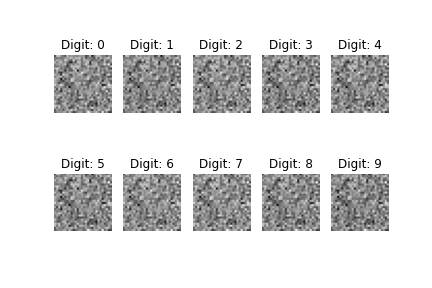

In [32]:
display.Image(filename=f'cGAN.gif')